# Predicción del precio de alquiler de la vivienda en la ciudad de Barcelona

Descripción del dataset:

|Columna|Descripción|Key|
|--|--|--|
|id|Identificador numérico de la vivienda||
|price|Precio de mercado de la vivienda||
|currency|Moneda|Euros / Mes|
|latitude|Latitud de las coordenadas geográficas de la vivienda||
|longitude|Longitud de las coordenadas geográficas de la vivienda||
|sq_meters|Metros cuadrados de la vivienda||
|sq_meters_built|Metros cuadrados construídos de la vivienda||
|rooms|Número de habitaciones||
|bathrooms|Número de baños||
|balcony|Indicador si la vivienda tiene balcón|1, 0|
|terrace|Indicador si la vivienda tiene terraza|1, 0|
|exterior|Indicador si la vivienda tiene una orientación exterior o interior en el edificio|1, 0|
|orientation|Orientación principal de la vivienda|norte, sur, este, oeste|
|floor|Piso de la vivienda||
|rooftop|Indicador si la vivienda es un ático|1, 0|
|elevator|Indicador si el edificio de la vivienda tiene ascensor|1, 0|
|doorman|Indicador si el edificio tiene portero|1,0|
|pool|Indicador si la vivienda cuenta con piscina o derecho de uso de piscina|1,0|
|ac|Indicador si tiene aire acondicionado|1,0|
|heating|Indicador si tiene calefacción|bomba, electric, gas, individual|
|year_built|Año de construcción||
|quality|Indicador de calidad de la vivienda|2 - En buen estado|
|city|Ciudad de la vivienda||
|neighborhood|Barrio de la vivienda||
|dist_city_center|Distancia en kilómetros al centro de la ciudad||
|furniture|Indicador si la vivienda cuenta con mobiliario|1: Sin Equipar; 2: Cocina Equipada; 3: Amueblado|
|garage|Indicador si la vivienda tiene garage|1, 0|
|property_type|Tipo de vivienda||
|garden|Indicador si la vivienda cuenta con jardín|1,0|
|closest_station|Nombre de la estación de metro más cercana||
|dist_closest_station|Distancia en kilómetros a la estación de metro más cercana||
|created_at|Fecha de creación del anuncio||
|last_seen|Fecha última en la que el anuncio fue publicado en la web||



#### Carga de librerías y dataset

In [1]:
# Library load
import os
import pandas as pd
import numpy as np

# Plotting library
import seaborn as sn
import matplotlib.pyplot as plt

# Funciones para hacer cálculo estadístico
import statsmodels.api as sm
from statsmodels.formula.api import ols

# sklearn packages
from sklearn.preprocessing import StandardScaler # Análisis de PCA
from sklearn import metrics # Calcula métricas para un modelo
from sklearn import tree # Cálculo de decision trees
from sklearn.tree import DecisionTreeClassifier # Generación de modelos de decision tree
from sklearn.ensemble import BaggingClassifier # Generación de modelos de bagging
from sklearn.ensemble import RandomForestClassifier # Generación de modelo de random forest
from sklearn.ensemble import GradientBoostingRegressor # Generación de modelo de gradient boosting
from sklearn.ensemble import StackingRegressor # Generación de modelo de gradient boosting
from sklearn.model_selection import train_test_split # Hace split entre training y testing
from sklearn.model_selection import cross_validate # trains model with cross validation
from sklearn.model_selection import GridSearchCV # Optimización de hiperparámetros para un modelo
from sklearn.preprocessing import OneHotEncoder # One Hot encoding de las variables categóricas

# Catboost & shap 
import catboost
import shap
# print the JS visualization code to the notebook 
shap.initjs()

# Confusion matrix viz
from mlxtend.evaluate import confusion_matrix # Calcula la matriz de confusion 
from mlxtend.plotting import plot_confusion_matrix #plot de la matriz de confusión

# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore') #ignora los errores en el notebook

In [2]:
raw_data = pd.read_csv('input/processed_renting_Barcelona.csv', delimiter = ',')
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,...,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,536625,850,€/mes,41.401708,2.154077,52.0,55,2,1,NaN,...,Gràcia,2.026455,3.0,NaN,piso,NaN,Fontana,0.094111,9/1/2021 15:58,10/4/2021 6:01
1,545910,725,€/mes,41.407221,2.135569,32.0,37,2,1,1.0,...,Sant Gervasi - La Bonanova,3.582409,NaN,NaN,piso,NaN,Vallcarca,0.902561,9/2/2021 15:24,9/8/2021 12:29
2,570697,950,€/mes,41.411508,2.164608,NaN,72,3,1,NaN,...,El Baix Guinardó,2.663025,3.0,NaN,piso,NaN,Alfons X,0.188177,8/28/2021 23:52,8/28/2021 23:52
3,591588,750,€/mes,41.402256,2.140764,NaN,45,1,1,1.0,...,Sant Gervasi - La Bonanova,2.910067,3.0,NaN,piso,NaN,Lesseps,0.892917,8/29/2021 11:25,9/8/2021 12:29
4,610243,990,€/mes,41.405327,2.146929,NaN,45,1,1,NaN,...,Sarrià-Sant Gervasi,2.727149,3.0,NaN,piso,NaN,Lesseps,0.293784,8/30/2021 13:48,8/30/2021 14:04


# Ejemplo de modelo de Bagging

Retiramos las variables que no nos importan para el modelo

In [3]:
rent_dataset = raw_data[['price', 'sq_meters_built', 'rooms', 'bathrooms', 'balcony', 'terrace', 'exterior', 'orientation', 'floor', 'rooftop', 'elevator', 'pool', 'ac', 'heating', 'year_built', 'neighborhood', 'dist_city_center', 'property_type', 'dist_closest_station']]
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station
0,850,55,2,1,NaN,NaN,1.0,norte,2.0,NaN,0.0,NaN,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111
1,725,37,2,1,1.0,NaN,1.0,sur,3.0,NaN,1.0,NaN,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561
2,950,72,3,1,NaN,NaN,1.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177
3,750,45,1,1,1.0,NaN,1.0,norte,4.0,NaN,1.0,NaN,NaN,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917
4,990,45,1,1,NaN,NaN,1.0,sur,3.0,NaN,1.0,NaN,NaN,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784


Podemos asumir que para algunas de las variables, los valores nulos son en realidad 0:

In [4]:
features_to_null = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']
for i in range(0,len(features_to_null)):
   rent_dataset[features_to_null[i]].fillna(0, inplace = True) 
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,1.0,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784


Para otras, como por ejemplo la property_age, podemos transformarla a una variable categórica incluyendo los valores nulos como una categoría de unknown:

In [5]:
rent_dataset['property_age'] = 2022 - rent_dataset['year_built']
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,1.0,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN


array([[<AxesSubplot:title={'center':'property_age'}>]], dtype=object)

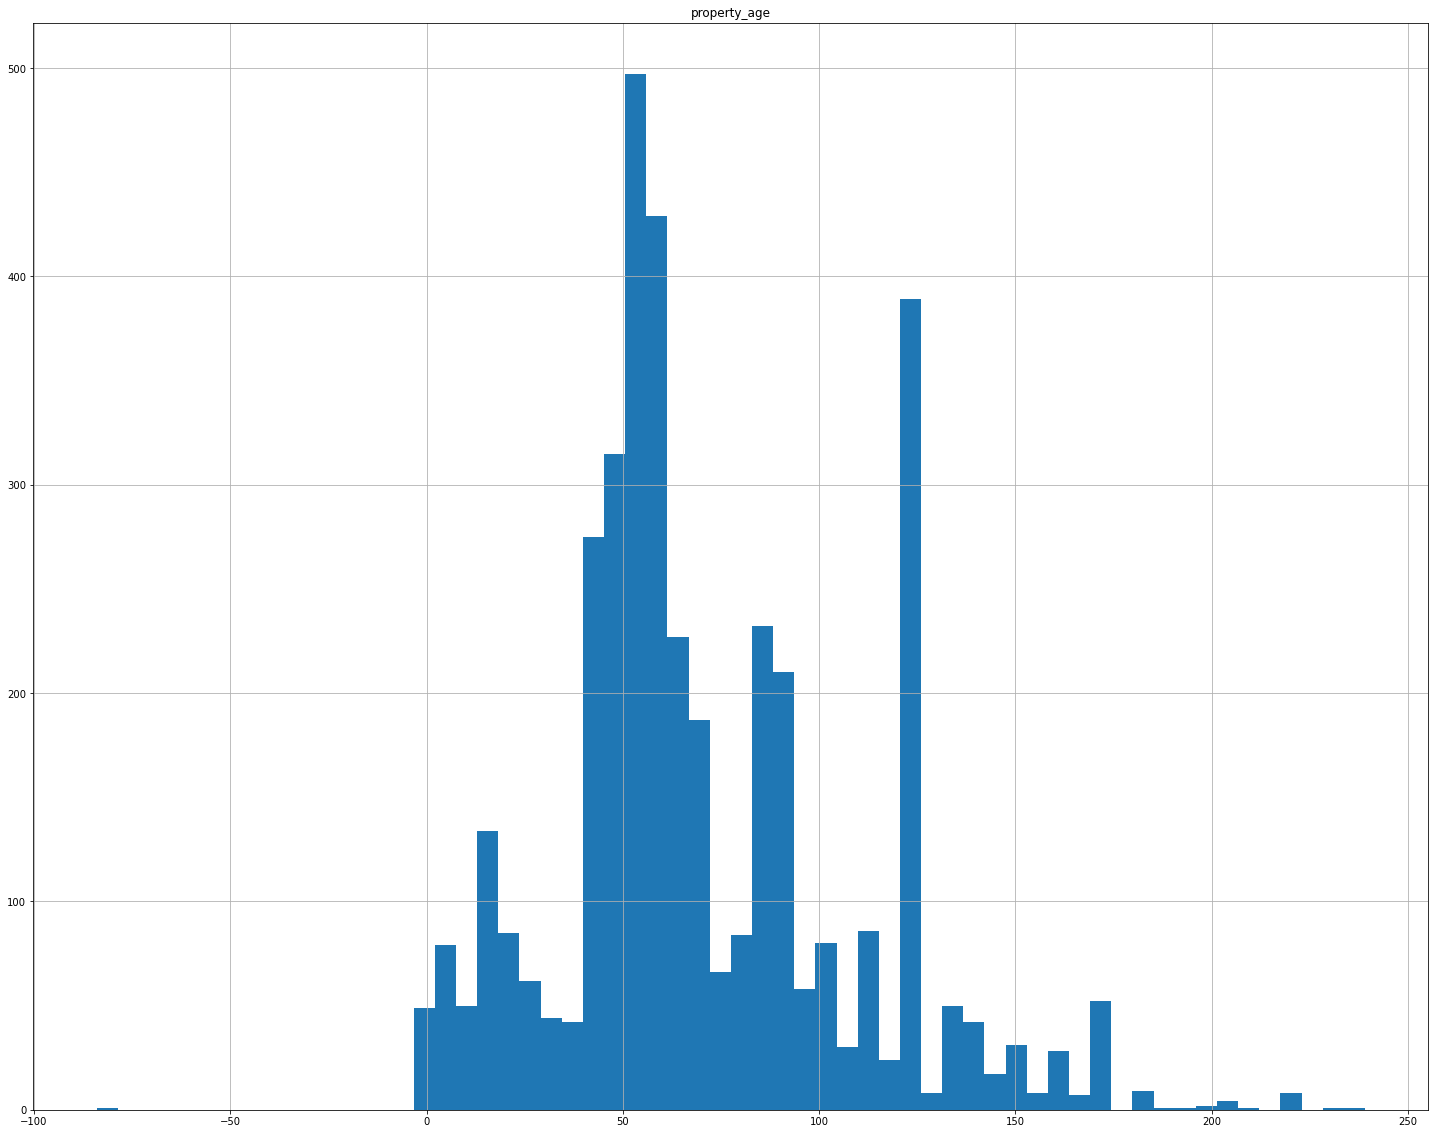

In [6]:
# Scatter matrix, similar a la función pairs. Cuidado que solo sive para variables numéricas
rent_dataset[['property_age']].hist(bins=60, figsize=(25, 20))

Apreciamos pequeños "clusters de viviendas, los cuales podemos agrupar en categorías según la edad de la vivienda:

In [7]:
def conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 40)):
        return "0 - 40"
    elif ((x >= 40) & (x < 70)):
        return "40 - 70"
    elif ((x >= 70) & (x < 120)):
        return "70 - 120"
    elif ((x >= 120) & (x < 150)):
        return "120 - 150"
    elif ((x >= 150)):
        return "+150"
    else:
        return "Unknown"

func = np.vectorize(conditions)
rent_dataset['property_age_cat'] = func(rent_dataset['property_age'])
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown


Del dataset que tenemos, generamos un subset con valores numéricos únicamente:

In [8]:
cat_features = ['neighborhood', 'property_type', 'orientation', 'heating', 'property_age_cat']
rent_dataset_numeric = rent_dataset.drop(cat_features, axis = 1)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,dist_city_center,dist_closest_station,property_age
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,NaN,2.026455,0.094111,NaN
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1962.0,3.582409,0.902561,60.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,NaN,2.663025,0.188177,NaN
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1936.0,2.910067,0.892917,86.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,NaN,2.727149,0.293784,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,0.0,0.0,1966.0,1.317748,0.285426,56.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1997.0,4.063099,0.534462,25.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,1890.0,0.288753,0.261938,132.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,NaN,3.909033,0.545561,NaN


Comprobamos que no hay nulls

In [9]:
rent_dataset_numeric_no_nulls = rent_dataset_numeric.drop(['year_built', 'property_age', 'floor'], axis = 1)
rent_dataset_numeric_no_nulls.isnull().sum() / len(rent_dataset_numeric_no_nulls)

price                   0.0
sq_meters_built         0.0
rooms                   0.0
bathrooms               0.0
balcony                 0.0
terrace                 0.0
exterior                0.0
rooftop                 0.0
elevator                0.0
pool                    0.0
ac                      0.0
dist_city_center        0.0
dist_closest_station    0.0
dtype: float64

Generamos el split

In [10]:
X = rent_dataset_numeric_no_nulls.drop(['price'], axis = 1)
y = rent_dataset_numeric_no_nulls[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Ejemplos de scoring parameter: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

En este caso optamos por un R2.

Hacemos grid search con cross validation para encontrar los parámetros óptimos de nuestro modelo

In [11]:
# we enumerate the values to try
parameters = [{"max_depth":[2,3,4,5,6,7,9], "min_samples_split":[2,5,10]}]

#instantiate the classifier
decision_tree_model = DecisionTreeClassifier()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=decision_tree_model, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10]}],
             scoring='r2')

In [12]:
grid_bag.best_params_

{'max_depth': 9, 'min_samples_split': 10}

In [13]:
# we enumerate the values to try
parameters = {"n_estimators":[1,5,10,20,50,100,200]}

#instantiate the classifier
decision_tree_model = DecisionTreeClassifier(max_depth = 9, min_samples_split = 10)

#instantiate the classifier
bagging_model = BaggingClassifier(decision_tree_model)

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=bagging_model, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

{'n_estimators': 20}

A continuación, con los parámetros óptimos del modelo, procedemos a hacer un xvalidation para entender la performance del modelo:

In [14]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = 9, min_samples_split = 10), n_estimators = 200)
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(bag, X_train, y_train, cv = 10, scoring = "r2")

In [15]:
for i, score in enumerate(model["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.6292678004749324
Accuracy for the fold no. 1 on the test set: 0.2314304942280513
Accuracy for the fold no. 2 on the test set: 0.6730695108700784
Accuracy for the fold no. 3 on the test set: 0.5273858262652391
Accuracy for the fold no. 4 on the test set: 0.7587121263797292
Accuracy for the fold no. 5 on the test set: 0.7070101174280179
Accuracy for the fold no. 6 on the test set: 0.7333689921320491
Accuracy for the fold no. 7 on the test set: 0.3341954878328953
Accuracy for the fold no. 8 on the test set: 0.4712001975281729
Accuracy for the fold no. 9 on the test set: 0.46243884342710584


Nos encontramos con que hay mucha variación con los datos de entrenamiento (R2 de 0.35 o de 0.74). Ésto nos indica que hay mucha variación en los datos y que probablemente tengamos outlayers o grupos de instancias que no estamos prediciendo correctamente

{'whiskers': [<matplotlib.lines.Line2D at 0x2032a8751f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2032a8757f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2032a7ed5e0>],
 'medians': [<matplotlib.lines.Line2D at 0x2032a875eb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2032a87d250>],
 'means': []}

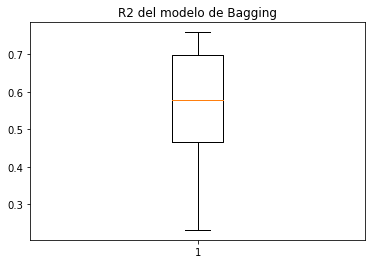

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Bagging')
ax1.boxplot(model["test_score"])

Generamos las predicciones y calculamos el resultado de validación:

In [17]:
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = 9, min_samples_split = 10), n_estimators = 20)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9,
                                                        min_samples_split=10),
                  n_estimators=20)

Error del modelo:

In [18]:
y_pred = bag.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.6791421485940959

Error en validación

In [19]:
y_pred = bag.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.500036316198907

# Ejemplo Working Lab Sesión 2: One-hot encoding, Random Forest y comparación de modelos

En primer lugar generamos un diccionario para almacenar los resultados obtenidos de todos los modelos que generemos

In [20]:
# Definimos 2 diccionarios vacíos
cv = {}
results = pd.DataFrame(columns=['model','median_r2_cv_training','r2_validation'])
# Almacenamos los resultados para el modelo decision_tree_bagging
cv['decision_tree_bagging'] = model["test_score"]
cv

{'decision_tree_bagging': array([0.6292678 , 0.23143049, 0.67306951, 0.52738583, 0.75871213,
        0.70701012, 0.73336899, 0.33419549, 0.4712002 , 0.46243884])}

In [21]:
results = pd.DataFrame(columns=['model','median_r2_cv_training','r2_validation'])
model_results = ['decision_tree_bagging', np.median(model["test_score"]), metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.578327,0.500036


Hacemos un test ANOVA para entender el impacto de las variables categóricas sobre nuestro modelo:

In [22]:
# Test ANOVA
for i in range(0, len(cat_features)):
    model_def = 'price ~ ' + cat_features[i]
    anova_model = ols(model_def, data=rent_dataset).fit()
    aov_table = sm.stats.anova_lm(anova_model, typ=2)
    print(aov_table)

                    sum_sq      df          F         PR(>F)
neighborhood  1.556514e+09    75.0  24.564561  9.791768e-300
Residual      7.118760e+09  8426.0        NaN            NaN
                     sum_sq      df           F  PR(>F)
property_type  2.192390e+09     7.0  412.708187     0.0
Residual       6.444463e+09  8492.0         NaN     NaN
                   sum_sq      df         F    PR(>F)
orientation  3.160177e+07     3.0  8.869687  0.000007
Residual     4.372860e+09  3682.0       NaN       NaN
                sum_sq      df          F        PR(>F)
heating   4.185726e+08     4.0  88.414601  6.438156e-73
Residual  6.470470e+09  5467.0        NaN           NaN
                        sum_sq      df          F        PR(>F)
property_age_cat  1.536836e+08     5.0  30.644413  5.303173e-31
Residual          8.521591e+09  8496.0        NaN           NaN


En éste caso vemos como las 3 categorías más importantes según los resultados del test ANOVA medidos mediante la F y el p value son:

- property_type
- heating
- property_age_cat
- neighborhood

Atendiendo al property type, vamos a sacar la mediana del precio de la vivienda en donde vemos una clara proporción entre barrios de precio alto, medio y bajo:

In [23]:
neighborhood = rent_dataset[['neighborhood', 'price']].groupby('neighborhood', as_index=False).agg(
    # Number of instances per category
    category_count=('price', "count"),
    # Mean price
    mean_price=('price', "mean"),
    # Median price
    median_price=('price', "median"),
    # Min price
    min_price=('price', min),
    # Max price
    max_price=('price', max),
    # Standard deviation
    stantard_deviation=('price', "std")).sort_values('median_price', ascending = False).reset_index()

neighborhood.head(60)

,index,neighborhood,category_count,mean_price,median_price,min_price,max_price,stantard_deviation
0,55,Pedralbes,49,3114.122449,2300.0,550,14000,2622.439423
1,6,Diagonal Mar i el Front Marítim del Poblenou,50,2716.300000,2150.0,890,10000,2151.594276
2,49,La Vila Olímpica del Poblenou,20,1546.950000,1722.5,750,2600,508.797289
3,52,Les Tres Torres,59,1672.288136,1500.0,460,5500,1119.686425
4,32,La Dreta de l'Eixample,309,1902.275081,1450.0,450,16800,1828.864233
5,61,Sant Gervasi - Galvany,358,1898.871508,1400.0,600,15000,1671.755972
6,70,Sarrià-Sant Gervasi,124,2425.862903,1300.0,550,20000,2862.691784
7,72,Vallvidrera - El Tibidabo i les Planes,5,4838.000000,1200.0,790,20000,8479.529468
8,69,Sarrià,146,1992.369863,1200.0,515,7700,1653.428559
9,20,El Parc i la Llacuna del Poblenou,51,1204.176471,1150.0,765,2750,390.296846


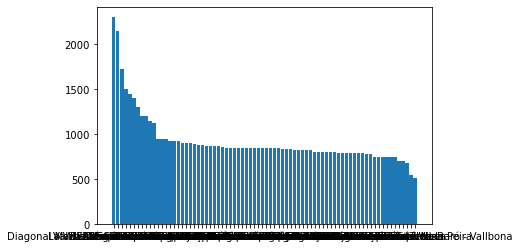

In [24]:
plt.bar(x = 'neighborhood', height = 'median_price', data = neighborhood)
plt.rcParams["figure.figsize"] = (50,20)

En este caso, podemos definir 3 tiers de precios según la zona dado que nos encontraremos con viviendas con pocas instancias

In [25]:
def conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 800)):
        return "0 - 800"
    elif ((x >= 800) & (x < 1000)):
        return "800 - 1000"
    elif ((x >= 1000)):
        return "+1000"
    else:
        return "Unknown"

func = np.vectorize(conditions)
neighborhood['neighborhood_rent_index'] = func(neighborhood['median_price'])
neighborhood.head()

,index,neighborhood,category_count,mean_price,median_price,min_price,max_price,stantard_deviation,neighborhood_rent_index
0,55,Pedralbes,49,3114.122449,2300.0,550,14000,2622.439423,+1000
1,6,Diagonal Mar i el Front Marítim del Poblenou,50,2716.300000,2150.0,890,10000,2151.594276,+1000
2,49,La Vila Olímpica del Poblenou,20,1546.950000,1722.5,750,2600,508.797289,+1000
3,52,Les Tres Torres,59,1672.288136,1500.0,460,5500,1119.686425,+1000
4,32,La Dreta de l'Eixample,309,1902.275081,1450.0,450,16800,1828.864233,+1000


Finalmente agregamos ésta información el modelo de datos

In [26]:
neighborhood_mapping = neighborhood[['neighborhood', 'neighborhood_rent_index']]
rent_dataset = pd.merge(rent_dataset, neighborhood_mapping, on='neighborhood', how='left')
cat_features.append('neighborhood_rent_index')
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Aplicamos one-hot encoding para la métrica de rent_index y para la edad del piso:

In [27]:
# select the categorical feature to do the one-hot encoding
cat_feature = 'neighborhood_rent_index'
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(rent_dataset[[cat_feature]]).toarray())
# renames columns adding a prefix with the column name
enc_df.columns = enc.categories_[0]
enc_df = enc_df.add_prefix(cat_feature + '_')
# merge with main df bridge_df on key values
rent_dataset_numeric = rent_dataset_numeric.join(enc_df)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,dist_city_center,dist_closest_station,property_age,neighborhood_rent_index_+1000,neighborhood_rent_index_0 - 800,neighborhood_rent_index_800 - 1000
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,NaN,2.026455,0.094111,NaN,0.0,0.0,1.0
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1962.0,3.582409,0.902561,60.0,0.0,0.0,1.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,NaN,2.663025,0.188177,NaN,0.0,0.0,1.0
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1936.0,2.910067,0.892917,86.0,0.0,0.0,1.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,NaN,2.727149,0.293784,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,0.0,0.0,1966.0,1.317748,0.285426,56.0,0.0,0.0,1.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1997.0,4.063099,0.534462,25.0,0.0,0.0,1.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,1890.0,0.288753,0.261938,132.0,0.0,1.0,0.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,NaN,3.909033,0.545561,NaN,0.0,0.0,1.0


In [28]:
# select the categorical feature to do the one-hot encoding
cat_feature = 'property_age_cat'
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(rent_dataset[[cat_feature]]).toarray())
# renames columns adding a prefix with the column name
enc_df.columns = enc.categories_[0]
enc_df = enc_df.add_prefix(cat_feature + '_')
# merge with main df bridge_df on key values
rent_dataset_numeric = rent_dataset_numeric.join(enc_df)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,...,property_age,neighborhood_rent_index_+1000,neighborhood_rent_index_0 - 800,neighborhood_rent_index_800 - 1000,property_age_cat_+150,property_age_cat_0 - 40,property_age_cat_120 - 150,property_age_cat_40 - 70,property_age_cat_70 - 120,property_age_cat_Unknown
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,...,60.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,...,86.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,...,56.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,...,25.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,...,132.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Hacemos un modelo de Random Forest comprobando que no hay null values

In [29]:
rent_dataset_numeric_no_nulls = rent_dataset_numeric.drop(['year_built', 'property_age', 'floor'], axis = 1)
rent_dataset_numeric_no_nulls.isnull().sum() / len(rent_dataset_numeric_no_nulls)

price                                 0.0
sq_meters_built                       0.0
rooms                                 0.0
bathrooms                             0.0
balcony                               0.0
terrace                               0.0
exterior                              0.0
rooftop                               0.0
elevator                              0.0
pool                                  0.0
ac                                    0.0
dist_city_center                      0.0
dist_closest_station                  0.0
neighborhood_rent_index_+1000         0.0
neighborhood_rent_index_0 - 800       0.0
neighborhood_rent_index_800 - 1000    0.0
property_age_cat_+150                 0.0
property_age_cat_0 - 40               0.0
property_age_cat_120 - 150            0.0
property_age_cat_40 - 70              0.0
property_age_cat_70 - 120             0.0
property_age_cat_Unknown              0.0
dtype: float64

In [30]:
X = rent_dataset_numeric_no_nulls.drop(['price'], axis = 1)
y = rent_dataset_numeric_no_nulls[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [31]:
# we enumerate the values to try
parameters = [{"n_estimators":[100,150,200], "max_depth": [5,10,15]}]

#instantiate the classifier
rf_cv = RandomForestClassifier()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=rf_cv, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [32]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf = RandomForestClassifier(n_estimators = 100, max_depth=15)
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(rf, X_train, y_train, cv = 10, scoring = "r2")
for i, score in enumerate(model["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.7607768865382951
Accuracy for the fold no. 1 on the test set: 0.7243481636537259
Accuracy for the fold no. 2 on the test set: 0.7159746373096785
Accuracy for the fold no. 3 on the test set: 0.7520070297096184
Accuracy for the fold no. 4 on the test set: 0.7842001603250686
Accuracy for the fold no. 5 on the test set: 0.6907382655062093
Accuracy for the fold no. 6 on the test set: 0.7349785584357004
Accuracy for the fold no. 7 on the test set: 0.5181539028627135
Accuracy for the fold no. 8 on the test set: 0.7550015277464844
Accuracy for the fold no. 9 on the test set: 0.665939608156358


{'whiskers': [<matplotlib.lines.Line2D at 0x2032b139100>,
 'caps': [<matplotlib.lines.Line2D at 0x2032b1397c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2032b0fae20>],
 'medians': [<matplotlib.lines.Line2D at 0x2032b139e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2032b142220>],
 'means': []}

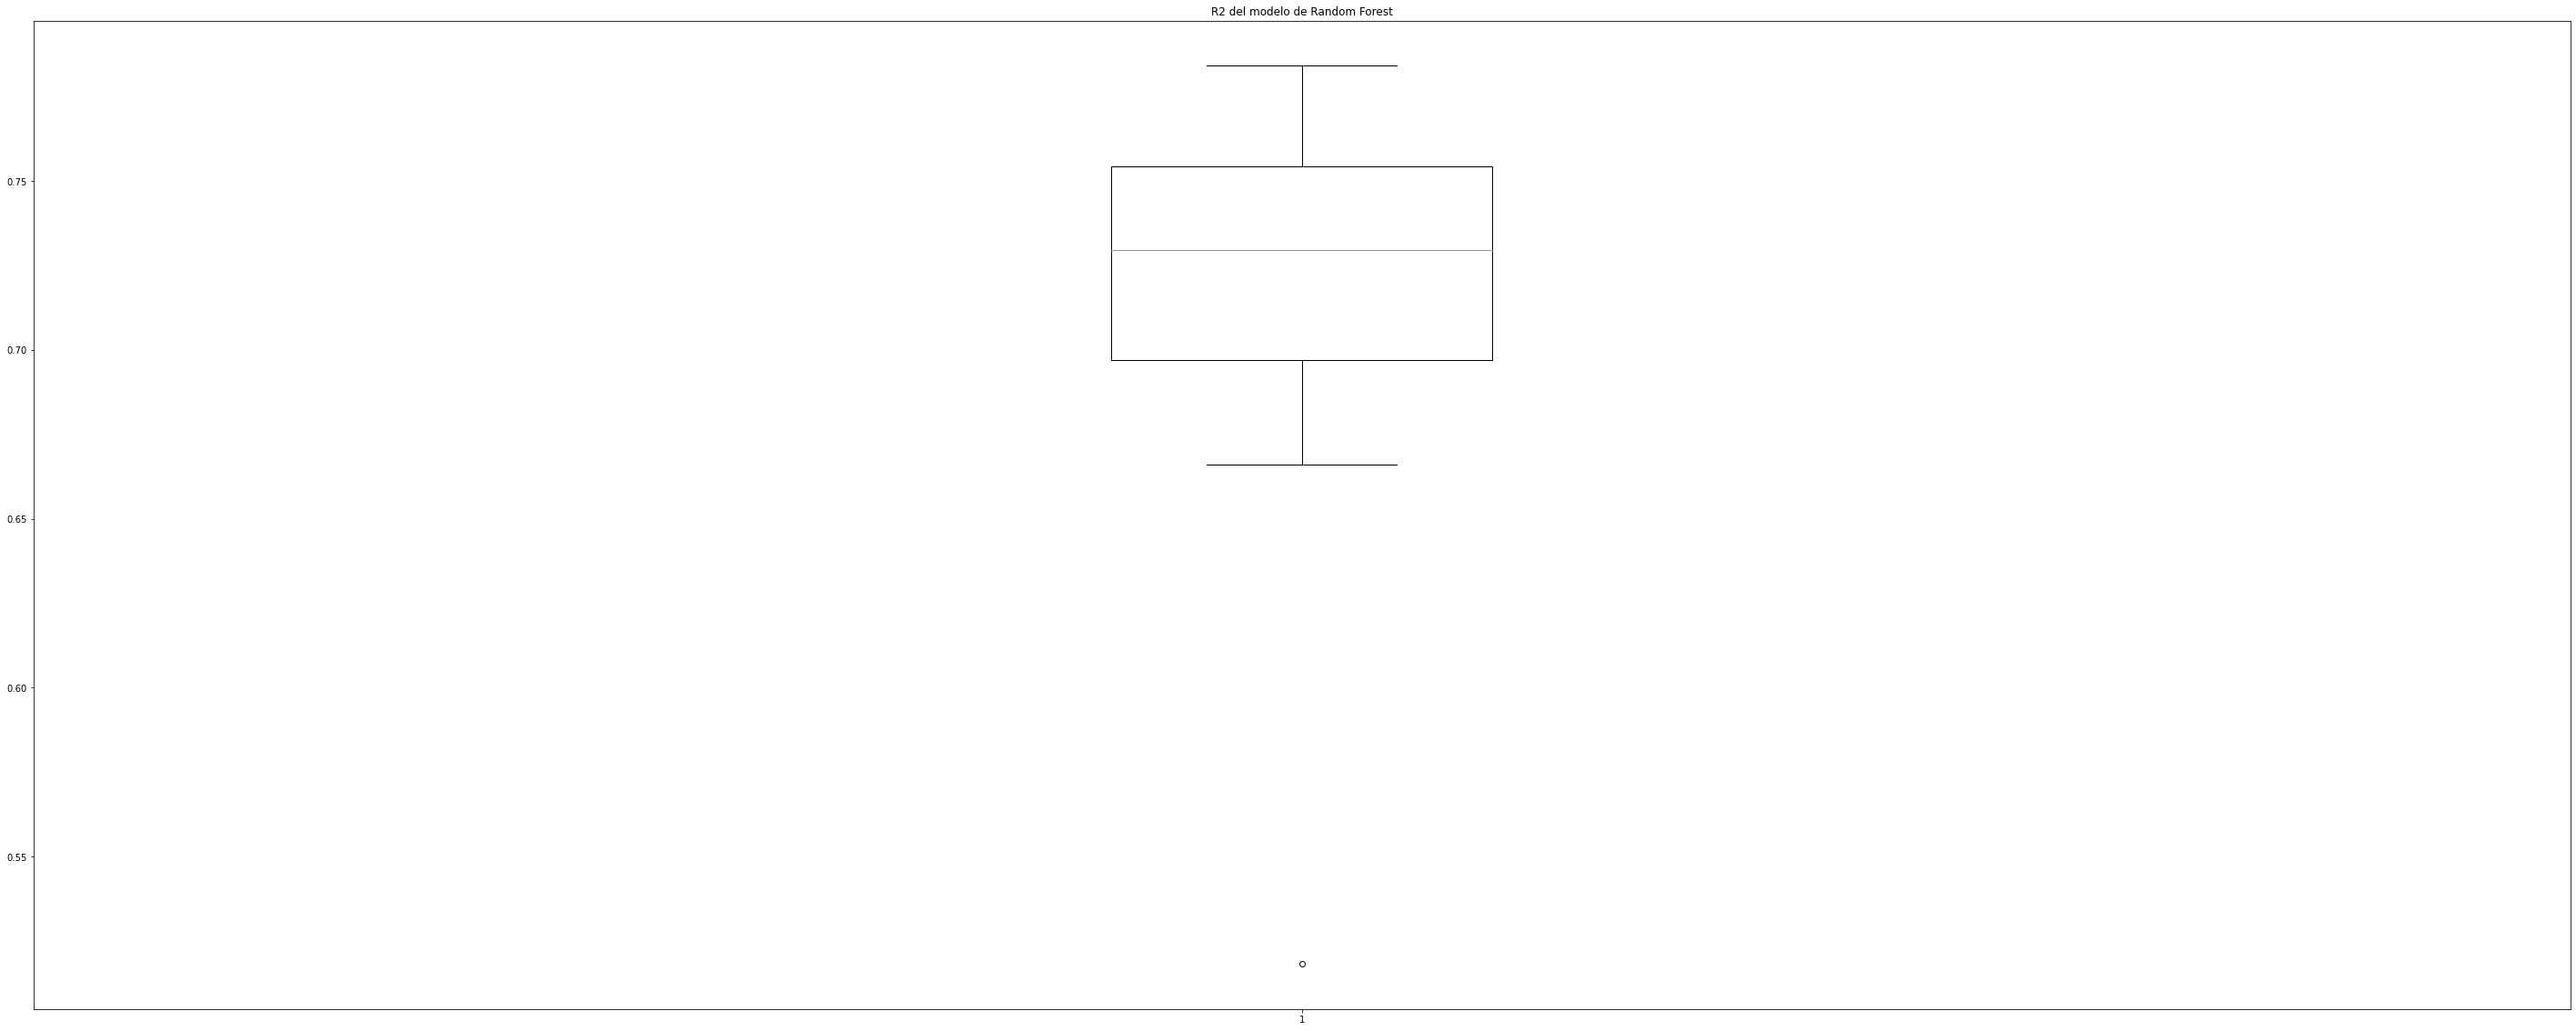

In [33]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Random Forest')
ax1.boxplot(model["test_score"])

In [34]:
np.median(model["test_score"])

0.7296633610447132

In [35]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.997722570245481

In [36]:
y_pred = rf.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.5519773147115438

In [37]:
# Almacenamos los resultados para el modelo rf_1
cv['rf_1'] = model["test_score"]

model_results = ['rf_1', np.median(model["test_score"]), metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.578327,0.500036
1,rf_1,0.729663,0.551977


{'whiskers': [<matplotlib.lines.Line2D at 0x20300c93d00>,
 'caps': [<matplotlib.lines.Line2D at 0x20300c9d400>,
 'boxes': [<matplotlib.lines.Line2D at 0x20300c939a0>,
 'medians': [<matplotlib.lines.Line2D at 0x20300c9dac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x20300c9de20>,
 'means': []}

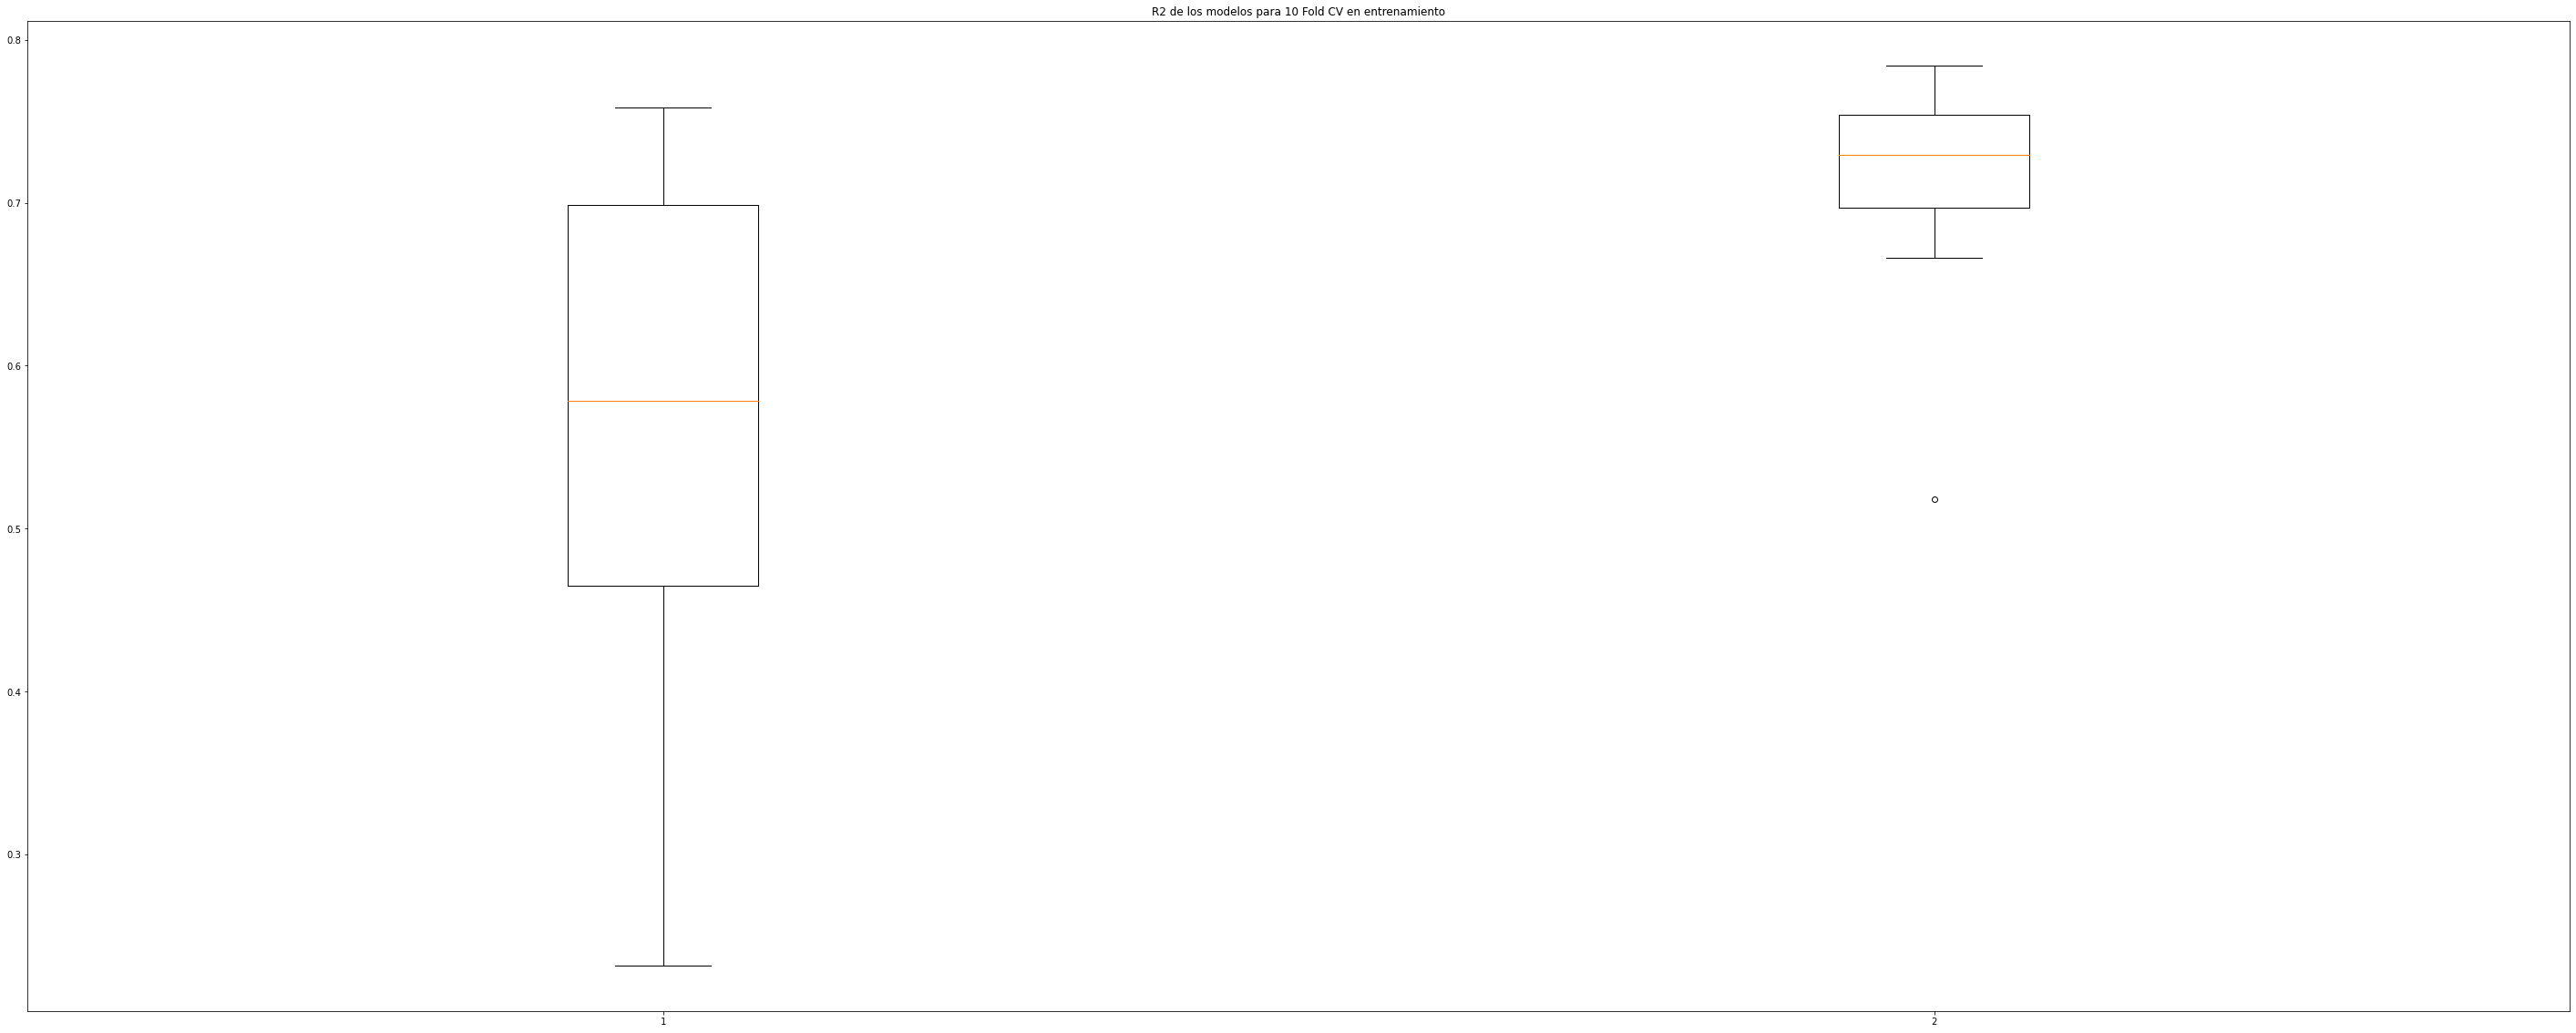

In [38]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 de los modelos para 10 Fold CV en entrenamiento')
ax1.boxplot(pd.DataFrame(cv))

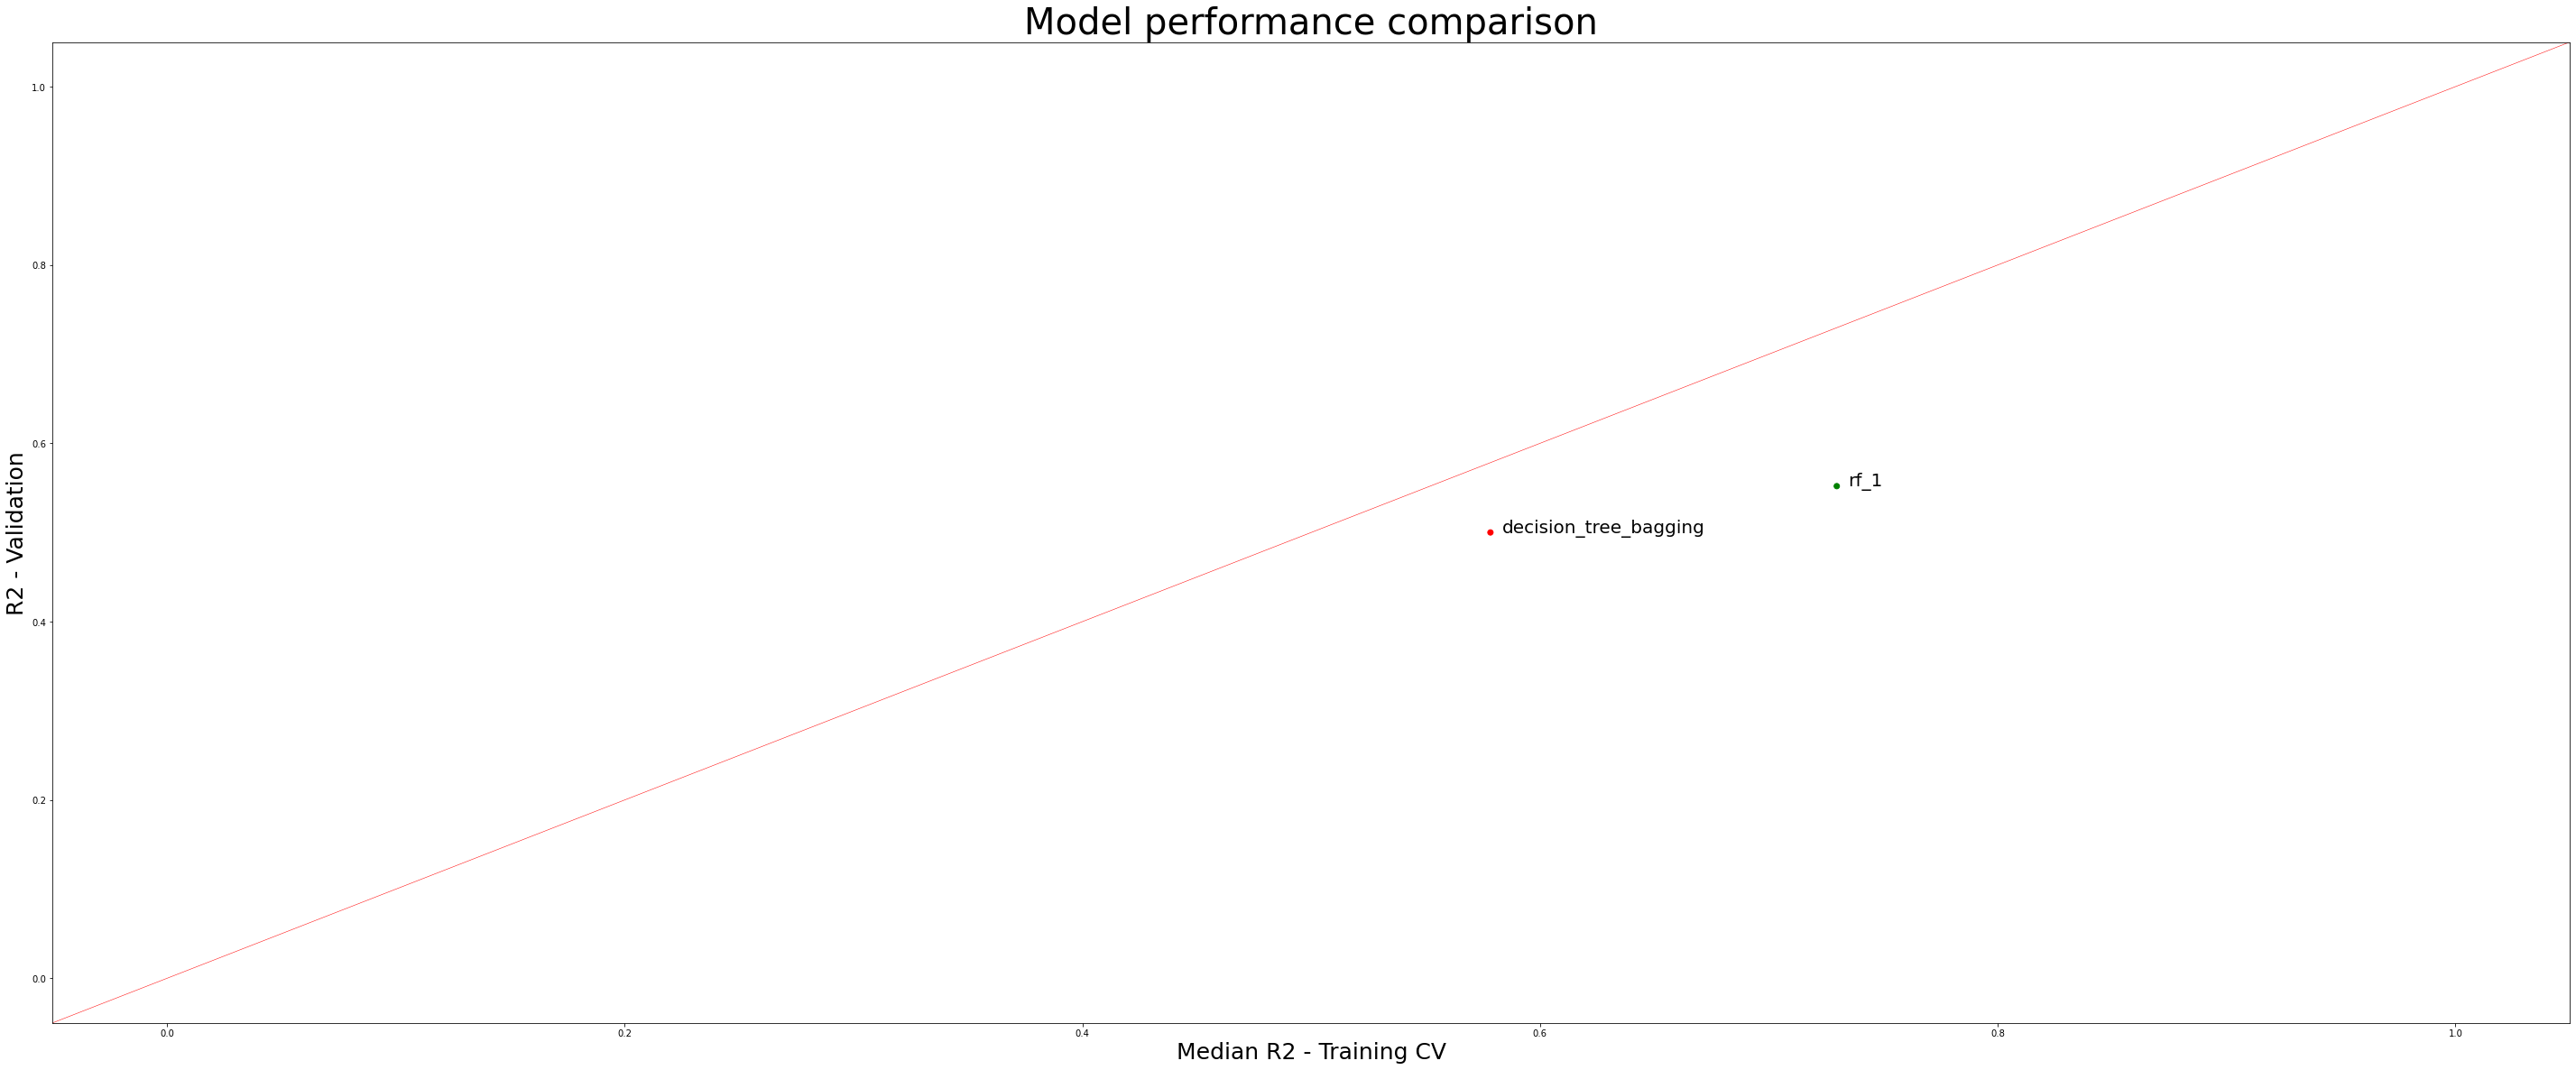

In [39]:
colors = {'decision_tree_bagging':'red', 'rf_1':'green'}
fig, ax = plt.subplots()

ax.scatter(x='median_r2_cv_training', y = 'r2_validation', data=results, c=results['model'].map(colors))
ax.axline((0, 0), (1, 1), linewidth=0.5, color='r')
plt.title("Model performance comparison", fontsize = 40)
plt.xlabel("Median R2 - Training CV", fontsize = 25)
plt.ylabel("R2 - Validation", fontsize = 25)

for i in range(0,len(results)):
    ax.annotate(results['model'][i], (results['median_r2_cv_training'][i] + 0.005, results['r2_validation'][i]), fontsize = 20)
    
plt.show()

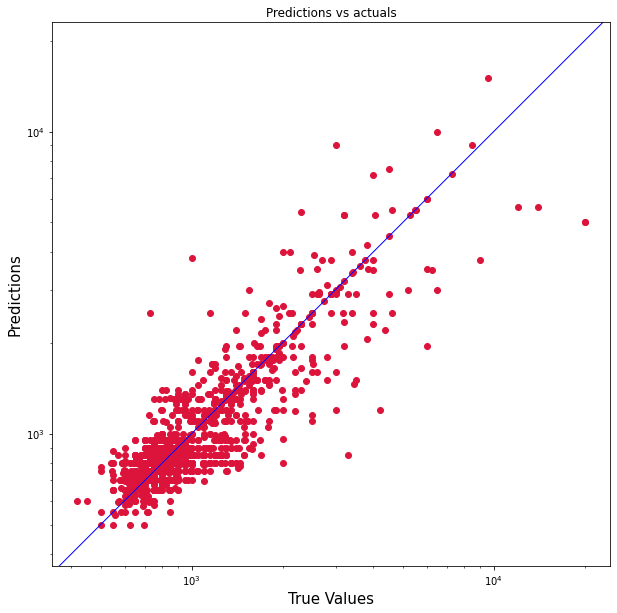

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_pred), np.max(y_test.values))
p2 = min(min(y_pred), np.min(y_test.values))
plt.axline((p2,p2), (p1,p1), linewidth=1, color='b')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Predictions vs actuals')
plt.axis('equal')
plt.show()

# Ejemplo Working Lab Sesión 3: Catboost

Recordamos que catboost admite variables categóricas. En este caso vamos a hacer limpieza del dataset y vamos a aplicar cambios adecuados:

In [41]:
catboost_dataset = rent_dataset
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Dentro de las variables categóricas había null values. Las sutituímos por una categoría Unknown

In [42]:
cat_features = ['neighborhood', 'property_type', 'orientation', 'heating', 'property_age_cat', 'neighborhood_rent_index']

In [43]:
for i in range(0,len(cat_features)):
    catboost_dataset[cat_features[i]].fillna("Unknown", inplace = True) 
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,Unknown,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,Unknown,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,4.0,0.0,...,1.0,Unknown,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,Unknown,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Comprobamos null values y vemos que hay 3 columnas, con 2 de ellas ya transformadas en la variable property_age_cat.

In [44]:
catboost_dataset.isnull().sum() / len(catboost_dataset)

price                      0.000000
sq_meters_built            0.000000
rooms                      0.000000
bathrooms                  0.000000
balcony                    0.000000
terrace                    0.000000
exterior                   0.000000
orientation                0.000000
floor                      0.231240
rooftop                    0.000000
elevator                   0.000000
pool                       0.000000
ac                         0.000000
heating                    0.000000
year_built                 0.528817
neighborhood               0.000000
dist_city_center           0.000000
property_type              0.000000
dist_closest_station       0.000000
property_age               0.528817
property_age_cat           0.000000
neighborhood_rent_index    0.000000
dtype: float64

In [45]:
catboost_dataset = catboost_dataset.drop(['property_age', 'year_built', 'neighborhood'], axis = 1)
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,4.0,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


Estudiamos la categoría floor

In [46]:
floor = rent_dataset[['floor', 'price']].groupby('floor', as_index=False).agg(
    # Number of instances per category
    category_count=('price', "count"),
    # Mean price
    mean_price=('price', "mean"),
    # Median price
    median_price=('price', "median"),
    # Min price
    min_price=('price', min),
    # Max price
    max_price=('price', max),
    # Standard deviation
    stantard_deviation=('price', "std")).sort_values('floor', ascending = True).reset_index()

floor

,index,floor,category_count,mean_price,median_price,min_price,max_price,stantard_deviation
0,0,1.0,1621,1058.713140,850.0,375,15000,872.195510
1,1,2.0,1444,1034.605956,850.0,450,8000,657.958040
2,2,3.0,1247,1076.694467,850.0,365,11000,728.365237
3,3,4.0,967,1109.232678,850.0,480,14000,919.922265
4,4,5.0,583,1124.686106,900.0,419,7250,620.034299
5,5,6.0,298,1227.724832,942.5,550,7200,820.993341
6,6,7.0,192,1345.104167,950.0,500,8000,1027.784049
7,7,8.0,87,1079.298851,900.0,460,3500,562.091797
8,8,9.0,41,1371.560976,925.0,700,3400,746.857652
9,9,10.0,21,1122.285714,850.0,675,2500,572.837424


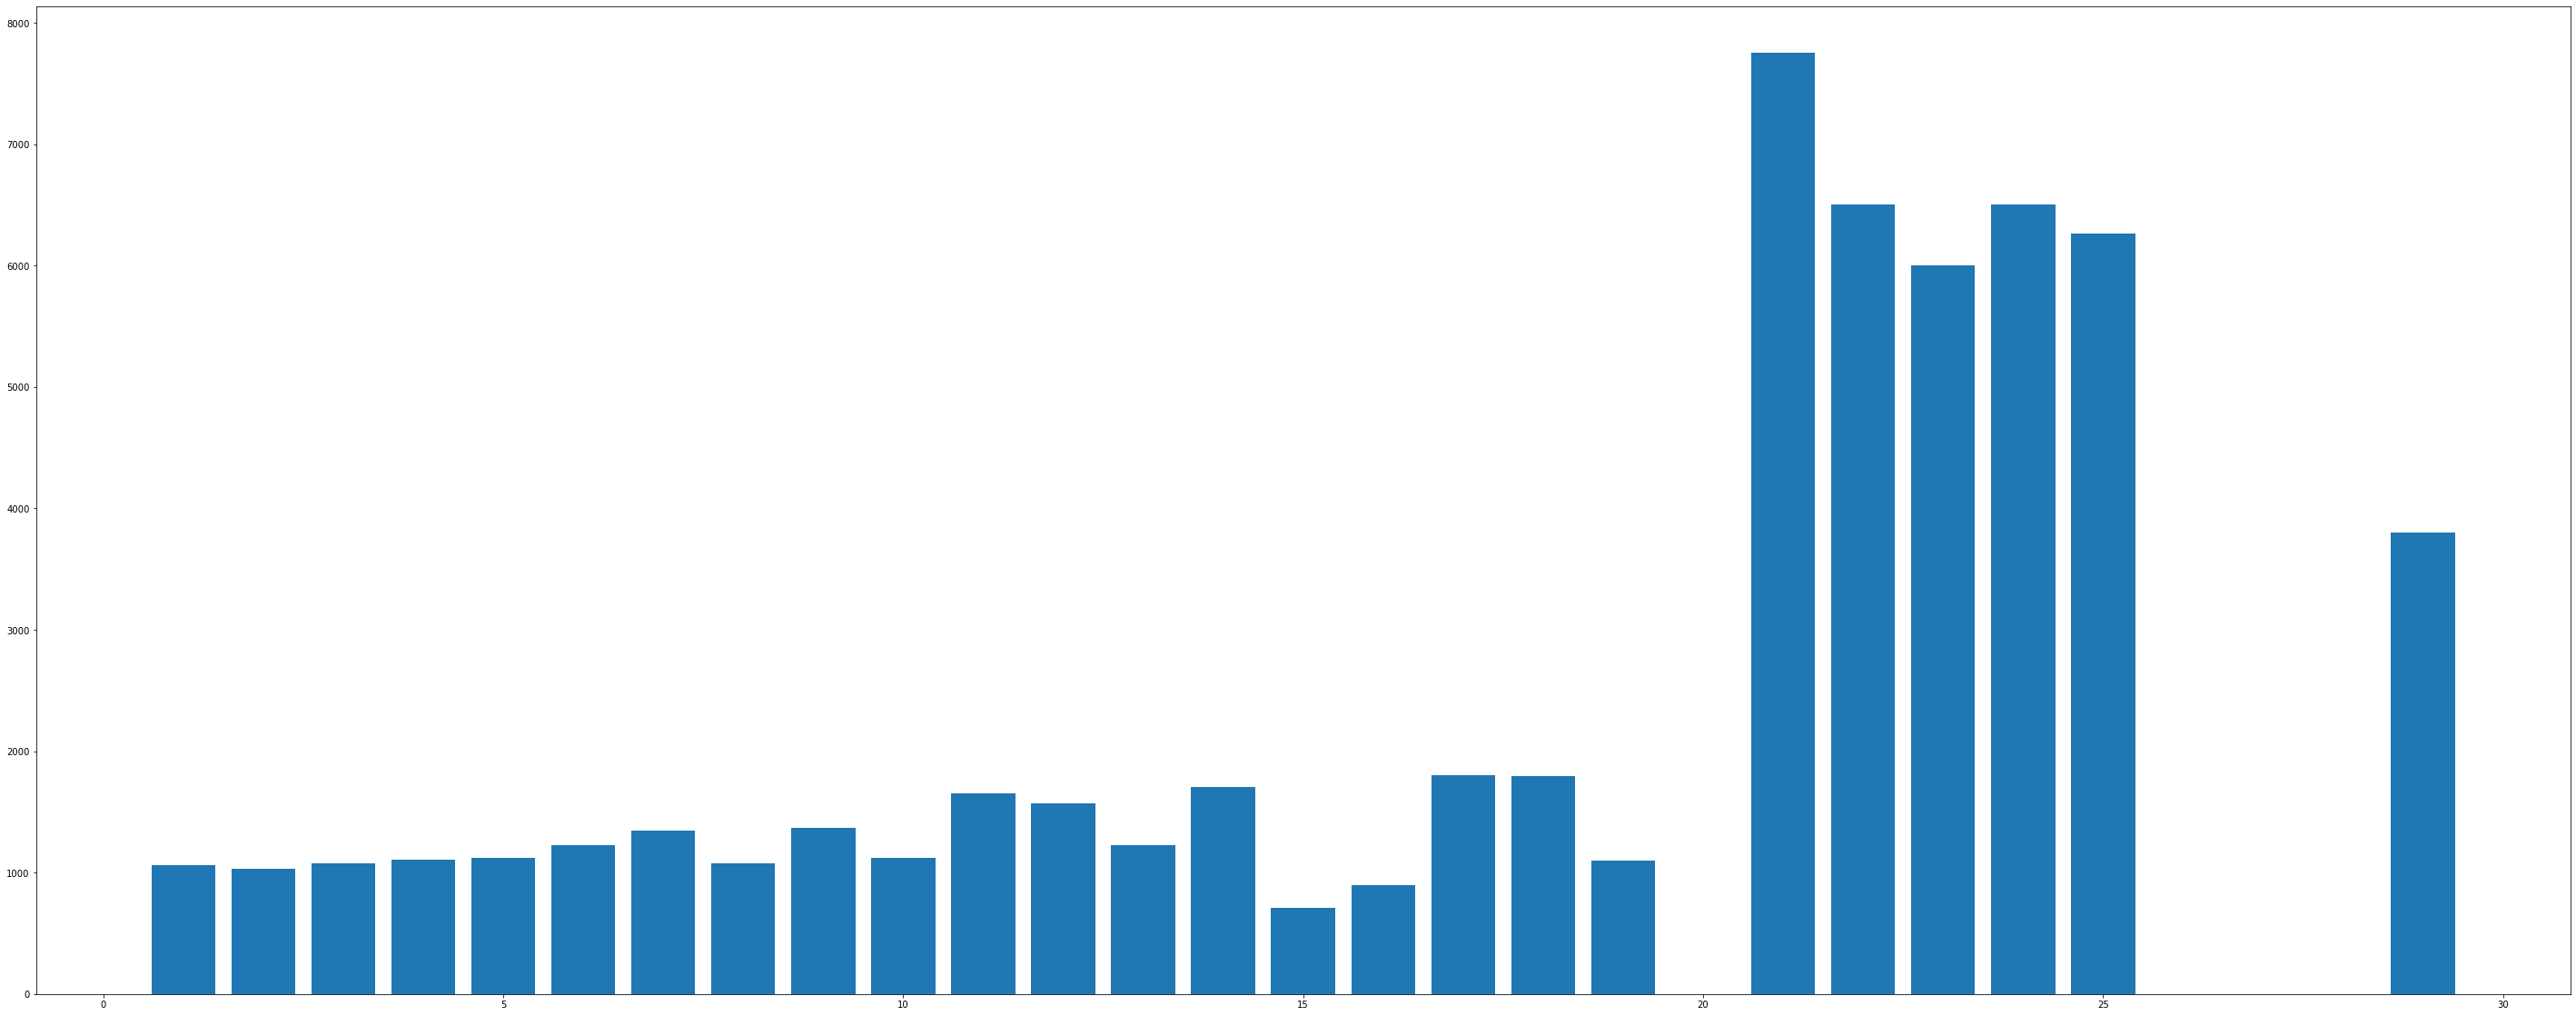

In [47]:
plt.bar(x = 'floor', height = 'mean_price', data = floor)
plt.rcParams["figure.figsize"] = (50,20)

Hacemos drop de la variable floor

Vemos que para pisos altos el precio aumenta mucho, pero tenemos muy pocas instancias (Menos de 10) y además tenemos un 20% con null values. Para este ejemplo decidimos retirarlas del modelo

In [48]:
catboost_dataset = catboost_dataset.drop(['floor'], axis = 1)
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


In [49]:
catboost_dataset.isnull().sum() / len(catboost_dataset)

price                      0.0
sq_meters_built            0.0
rooms                      0.0
bathrooms                  0.0
balcony                    0.0
terrace                    0.0
exterior                   0.0
orientation                0.0
rooftop                    0.0
elevator                   0.0
pool                       0.0
ac                         0.0
heating                    0.0
dist_city_center           0.0
property_type              0.0
dist_closest_station       0.0
property_age_cat           0.0
neighborhood_rent_index    0.0
dtype: float64

Definimos como tipo de dato "category" las categorías en nuestros datos:

In [50]:
cat_features = ['property_type', 'orientation', 'heating', 'property_age_cat', 'neighborhood_rent_index']
for i in range(0,len(cat_features)):
    catboost_dataset[cat_features[i]].astype("category")
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


Hacemos el modelo

In [51]:
import catboost as cat

In [52]:
# Target and variable
X = catboost_dataset.drop(['price'], axis = 1)
y = catboost_dataset[['price']]
# Split in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# create a train/test split with catboost
d_train_cat = cat.Pool(X_train, y_train, cat_features = cat_features)
d_test_cat = cat.Pool(X_test, y_test, cat_features = cat_features)

Gridsearch nos ayudará a generar la mejor combinación

In [53]:
model = cat.CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.015],
        'depth': [6, 8, 10, 12]}

grid_search_result = model.grid_search(grid,
                                       d_train_cat,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1479.4560124	test: 1344.2548569	best: 1344.2548569 (0)	total: 164ms	remaining: 2m 44s
1:	learn: 1445.5029794	test: 1310.7580607	best: 1310.7580607 (1)	total: 186ms	remaining: 1m 32s
2:	learn: 1412.8888991	test: 1278.3019374	best: 1278.3019374 (2)	total: 225ms	remaining: 1m 14s
3:	learn: 1380.1406035	test: 1246.6533678	best: 1246.6533678 (3)	total: 264ms	remaining: 1m 5s
4:	learn: 1349.3397392	test: 1215.8157611	best: 1215.8157611 (4)	total: 277ms	remaining: 55.1s
5:	learn: 1319.0086821	test: 1185.8381544	best: 1185.8381544 (5)	total: 296ms	remaining: 49s
6:	learn: 1290.2765973	test: 1156.9812821	best: 1156.9812821 (6)	total: 330ms	remaining: 46.8s
7:	learn: 1261.5331472	test: 1129.2899848	best: 1129.2899848 (7)	total: 346ms	remaining: 42.9s
8:	learn: 1234.7749401	test: 1101.8738007	best: 1101.8738007 (8)	total: 362ms	remaining: 39.8s
9:	learn: 1210.1833075	test: 1076.3928287	best: 1076.3928287 (9)	total: 382ms	remaining: 37.9s
10:	learn: 1185.3611245	test: 1051.8852788	best: 

89:	learn: 464.1923423	test: 425.1405032	best: 425.1405032 (89)	total: 2.31s	remaining: 23.3s
90:	learn: 461.6845479	test: 423.6093757	best: 423.6093757 (90)	total: 2.33s	remaining: 23.2s
91:	learn: 459.8367462	test: 422.8526703	best: 422.8526703 (91)	total: 2.35s	remaining: 23.2s
92:	learn: 457.7974030	test: 422.0974671	best: 422.0974671 (92)	total: 2.38s	remaining: 23.2s
93:	learn: 455.4951314	test: 421.4574607	best: 421.4574607 (93)	total: 2.4s	remaining: 23.1s
94:	learn: 453.4814278	test: 420.4814875	best: 420.4814875 (94)	total: 2.42s	remaining: 23s
95:	learn: 451.6121769	test: 420.0977137	best: 420.0977137 (95)	total: 2.43s	remaining: 22.9s
96:	learn: 449.8578086	test: 419.6011645	best: 419.6011645 (96)	total: 2.44s	remaining: 22.8s
97:	learn: 447.8327742	test: 418.7299749	best: 418.7299749 (97)	total: 2.46s	remaining: 22.6s
98:	learn: 445.7102917	test: 418.7978456	best: 418.7299749 (97)	total: 2.52s	remaining: 23s
99:	learn: 444.0027770	test: 418.3912214	best: 418.3912214 (99)	t

177:	learn: 372.1753004	test: 403.8701609	best: 403.6110484 (173)	total: 3.96s	remaining: 18.3s
178:	learn: 371.4717191	test: 403.7972005	best: 403.6110484 (173)	total: 3.98s	remaining: 18.2s
179:	learn: 370.7574373	test: 403.6561678	best: 403.6110484 (173)	total: 4s	remaining: 18.2s
180:	learn: 370.1387281	test: 403.1517540	best: 403.1517540 (180)	total: 4.01s	remaining: 18.2s
181:	learn: 368.7395785	test: 403.0854099	best: 403.0854099 (181)	total: 4.05s	remaining: 18.2s
182:	learn: 368.5092039	test: 403.0804265	best: 403.0804265 (182)	total: 4.06s	remaining: 18.1s
183:	learn: 368.2685672	test: 403.0748307	best: 403.0748307 (183)	total: 4.08s	remaining: 18.1s
184:	learn: 367.1957399	test: 403.2372045	best: 403.0748307 (183)	total: 4.11s	remaining: 18.1s
185:	learn: 366.8247048	test: 403.3122448	best: 403.0748307 (183)	total: 4.15s	remaining: 18.1s
186:	learn: 366.6033304	test: 403.3069402	best: 403.0748307 (183)	total: 4.16s	remaining: 18.1s
187:	learn: 365.1962331	test: 403.1463782	b

269:	learn: 328.3856822	test: 394.6540648	best: 394.6540648 (269)	total: 5.71s	remaining: 15.4s
270:	learn: 328.0253112	test: 394.7729608	best: 394.6540648 (269)	total: 5.72s	remaining: 15.4s
271:	learn: 327.6498336	test: 394.4062461	best: 394.4062461 (271)	total: 5.75s	remaining: 15.4s
272:	learn: 327.1342034	test: 394.4521250	best: 394.4062461 (271)	total: 5.76s	remaining: 15.3s
273:	learn: 326.6032166	test: 393.8557543	best: 393.8557543 (273)	total: 5.79s	remaining: 15.3s
274:	learn: 326.0086157	test: 393.3724252	best: 393.3724252 (274)	total: 5.8s	remaining: 15.3s
275:	learn: 325.6547514	test: 393.2667452	best: 393.2667452 (275)	total: 5.83s	remaining: 15.3s
276:	learn: 325.4149011	test: 393.2897728	best: 393.2667452 (275)	total: 5.86s	remaining: 15.3s
277:	learn: 325.1696533	test: 393.1322071	best: 393.1322071 (277)	total: 5.89s	remaining: 15.3s
278:	learn: 324.9632508	test: 393.0259598	best: 393.0259598 (278)	total: 5.9s	remaining: 15.3s
279:	learn: 324.6432837	test: 392.7565042	

360:	learn: 303.5125547	test: 385.4599385	best: 385.4599385 (360)	total: 7.38s	remaining: 13.1s
361:	learn: 303.2368782	test: 385.3728585	best: 385.3728585 (361)	total: 7.4s	remaining: 13s
362:	learn: 303.1655776	test: 385.3509683	best: 385.3509683 (362)	total: 7.42s	remaining: 13s
363:	learn: 303.0034201	test: 385.4774948	best: 385.3509683 (362)	total: 7.45s	remaining: 13s
364:	learn: 302.7936420	test: 385.5008982	best: 385.3509683 (362)	total: 7.47s	remaining: 13s
365:	learn: 302.6033796	test: 385.6356672	best: 385.3509683 (362)	total: 7.49s	remaining: 13s
366:	learn: 302.4165585	test: 385.5490791	best: 385.3509683 (362)	total: 7.51s	remaining: 12.9s
367:	learn: 302.3528688	test: 385.5500438	best: 385.3509683 (362)	total: 7.52s	remaining: 12.9s
368:	learn: 302.1286988	test: 385.5232395	best: 385.3509683 (362)	total: 7.53s	remaining: 12.9s
369:	learn: 301.6014157	test: 385.2704393	best: 385.2704393 (369)	total: 7.55s	remaining: 12.9s
370:	learn: 300.9236996	test: 385.2020187	best: 385

456:	learn: 287.0120876	test: 383.4111526	best: 383.3481922 (453)	total: 9.29s	remaining: 11s
457:	learn: 286.8852152	test: 383.3665190	best: 383.3481922 (453)	total: 9.3s	remaining: 11s
458:	learn: 286.7895557	test: 383.3643394	best: 383.3481922 (453)	total: 9.31s	remaining: 11s
459:	learn: 286.7443026	test: 383.3746735	best: 383.3481922 (453)	total: 9.33s	remaining: 10.9s
460:	learn: 286.6543836	test: 383.3760651	best: 383.3481922 (453)	total: 9.35s	remaining: 10.9s
461:	learn: 286.6002616	test: 383.4555675	best: 383.3481922 (453)	total: 9.38s	remaining: 10.9s
462:	learn: 286.5699681	test: 383.4411854	best: 383.3481922 (453)	total: 9.39s	remaining: 10.9s
463:	learn: 286.3600584	test: 383.3075346	best: 383.3075346 (463)	total: 9.41s	remaining: 10.9s
464:	learn: 286.3159284	test: 383.2936142	best: 383.2936142 (464)	total: 9.42s	remaining: 10.8s
465:	learn: 286.2307464	test: 383.2957517	best: 383.2936142 (464)	total: 9.46s	remaining: 10.8s
466:	learn: 286.0710491	test: 383.0745332	best:

551:	learn: 274.2974529	test: 380.7630573	best: 380.3540441 (540)	total: 11.1s	remaining: 9.04s
552:	learn: 274.2091486	test: 380.7418948	best: 380.3540441 (540)	total: 11.2s	remaining: 9.02s
553:	learn: 274.1186832	test: 380.7177577	best: 380.3540441 (540)	total: 11.2s	remaining: 8.99s
554:	learn: 274.0507462	test: 380.7868310	best: 380.3540441 (540)	total: 11.2s	remaining: 8.97s
555:	learn: 273.8301844	test: 380.5684099	best: 380.3540441 (540)	total: 11.2s	remaining: 8.94s
556:	learn: 273.8132997	test: 380.5551245	best: 380.3540441 (540)	total: 11.2s	remaining: 8.92s
557:	learn: 273.6811842	test: 380.5570256	best: 380.3540441 (540)	total: 11.2s	remaining: 8.9s
558:	learn: 273.6448138	test: 380.5270014	best: 380.3540441 (540)	total: 11.2s	remaining: 8.88s
559:	learn: 273.6273414	test: 380.5273140	best: 380.3540441 (540)	total: 11.3s	remaining: 8.85s
560:	learn: 273.5261018	test: 380.5404189	best: 380.3540441 (540)	total: 11.3s	remaining: 8.82s
561:	learn: 273.3955310	test: 380.3865991

648:	learn: 262.4843889	test: 378.5339157	best: 378.5339157 (648)	total: 13.1s	remaining: 7.08s
649:	learn: 262.2627369	test: 378.4767545	best: 378.4767545 (649)	total: 13.1s	remaining: 7.05s
650:	learn: 262.1986365	test: 378.4410009	best: 378.4410009 (650)	total: 13.1s	remaining: 7.03s
651:	learn: 262.1699558	test: 378.4452787	best: 378.4410009 (650)	total: 13.1s	remaining: 7.01s
652:	learn: 262.0877144	test: 378.4400782	best: 378.4400782 (652)	total: 13.1s	remaining: 6.98s
653:	learn: 261.9814662	test: 378.4472990	best: 378.4400782 (652)	total: 13.2s	remaining: 6.96s
654:	learn: 261.8676849	test: 378.4290296	best: 378.4290296 (654)	total: 13.2s	remaining: 6.95s
655:	learn: 261.7443453	test: 378.4065397	best: 378.4065397 (655)	total: 13.2s	remaining: 6.94s
656:	learn: 261.7356610	test: 378.4065304	best: 378.4065304 (656)	total: 13.2s	remaining: 6.92s
657:	learn: 261.6706557	test: 378.3982100	best: 378.3982100 (657)	total: 13.3s	remaining: 6.9s
658:	learn: 261.6607318	test: 378.3980353

739:	learn: 252.0254691	test: 376.9267362	best: 376.9267362 (739)	total: 15s	remaining: 5.27s
740:	learn: 251.9463164	test: 376.9171000	best: 376.9171000 (740)	total: 15s	remaining: 5.25s
741:	learn: 251.6828127	test: 376.9443974	best: 376.9171000 (740)	total: 15s	remaining: 5.22s
742:	learn: 251.6674045	test: 376.9384494	best: 376.9171000 (740)	total: 15.1s	remaining: 5.21s
743:	learn: 251.6366372	test: 376.9148681	best: 376.9148681 (743)	total: 15.1s	remaining: 5.19s
744:	learn: 251.5299016	test: 376.9856132	best: 376.9148681 (743)	total: 15.1s	remaining: 5.17s
745:	learn: 251.3119598	test: 376.9168786	best: 376.9148681 (743)	total: 15.1s	remaining: 5.15s
746:	learn: 251.2498801	test: 376.9040958	best: 376.9040958 (746)	total: 15.1s	remaining: 5.13s
747:	learn: 251.1018400	test: 376.8516309	best: 376.8516309 (747)	total: 15.2s	remaining: 5.11s
748:	learn: 250.9805686	test: 376.8809842	best: 376.8516309 (747)	total: 15.2s	remaining: 5.08s
749:	learn: 250.8046271	test: 376.8523888	best

826:	learn: 243.0994277	test: 375.6214942	best: 375.6214942 (826)	total: 16.9s	remaining: 3.54s
827:	learn: 243.0159061	test: 375.7143866	best: 375.6214942 (826)	total: 16.9s	remaining: 3.51s
828:	learn: 242.9832006	test: 375.6757187	best: 375.6214942 (826)	total: 16.9s	remaining: 3.49s
829:	learn: 242.8592256	test: 375.6440622	best: 375.6214942 (826)	total: 16.9s	remaining: 3.47s
830:	learn: 242.6649768	test: 375.5819901	best: 375.5819901 (830)	total: 17s	remaining: 3.45s
831:	learn: 242.6192492	test: 375.6308496	best: 375.5819901 (830)	total: 17s	remaining: 3.43s
832:	learn: 242.5491761	test: 375.6126259	best: 375.5819901 (830)	total: 17s	remaining: 3.41s
833:	learn: 242.5093648	test: 375.6325297	best: 375.5819901 (830)	total: 17s	remaining: 3.39s
834:	learn: 242.4911870	test: 375.6248036	best: 375.5819901 (830)	total: 17s	remaining: 3.37s
835:	learn: 242.4440810	test: 375.6275274	best: 375.5819901 (830)	total: 17.1s	remaining: 3.35s
836:	learn: 242.3008347	test: 375.4863851	best: 37

917:	learn: 234.9833532	test: 373.9328843	best: 373.9328843 (917)	total: 18.7s	remaining: 1.67s
918:	learn: 234.8074713	test: 373.8763267	best: 373.8763267 (918)	total: 18.7s	remaining: 1.65s
919:	learn: 234.7288874	test: 373.8701326	best: 373.8701326 (919)	total: 18.7s	remaining: 1.63s
920:	learn: 234.5996670	test: 373.8704443	best: 373.8701326 (919)	total: 18.7s	remaining: 1.6s
921:	learn: 234.5773744	test: 373.8198473	best: 373.8198473 (921)	total: 18.8s	remaining: 1.59s
922:	learn: 234.5066517	test: 373.8376803	best: 373.8198473 (921)	total: 18.8s	remaining: 1.57s
923:	learn: 234.4389549	test: 373.8703347	best: 373.8198473 (921)	total: 18.8s	remaining: 1.55s
924:	learn: 234.4021019	test: 373.8472986	best: 373.8198473 (921)	total: 18.8s	remaining: 1.53s
925:	learn: 234.3610266	test: 373.6886661	best: 373.6886661 (925)	total: 18.8s	remaining: 1.51s
926:	learn: 234.1951085	test: 373.6593281	best: 373.6593281 (926)	total: 18.9s	remaining: 1.49s
927:	learn: 234.1416790	test: 373.6400777

12:	learn: 1306.0226748	test: 1171.6009019	best: 1171.6009019 (12)	total: 242ms	remaining: 18.4s
13:	learn: 1291.6587476	test: 1157.2105971	best: 1157.2105971 (13)	total: 258ms	remaining: 18.2s
14:	learn: 1277.3614856	test: 1142.6924283	best: 1142.6924283 (14)	total: 274ms	remaining: 18s
15:	learn: 1262.9894272	test: 1127.5108043	best: 1127.5108043 (15)	total: 314ms	remaining: 19.3s
16:	learn: 1250.3102444	test: 1114.8922497	best: 1114.8922497 (16)	total: 346ms	remaining: 20s
17:	learn: 1237.7121804	test: 1102.7113986	best: 1102.7113986 (17)	total: 361ms	remaining: 19.7s
18:	learn: 1224.9576450	test: 1090.3636995	best: 1090.3636995 (18)	total: 439ms	remaining: 22.7s
19:	learn: 1212.1182963	test: 1077.5086850	best: 1077.5086850 (19)	total: 461ms	remaining: 22.6s
20:	learn: 1199.3276926	test: 1064.9150948	best: 1064.9150948 (20)	total: 499ms	remaining: 23.2s
21:	learn: 1187.1759620	test: 1052.4249662	best: 1052.4249662 (21)	total: 514ms	remaining: 22.9s
22:	learn: 1174.9742862	test: 1040

105:	learn: 621.1624447	test: 522.3859635	best: 522.3859635 (105)	total: 2.66s	remaining: 22.4s
106:	learn: 618.7066146	test: 520.5104442	best: 520.5104442 (106)	total: 2.68s	remaining: 22.4s
107:	learn: 615.4369635	test: 518.1602711	best: 518.1602711 (107)	total: 2.7s	remaining: 22.3s
108:	learn: 612.3098239	test: 515.8672495	best: 515.8672495 (108)	total: 2.77s	remaining: 22.6s
109:	learn: 609.3231785	test: 513.5048073	best: 513.5048073 (109)	total: 2.78s	remaining: 22.5s
110:	learn: 606.2622732	test: 511.1871263	best: 511.1871263 (110)	total: 2.84s	remaining: 22.8s
111:	learn: 603.4362242	test: 509.0622033	best: 509.0622033 (111)	total: 2.88s	remaining: 22.8s
112:	learn: 600.5269742	test: 507.1292625	best: 507.1292625 (112)	total: 2.9s	remaining: 22.8s
113:	learn: 597.4641172	test: 504.9338588	best: 504.9338588 (113)	total: 2.92s	remaining: 22.7s
114:	learn: 594.4637647	test: 502.2107294	best: 502.2107294 (114)	total: 2.94s	remaining: 22.6s
115:	learn: 591.4632654	test: 499.8393483	

195:	learn: 462.2244033	test: 427.8775485	best: 427.8775485 (195)	total: 4.58s	remaining: 18.8s
196:	learn: 461.4318018	test: 427.6726359	best: 427.6726359 (196)	total: 4.6s	remaining: 18.7s
197:	learn: 460.4150818	test: 427.4436216	best: 427.4436216 (197)	total: 4.61s	remaining: 18.7s
198:	learn: 459.8686887	test: 427.2916571	best: 427.2916571 (198)	total: 4.63s	remaining: 18.6s
199:	learn: 459.1403446	test: 427.0510242	best: 427.0510242 (199)	total: 4.65s	remaining: 18.6s
200:	learn: 458.1851734	test: 426.7947771	best: 426.7947771 (200)	total: 4.68s	remaining: 18.6s
201:	learn: 457.3300520	test: 426.3193564	best: 426.3193564 (201)	total: 4.71s	remaining: 18.6s
202:	learn: 456.6062240	test: 426.0030146	best: 426.0030146 (202)	total: 4.81s	remaining: 18.9s
203:	learn: 455.5173595	test: 425.4613078	best: 425.4613078 (203)	total: 4.84s	remaining: 18.9s
204:	learn: 454.4734806	test: 424.6861072	best: 424.6861072 (204)	total: 4.87s	remaining: 18.9s
205:	learn: 453.5888846	test: 424.5024995

293:	learn: 402.7430754	test: 413.2543902	best: 413.2466564 (292)	total: 6.5s	remaining: 15.6s
294:	learn: 402.5630097	test: 413.2506581	best: 413.2466564 (292)	total: 6.51s	remaining: 15.5s
295:	learn: 402.1276163	test: 413.2657828	best: 413.2466564 (292)	total: 6.52s	remaining: 15.5s
296:	learn: 401.6571018	test: 413.0200787	best: 413.0200787 (296)	total: 6.54s	remaining: 15.5s
297:	learn: 401.3060976	test: 412.9670951	best: 412.9670951 (297)	total: 6.58s	remaining: 15.5s
298:	learn: 401.1277167	test: 412.9588194	best: 412.9588194 (298)	total: 6.6s	remaining: 15.5s
299:	learn: 400.8133698	test: 412.9400707	best: 412.9400707 (299)	total: 6.63s	remaining: 15.5s
300:	learn: 400.6350781	test: 412.9150525	best: 412.9150525 (300)	total: 6.66s	remaining: 15.5s
301:	learn: 400.2363913	test: 412.7695184	best: 412.7695184 (301)	total: 6.71s	remaining: 15.5s
302:	learn: 400.0005589	test: 412.7392607	best: 412.7392607 (302)	total: 6.73s	remaining: 15.5s
303:	learn: 399.5671303	test: 412.6942860	

380:	learn: 375.4874425	test: 407.9608801	best: 407.9608801 (380)	total: 8.23s	remaining: 13.4s
381:	learn: 375.0478116	test: 407.6160790	best: 407.6160790 (381)	total: 8.24s	remaining: 13.3s
382:	learn: 374.4859156	test: 407.5371942	best: 407.5371942 (382)	total: 8.25s	remaining: 13.3s
383:	learn: 374.2380286	test: 407.2709218	best: 407.2709218 (383)	total: 8.28s	remaining: 13.3s
384:	learn: 373.7295784	test: 407.0483801	best: 407.0483801 (384)	total: 8.3s	remaining: 13.3s
385:	learn: 373.2522308	test: 406.9884152	best: 406.9884152 (385)	total: 8.32s	remaining: 13.2s
386:	learn: 373.0185741	test: 406.9462249	best: 406.9462249 (386)	total: 8.33s	remaining: 13.2s
387:	learn: 372.7868639	test: 407.0649552	best: 406.9462249 (386)	total: 8.35s	remaining: 13.2s
388:	learn: 372.5432053	test: 407.1932142	best: 406.9462249 (386)	total: 8.37s	remaining: 13.2s
389:	learn: 372.3862900	test: 407.1548994	best: 406.9462249 (386)	total: 8.4s	remaining: 13.1s
390:	learn: 372.1174666	test: 407.0525206	

467:	learn: 350.4246295	test: 401.9212383	best: 401.8706232 (464)	total: 9.95s	remaining: 11.3s
468:	learn: 350.0566244	test: 401.6762193	best: 401.6762193 (468)	total: 9.96s	remaining: 11.3s
469:	learn: 350.0020307	test: 401.6746898	best: 401.6746898 (469)	total: 9.97s	remaining: 11.2s
470:	learn: 349.6795219	test: 401.6380272	best: 401.6380272 (470)	total: 9.98s	remaining: 11.2s
471:	learn: 349.3692218	test: 401.5730429	best: 401.5730429 (471)	total: 10s	remaining: 11.2s
472:	learn: 349.3142091	test: 401.5714330	best: 401.5714330 (472)	total: 10s	remaining: 11.1s
473:	learn: 349.1306035	test: 401.5528253	best: 401.5528253 (473)	total: 10s	remaining: 11.1s
474:	learn: 348.7662128	test: 401.2497590	best: 401.2497590 (474)	total: 10.1s	remaining: 11.1s
475:	learn: 348.6037118	test: 401.3296940	best: 401.2497590 (474)	total: 10.1s	remaining: 11.1s
476:	learn: 348.4425314	test: 401.3987624	best: 401.2497590 (474)	total: 10.1s	remaining: 11.1s
477:	learn: 348.3583389	test: 401.4276573	best

562:	learn: 328.9327632	test: 394.8788191	best: 394.8788191 (562)	total: 11.8s	remaining: 9.19s
563:	learn: 328.7991258	test: 394.7351650	best: 394.7351650 (563)	total: 11.9s	remaining: 9.17s
564:	learn: 328.6452124	test: 394.5697194	best: 394.5697194 (564)	total: 11.9s	remaining: 9.14s
565:	learn: 328.4311690	test: 394.3752129	best: 394.3752129 (565)	total: 11.9s	remaining: 9.12s
566:	learn: 328.3124336	test: 394.4578070	best: 394.3752129 (565)	total: 11.9s	remaining: 9.1s
567:	learn: 328.1060163	test: 394.4144208	best: 394.3752129 (565)	total: 11.9s	remaining: 9.07s
568:	learn: 327.9441201	test: 394.2654387	best: 394.2654387 (568)	total: 11.9s	remaining: 9.05s
569:	learn: 327.8131095	test: 394.2559112	best: 394.2559112 (569)	total: 12s	remaining: 9.02s
570:	learn: 327.5169633	test: 394.0992806	best: 394.0992806 (570)	total: 12s	remaining: 8.99s
571:	learn: 327.4248308	test: 393.9647674	best: 393.9647674 (571)	total: 12s	remaining: 8.97s
572:	learn: 327.2386779	test: 393.9431824	best:

659:	learn: 310.6409982	test: 387.1515898	best: 387.1515898 (659)	total: 13.6s	remaining: 6.99s
660:	learn: 310.5989399	test: 387.1492418	best: 387.1492418 (660)	total: 13.6s	remaining: 6.97s
661:	learn: 310.4149646	test: 387.0838826	best: 387.0838826 (661)	total: 13.6s	remaining: 6.94s
662:	learn: 310.1954443	test: 386.8469995	best: 386.8469995 (662)	total: 13.6s	remaining: 6.93s
663:	learn: 309.9833374	test: 386.6016315	best: 386.6016315 (663)	total: 13.7s	remaining: 6.91s
664:	learn: 309.8749348	test: 386.5325056	best: 386.5325056 (664)	total: 13.7s	remaining: 6.9s
665:	learn: 309.6533816	test: 386.3685968	best: 386.3685968 (665)	total: 13.7s	remaining: 6.88s
666:	learn: 309.6129117	test: 386.3544238	best: 386.3544238 (666)	total: 13.7s	remaining: 6.86s
667:	learn: 309.4172662	test: 386.0838996	best: 386.0838996 (667)	total: 13.8s	remaining: 6.84s
668:	learn: 309.2243652	test: 385.8461559	best: 385.8461559 (668)	total: 13.8s	remaining: 6.82s
669:	learn: 309.2043106	test: 385.8471640

751:	learn: 300.0364208	test: 381.9099478	best: 381.8969775 (749)	total: 15.3s	remaining: 5.03s
752:	learn: 300.0042133	test: 381.9201122	best: 381.8969775 (749)	total: 15.3s	remaining: 5.01s
753:	learn: 299.8957419	test: 381.9365421	best: 381.8969775 (749)	total: 15.3s	remaining: 4.99s
754:	learn: 299.6979800	test: 381.9527750	best: 381.8969775 (749)	total: 15.3s	remaining: 4.97s
755:	learn: 299.5500703	test: 381.8215373	best: 381.8215373 (755)	total: 15.3s	remaining: 4.95s
756:	learn: 299.5027121	test: 381.8227703	best: 381.8215373 (755)	total: 15.4s	remaining: 4.93s
757:	learn: 299.2956445	test: 381.7047162	best: 381.7047162 (757)	total: 15.4s	remaining: 4.91s
758:	learn: 299.1301066	test: 381.7000661	best: 381.7000661 (758)	total: 15.4s	remaining: 4.88s
759:	learn: 299.0458331	test: 381.7835008	best: 381.7000661 (758)	total: 15.4s	remaining: 4.86s
760:	learn: 298.8768461	test: 381.7134656	best: 381.7000661 (758)	total: 15.4s	remaining: 4.84s
761:	learn: 298.7027507	test: 381.606336

841:	learn: 293.0120306	test: 379.7132362	best: 379.7132362 (841)	total: 16.9s	remaining: 3.18s
842:	learn: 292.7676390	test: 379.5140327	best: 379.5140327 (842)	total: 16.9s	remaining: 3.15s
843:	learn: 292.6345355	test: 379.5173131	best: 379.5140327 (842)	total: 17s	remaining: 3.14s
844:	learn: 292.5464690	test: 379.4651225	best: 379.4651225 (844)	total: 17s	remaining: 3.12s
845:	learn: 292.5335622	test: 379.4649080	best: 379.4649080 (845)	total: 17s	remaining: 3.1s
846:	learn: 292.4915815	test: 379.4699645	best: 379.4649080 (845)	total: 17s	remaining: 3.07s
847:	learn: 292.3373222	test: 379.4723725	best: 379.4649080 (845)	total: 17.1s	remaining: 3.06s
848:	learn: 292.3337208	test: 379.4723798	best: 379.4649080 (845)	total: 17.1s	remaining: 3.03s
849:	learn: 292.3301654	test: 379.4723869	best: 379.4649080 (845)	total: 17.1s	remaining: 3.01s
850:	learn: 292.3153812	test: 379.4654823	best: 379.4649080 (845)	total: 17.1s	remaining: 2.99s
851:	learn: 292.1780040	test: 379.4164418	best: 3

934:	learn: 284.7205416	test: 376.5468954	best: 376.4654185 (931)	total: 18.6s	remaining: 1.29s
935:	learn: 284.6949354	test: 376.5684404	best: 376.4654185 (931)	total: 18.7s	remaining: 1.28s
936:	learn: 284.6764379	test: 376.5798500	best: 376.4654185 (931)	total: 18.7s	remaining: 1.26s
937:	learn: 284.6410787	test: 376.5724869	best: 376.4654185 (931)	total: 18.7s	remaining: 1.24s
938:	learn: 284.5620029	test: 376.4287494	best: 376.4287494 (938)	total: 18.7s	remaining: 1.22s
939:	learn: 284.4610750	test: 376.4630109	best: 376.4287494 (938)	total: 18.8s	remaining: 1.2s
940:	learn: 284.4192018	test: 376.4694390	best: 376.4287494 (938)	total: 18.8s	remaining: 1.18s
941:	learn: 284.2214092	test: 376.3014952	best: 376.3014952 (941)	total: 18.8s	remaining: 1.16s
942:	learn: 284.2002701	test: 376.3296671	best: 376.3014952 (941)	total: 18.8s	remaining: 1.14s
943:	learn: 284.0552339	test: 376.3768893	best: 376.3014952 (941)	total: 18.8s	remaining: 1.12s
944:	learn: 283.9217853	test: 376.3958510

19:	learn: 993.1526417	test: 855.6199118	best: 855.6199118 (19)	total: 606ms	remaining: 29.7s
20:	learn: 974.8665414	test: 836.7517296	best: 836.7517296 (20)	total: 626ms	remaining: 29.2s
21:	learn: 957.7679097	test: 819.9463406	best: 819.9463406 (21)	total: 656ms	remaining: 29.2s
22:	learn: 941.2319006	test: 803.6831253	best: 803.6831253 (22)	total: 677ms	remaining: 28.8s
23:	learn: 924.5636467	test: 787.9161794	best: 787.9161794 (23)	total: 716ms	remaining: 29.1s
24:	learn: 907.9158272	test: 772.5387215	best: 772.5387215 (24)	total: 760ms	remaining: 29.7s
25:	learn: 891.9095379	test: 757.3296127	best: 757.3296127 (25)	total: 800ms	remaining: 30s
26:	learn: 877.8634345	test: 742.1287129	best: 742.1287129 (26)	total: 807ms	remaining: 29.1s
27:	learn: 862.5019840	test: 728.0859093	best: 728.0859093 (27)	total: 821ms	remaining: 28.5s
28:	learn: 848.0858010	test: 715.0587279	best: 715.0587279 (28)	total: 843ms	remaining: 28.2s
29:	learn: 835.1606887	test: 702.6902879	best: 702.6902879 (29

108:	learn: 419.2157037	test: 413.9446862	best: 413.9446862 (108)	total: 2.97s	remaining: 24.3s
109:	learn: 416.9932772	test: 412.4682143	best: 412.4682143 (109)	total: 3s	remaining: 24.3s
110:	learn: 415.1839816	test: 411.6339848	best: 411.6339848 (110)	total: 3.02s	remaining: 24.2s
111:	learn: 413.4973901	test: 411.1001088	best: 411.1001088 (111)	total: 3.04s	remaining: 24.1s
112:	learn: 411.3240490	test: 409.7148272	best: 409.7148272 (112)	total: 3.08s	remaining: 24.2s
113:	learn: 409.7162373	test: 408.9894939	best: 408.9894939 (113)	total: 3.14s	remaining: 24.4s
114:	learn: 408.2578369	test: 408.6461362	best: 408.6461362 (114)	total: 3.17s	remaining: 24.4s
115:	learn: 407.0131522	test: 408.0119893	best: 408.0119893 (115)	total: 3.19s	remaining: 24.3s
116:	learn: 405.9271686	test: 407.6724598	best: 407.6724598 (116)	total: 3.2s	remaining: 24.2s
117:	learn: 404.8066440	test: 407.6711269	best: 407.6711269 (117)	total: 3.22s	remaining: 24.1s
118:	learn: 403.1515526	test: 407.1282585	be

203:	learn: 334.9369865	test: 392.1368904	best: 392.1368904 (203)	total: 5.31s	remaining: 20.7s
204:	learn: 334.7556529	test: 392.1364886	best: 392.1364886 (204)	total: 5.33s	remaining: 20.7s
205:	learn: 334.5664475	test: 392.1289138	best: 392.1289138 (205)	total: 5.35s	remaining: 20.6s
206:	learn: 334.3768951	test: 391.9297072	best: 391.9297072 (206)	total: 5.36s	remaining: 20.5s
207:	learn: 333.4927233	test: 391.5020566	best: 391.5020566 (207)	total: 5.38s	remaining: 20.5s
208:	learn: 332.9515172	test: 391.6061969	best: 391.5020566 (207)	total: 5.43s	remaining: 20.5s
209:	learn: 332.7900915	test: 391.5969843	best: 391.5020566 (207)	total: 5.45s	remaining: 20.5s
210:	learn: 331.9956297	test: 391.4967405	best: 391.4967405 (210)	total: 5.46s	remaining: 20.4s
211:	learn: 331.0417027	test: 391.2933553	best: 391.2933553 (211)	total: 5.51s	remaining: 20.5s
212:	learn: 330.5470687	test: 391.4972241	best: 391.2933553 (211)	total: 5.53s	remaining: 20.4s
213:	learn: 330.3296908	test: 391.508530

289:	learn: 295.7735184	test: 382.9334255	best: 382.9138179 (288)	total: 7.51s	remaining: 18.4s
290:	learn: 295.4314846	test: 382.9380403	best: 382.9138179 (288)	total: 7.53s	remaining: 18.3s
291:	learn: 295.1072027	test: 383.2527070	best: 382.9138179 (288)	total: 7.55s	remaining: 18.3s
292:	learn: 294.6561336	test: 382.9232236	best: 382.9138179 (288)	total: 7.57s	remaining: 18.3s
293:	learn: 294.1754035	test: 382.8971720	best: 382.8971720 (293)	total: 7.59s	remaining: 18.2s
294:	learn: 294.0093409	test: 382.9234126	best: 382.8971720 (293)	total: 7.62s	remaining: 18.2s
295:	learn: 293.4487554	test: 382.6358259	best: 382.6358259 (295)	total: 7.65s	remaining: 18.2s
296:	learn: 293.1523410	test: 382.9929463	best: 382.6358259 (295)	total: 7.72s	remaining: 18.3s
297:	learn: 292.7589494	test: 383.0759996	best: 382.6358259 (295)	total: 7.75s	remaining: 18.2s
298:	learn: 292.5242954	test: 383.0922565	best: 382.6358259 (295)	total: 7.76s	remaining: 18.2s
299:	learn: 292.2424967	test: 382.959637

377:	learn: 263.1020268	test: 372.7520764	best: 372.7520764 (377)	total: 9.99s	remaining: 16.4s
378:	learn: 262.8993500	test: 372.6491801	best: 372.6491801 (378)	total: 10s	remaining: 16.4s
379:	learn: 262.7114557	test: 372.5894487	best: 372.5894487 (379)	total: 10s	remaining: 16.4s
380:	learn: 262.5717655	test: 372.5316528	best: 372.5316528 (380)	total: 10s	remaining: 16.3s
381:	learn: 262.3931349	test: 372.3858676	best: 372.3858676 (381)	total: 10.1s	remaining: 16.3s
382:	learn: 262.0821866	test: 372.2016088	best: 372.2016088 (382)	total: 10.1s	remaining: 16.2s
383:	learn: 261.6463657	test: 371.7891884	best: 371.7891884 (383)	total: 10.1s	remaining: 16.2s
384:	learn: 261.4677495	test: 371.6390001	best: 371.6390001 (384)	total: 10.2s	remaining: 16.2s
385:	learn: 261.2405604	test: 371.7425195	best: 371.6390001 (384)	total: 10.2s	remaining: 16.2s
386:	learn: 261.0574950	test: 371.6289779	best: 371.6289779 (386)	total: 10.2s	remaining: 16.2s
387:	learn: 260.5792532	test: 371.4967019	best

466:	learn: 243.4197990	test: 369.9852110	best: 369.6679392 (442)	total: 12.4s	remaining: 14.2s
467:	learn: 243.3777129	test: 369.9904164	best: 369.6679392 (442)	total: 12.4s	remaining: 14.1s
468:	learn: 243.1901536	test: 370.0141579	best: 369.6679392 (442)	total: 12.5s	remaining: 14.1s
469:	learn: 243.1260891	test: 370.0010693	best: 369.6679392 (442)	total: 12.5s	remaining: 14.1s
470:	learn: 242.8490412	test: 369.9702741	best: 369.6679392 (442)	total: 12.5s	remaining: 14.1s
471:	learn: 242.4009756	test: 369.7886831	best: 369.6679392 (442)	total: 12.5s	remaining: 14s
472:	learn: 242.3723465	test: 369.7526860	best: 369.6679392 (442)	total: 12.6s	remaining: 14s
473:	learn: 242.3262286	test: 369.7604260	best: 369.6679392 (442)	total: 12.6s	remaining: 14s
474:	learn: 242.2412576	test: 369.8072788	best: 369.6679392 (442)	total: 12.6s	remaining: 13.9s
475:	learn: 242.1400504	test: 369.7229043	best: 369.6679392 (442)	total: 12.7s	remaining: 14s
476:	learn: 241.8726876	test: 369.6970030	best: 

555:	learn: 229.7030120	test: 368.9323653	best: 368.8699239 (543)	total: 14.8s	remaining: 11.8s
556:	learn: 229.6700980	test: 368.9298474	best: 368.8699239 (543)	total: 14.8s	remaining: 11.8s
557:	learn: 229.6122197	test: 368.9814855	best: 368.8699239 (543)	total: 14.9s	remaining: 11.8s
558:	learn: 229.5811362	test: 368.9770295	best: 368.8699239 (543)	total: 14.9s	remaining: 11.7s
559:	learn: 229.3067510	test: 369.0048678	best: 368.8699239 (543)	total: 14.9s	remaining: 11.7s
560:	learn: 229.2976090	test: 369.0045462	best: 368.8699239 (543)	total: 14.9s	remaining: 11.7s
561:	learn: 229.2734105	test: 369.0006368	best: 368.8699239 (543)	total: 15s	remaining: 11.7s
562:	learn: 229.2645846	test: 369.0003371	best: 368.8699239 (543)	total: 15s	remaining: 11.6s
563:	learn: 229.0298215	test: 368.9889057	best: 368.8699239 (543)	total: 15s	remaining: 11.6s
564:	learn: 228.7461559	test: 368.8639130	best: 368.8639130 (564)	total: 15.1s	remaining: 11.6s
565:	learn: 228.6569506	test: 368.8599520	best

649:	learn: 216.0879564	test: 368.0898886	best: 368.0301205 (647)	total: 17.2s	remaining: 9.28s
650:	learn: 216.0439372	test: 368.0927255	best: 368.0301205 (647)	total: 17.3s	remaining: 9.25s
651:	learn: 215.9191335	test: 368.1681067	best: 368.0301205 (647)	total: 17.3s	remaining: 9.22s
652:	learn: 215.7982003	test: 368.1988958	best: 368.0301205 (647)	total: 17.3s	remaining: 9.2s
653:	learn: 215.7043539	test: 368.1920872	best: 368.0301205 (647)	total: 17.3s	remaining: 9.17s
654:	learn: 215.4479939	test: 368.1224245	best: 368.0301205 (647)	total: 17.3s	remaining: 9.14s
655:	learn: 215.3337487	test: 368.0965998	best: 368.0301205 (647)	total: 17.4s	remaining: 9.11s
656:	learn: 215.2784054	test: 368.0808206	best: 368.0301205 (647)	total: 17.4s	remaining: 9.08s
657:	learn: 215.1677693	test: 368.1069094	best: 368.0301205 (647)	total: 17.4s	remaining: 9.05s
658:	learn: 215.0858410	test: 368.0925323	best: 368.0301205 (647)	total: 17.4s	remaining: 9.03s
659:	learn: 215.0205317	test: 368.1617600

736:	learn: 206.1073235	test: 366.7648348	best: 366.7648348 (736)	total: 19.7s	remaining: 7.02s
737:	learn: 206.0368061	test: 366.7407436	best: 366.7407436 (737)	total: 19.7s	remaining: 7s
738:	learn: 205.8960435	test: 366.5868734	best: 366.5868734 (738)	total: 19.7s	remaining: 6.97s
739:	learn: 205.7603666	test: 366.4981152	best: 366.4981152 (739)	total: 19.8s	remaining: 6.95s
740:	learn: 205.6458191	test: 366.4990891	best: 366.4981152 (739)	total: 19.8s	remaining: 6.92s
741:	learn: 205.5755606	test: 366.4229578	best: 366.4229578 (741)	total: 19.8s	remaining: 6.89s
742:	learn: 205.5398506	test: 366.3830187	best: 366.3830187 (742)	total: 19.8s	remaining: 6.86s
743:	learn: 205.4528324	test: 366.3586859	best: 366.3586859 (743)	total: 19.9s	remaining: 6.84s
744:	learn: 205.3927905	test: 366.3635182	best: 366.3586859 (743)	total: 19.9s	remaining: 6.81s
745:	learn: 205.2931555	test: 366.3555507	best: 366.3555507 (745)	total: 19.9s	remaining: 6.78s
746:	learn: 205.2682986	test: 366.3552194	b

825:	learn: 197.9207475	test: 365.7137785	best: 365.6028285 (811)	total: 22.1s	remaining: 4.65s
826:	learn: 197.9047658	test: 365.6557335	best: 365.6028285 (811)	total: 22.1s	remaining: 4.63s
827:	learn: 197.8719496	test: 365.6554678	best: 365.6028285 (811)	total: 22.1s	remaining: 4.6s
828:	learn: 197.6831903	test: 365.7056441	best: 365.6028285 (811)	total: 22.2s	remaining: 4.57s
829:	learn: 197.5384309	test: 365.6532586	best: 365.6028285 (811)	total: 22.2s	remaining: 4.55s
830:	learn: 197.3962573	test: 365.6275772	best: 365.6028285 (811)	total: 22.2s	remaining: 4.52s
831:	learn: 197.1686231	test: 365.6917738	best: 365.6028285 (811)	total: 22.2s	remaining: 4.49s
832:	learn: 197.0583975	test: 365.5827311	best: 365.5827311 (832)	total: 22.3s	remaining: 4.46s
833:	learn: 196.9522037	test: 365.5813040	best: 365.5813040 (833)	total: 22.3s	remaining: 4.44s
834:	learn: 196.8402310	test: 365.5901465	best: 365.5813040 (833)	total: 22.3s	remaining: 4.41s
835:	learn: 196.7942172	test: 365.5947922

916:	learn: 189.7981202	test: 365.8673642	best: 365.5173640 (838)	total: 24.5s	remaining: 2.22s
917:	learn: 189.7055014	test: 365.8937933	best: 365.5173640 (838)	total: 24.5s	remaining: 2.19s
918:	learn: 189.5668850	test: 365.9087977	best: 365.5173640 (838)	total: 24.6s	remaining: 2.17s
919:	learn: 189.4679897	test: 365.9076321	best: 365.5173640 (838)	total: 24.6s	remaining: 2.14s
920:	learn: 189.3290667	test: 365.9244631	best: 365.5173640 (838)	total: 24.7s	remaining: 2.12s
921:	learn: 189.2021203	test: 365.9012921	best: 365.5173640 (838)	total: 24.7s	remaining: 2.09s
922:	learn: 189.1532739	test: 365.8916273	best: 365.5173640 (838)	total: 24.7s	remaining: 2.06s
923:	learn: 189.0158576	test: 365.9064160	best: 365.5173640 (838)	total: 24.8s	remaining: 2.04s
924:	learn: 188.8827283	test: 365.9219710	best: 365.5173640 (838)	total: 24.8s	remaining: 2.01s
925:	learn: 188.7965209	test: 365.8948822	best: 365.5173640 (838)	total: 24.8s	remaining: 1.98s
926:	learn: 188.6438978	test: 365.899940

5:	learn: 1414.2771613	test: 1278.1458239	best: 1278.1458239 (5)	total: 145ms	remaining: 24s
6:	learn: 1398.5470641	test: 1262.9851992	best: 1262.9851992 (6)	total: 164ms	remaining: 23.3s
7:	learn: 1383.0463631	test: 1247.8992096	best: 1247.8992096 (7)	total: 184ms	remaining: 22.8s
8:	learn: 1367.7977430	test: 1232.7620512	best: 1232.7620512 (8)	total: 202ms	remaining: 22.3s
9:	learn: 1354.3217329	test: 1219.3278693	best: 1219.3278693 (9)	total: 221ms	remaining: 21.9s
10:	learn: 1339.0850873	test: 1203.8441612	best: 1203.8441612 (10)	total: 256ms	remaining: 23s
11:	learn: 1324.4691050	test: 1189.8678347	best: 1189.8678347 (11)	total: 312ms	remaining: 25.7s
12:	learn: 1310.3410958	test: 1176.1970526	best: 1176.1970526 (12)	total: 332ms	remaining: 25.2s
13:	learn: 1295.9161426	test: 1161.3782251	best: 1161.3782251 (13)	total: 363ms	remaining: 25.6s
14:	learn: 1282.2710518	test: 1147.2850865	best: 1147.2850865 (14)	total: 383ms	remaining: 25.2s
15:	learn: 1268.4440158	test: 1133.2776691	b

100:	learn: 635.0137088	test: 536.0044543	best: 536.0044543 (100)	total: 2.49s	remaining: 22.2s
101:	learn: 631.4417387	test: 533.6439333	best: 533.6439333 (101)	total: 2.53s	remaining: 22.3s
102:	learn: 627.9263823	test: 530.2714569	best: 530.2714569 (102)	total: 2.55s	remaining: 22.2s
103:	learn: 624.5517934	test: 527.5068033	best: 527.5068033 (103)	total: 2.57s	remaining: 22.1s
104:	learn: 621.4219260	test: 525.2401140	best: 525.2401140 (104)	total: 2.6s	remaining: 22.2s
105:	learn: 618.1722018	test: 522.9439128	best: 522.9439128 (105)	total: 2.62s	remaining: 22.1s
106:	learn: 614.4467808	test: 521.1723213	best: 521.1723213 (106)	total: 2.65s	remaining: 22.1s
107:	learn: 611.7244007	test: 519.2073528	best: 519.2073528 (107)	total: 2.67s	remaining: 22.1s
108:	learn: 608.3614356	test: 516.7806388	best: 516.7806388 (108)	total: 2.69s	remaining: 22s
109:	learn: 604.6610639	test: 514.3948458	best: 514.3948458 (109)	total: 2.71s	remaining: 21.9s
110:	learn: 601.2987852	test: 512.0589151	b

193:	learn: 442.6895605	test: 423.5774473	best: 423.5774473 (193)	total: 4.86s	remaining: 20.2s
194:	learn: 441.7553763	test: 423.3217874	best: 423.3217874 (194)	total: 4.88s	remaining: 20.1s
195:	learn: 440.6198380	test: 422.5289982	best: 422.5289982 (195)	total: 4.92s	remaining: 20.2s
196:	learn: 439.5140398	test: 422.1760453	best: 422.1760453 (196)	total: 4.94s	remaining: 20.1s
197:	learn: 438.4471598	test: 421.9189534	best: 421.9189534 (197)	total: 4.97s	remaining: 20.2s
198:	learn: 437.5608840	test: 421.6070665	best: 421.6070665 (198)	total: 5s	remaining: 20.1s
199:	learn: 436.4211227	test: 421.2855417	best: 421.2855417 (199)	total: 5.04s	remaining: 20.2s
200:	learn: 435.3810347	test: 421.0176120	best: 421.0176120 (200)	total: 5.07s	remaining: 20.2s
201:	learn: 434.2561636	test: 421.1012451	best: 421.0176120 (200)	total: 5.09s	remaining: 20.1s
202:	learn: 432.8946486	test: 420.7451958	best: 420.7451958 (202)	total: 5.11s	remaining: 20.1s
203:	learn: 431.8497545	test: 420.6284404	b

283:	learn: 376.8304216	test: 408.9651819	best: 408.9651819 (283)	total: 7.26s	remaining: 18.3s
284:	learn: 376.5077051	test: 408.9151292	best: 408.9151292 (284)	total: 7.29s	remaining: 18.3s
285:	learn: 376.1473097	test: 408.8267013	best: 408.8267013 (285)	total: 7.33s	remaining: 18.3s
286:	learn: 375.4906952	test: 408.4500014	best: 408.4500014 (286)	total: 7.35s	remaining: 18.3s
287:	learn: 375.0009277	test: 408.4027494	best: 408.4027494 (287)	total: 7.37s	remaining: 18.2s
288:	learn: 374.4719035	test: 408.4064916	best: 408.4027494 (287)	total: 7.39s	remaining: 18.2s
289:	learn: 373.7184268	test: 407.8915403	best: 407.8915403 (289)	total: 7.41s	remaining: 18.1s
290:	learn: 373.2084305	test: 407.7384788	best: 407.7384788 (290)	total: 7.45s	remaining: 18.2s
291:	learn: 372.7037343	test: 407.5904036	best: 407.5904036 (291)	total: 7.49s	remaining: 18.2s
292:	learn: 372.3599261	test: 407.5488695	best: 407.5488695 (292)	total: 7.51s	remaining: 18.1s
293:	learn: 372.0012986	test: 407.310518

375:	learn: 345.9527175	test: 403.3998104	best: 403.3998104 (375)	total: 9.41s	remaining: 15.6s
376:	learn: 345.6123225	test: 403.4250746	best: 403.3998104 (375)	total: 9.43s	remaining: 15.6s
377:	learn: 345.5110472	test: 403.4201193	best: 403.3998104 (375)	total: 9.44s	remaining: 15.5s
378:	learn: 345.2512103	test: 403.5192957	best: 403.3998104 (375)	total: 9.47s	remaining: 15.5s
379:	learn: 344.8649031	test: 403.6203933	best: 403.3998104 (375)	total: 9.49s	remaining: 15.5s
380:	learn: 344.5476985	test: 403.7154604	best: 403.3998104 (375)	total: 9.52s	remaining: 15.5s
381:	learn: 344.4143334	test: 403.7082202	best: 403.3998104 (375)	total: 9.55s	remaining: 15.4s
382:	learn: 344.2917756	test: 403.7108344	best: 403.3998104 (375)	total: 9.56s	remaining: 15.4s
383:	learn: 344.1898686	test: 403.7107497	best: 403.3998104 (375)	total: 9.59s	remaining: 15.4s
384:	learn: 344.0934504	test: 403.7090014	best: 403.3998104 (375)	total: 9.6s	remaining: 15.3s
385:	learn: 343.8583951	test: 403.6551870

462:	learn: 323.6478344	test: 400.2900591	best: 400.2900591 (462)	total: 11.3s	remaining: 13.2s
463:	learn: 323.5009676	test: 400.3041487	best: 400.2900591 (462)	total: 11.4s	remaining: 13.2s
464:	learn: 323.0711384	test: 400.1433136	best: 400.1433136 (464)	total: 11.4s	remaining: 13.2s
465:	learn: 322.7373565	test: 400.0041546	best: 400.0041546 (465)	total: 11.5s	remaining: 13.2s
466:	learn: 322.5798224	test: 400.0013473	best: 400.0013473 (466)	total: 11.5s	remaining: 13.1s
467:	learn: 322.0747439	test: 399.7983155	best: 399.7983155 (467)	total: 11.5s	remaining: 13.1s
468:	learn: 321.9237721	test: 399.8200989	best: 399.7983155 (467)	total: 11.5s	remaining: 13.1s
469:	learn: 321.4261581	test: 399.8650341	best: 399.7983155 (467)	total: 11.6s	remaining: 13s
470:	learn: 321.0481994	test: 399.7371893	best: 399.7371893 (470)	total: 11.6s	remaining: 13s
471:	learn: 320.7059983	test: 399.7224548	best: 399.7224548 (471)	total: 11.6s	remaining: 13s
472:	learn: 320.4034797	test: 399.6338816	best

553:	learn: 301.4839329	test: 395.6095881	best: 395.6095881 (553)	total: 14s	remaining: 11.3s
554:	learn: 301.2018315	test: 395.5818750	best: 395.5818750 (554)	total: 14.1s	remaining: 11.3s
555:	learn: 300.9851747	test: 395.6789991	best: 395.5818750 (554)	total: 14.1s	remaining: 11.3s
556:	learn: 300.6162507	test: 395.7411928	best: 395.5818750 (554)	total: 14.1s	remaining: 11.2s
557:	learn: 300.4019659	test: 395.7936136	best: 395.5818750 (554)	total: 14.1s	remaining: 11.2s
558:	learn: 300.2047839	test: 395.7704761	best: 395.5818750 (554)	total: 14.2s	remaining: 11.2s
559:	learn: 300.0319724	test: 395.8132854	best: 395.5818750 (554)	total: 14.2s	remaining: 11.1s
560:	learn: 299.7983269	test: 395.6716646	best: 395.5818750 (554)	total: 14.2s	remaining: 11.1s
561:	learn: 299.6583303	test: 395.6414586	best: 395.5818750 (554)	total: 14.2s	remaining: 11.1s
562:	learn: 299.4906632	test: 395.6665157	best: 395.5818750 (554)	total: 14.3s	remaining: 11.1s
563:	learn: 299.3399755	test: 395.6966792	

646:	learn: 283.7192482	test: 390.5420548	best: 390.5420548 (646)	total: 16.7s	remaining: 9.09s
647:	learn: 283.6813429	test: 390.5684402	best: 390.5420548 (646)	total: 16.7s	remaining: 9.06s
648:	learn: 283.4959132	test: 390.3647922	best: 390.3647922 (648)	total: 16.7s	remaining: 9.03s
649:	learn: 283.3508509	test: 390.3225435	best: 390.3225435 (649)	total: 16.7s	remaining: 9s
650:	learn: 283.2682520	test: 390.2930939	best: 390.2930939 (650)	total: 16.8s	remaining: 8.99s
651:	learn: 283.1601223	test: 390.3231197	best: 390.2930939 (650)	total: 16.8s	remaining: 8.96s
652:	learn: 283.0365133	test: 390.3254892	best: 390.2930939 (650)	total: 16.8s	remaining: 8.94s
653:	learn: 282.8769214	test: 390.1846420	best: 390.1846420 (653)	total: 16.8s	remaining: 8.91s
654:	learn: 282.7049130	test: 390.0977233	best: 390.0977233 (654)	total: 16.9s	remaining: 8.88s
655:	learn: 282.5607850	test: 390.0470184	best: 390.0470184 (655)	total: 16.9s	remaining: 8.86s
656:	learn: 282.4781104	test: 390.0213773	b

738:	learn: 267.8757897	test: 387.7192198	best: 387.7192198 (738)	total: 19.1s	remaining: 6.75s
739:	learn: 267.5922681	test: 387.7220308	best: 387.7192198 (738)	total: 19.2s	remaining: 6.73s
740:	learn: 267.3272183	test: 387.6723504	best: 387.6723504 (740)	total: 19.2s	remaining: 6.71s
741:	learn: 267.2158151	test: 387.6472562	best: 387.6472562 (741)	total: 19.2s	remaining: 6.68s
742:	learn: 267.1418409	test: 387.6488318	best: 387.6472562 (741)	total: 19.3s	remaining: 6.66s
743:	learn: 267.0722252	test: 387.6186317	best: 387.6186317 (743)	total: 19.3s	remaining: 6.64s
744:	learn: 266.8432126	test: 387.6143390	best: 387.6143390 (744)	total: 19.3s	remaining: 6.61s
745:	learn: 266.5893597	test: 387.5900216	best: 387.5900216 (745)	total: 19.4s	remaining: 6.59s
746:	learn: 266.4658585	test: 387.6597894	best: 387.5900216 (745)	total: 19.4s	remaining: 6.57s
747:	learn: 266.3816609	test: 387.6196238	best: 387.5900216 (745)	total: 19.4s	remaining: 6.54s
748:	learn: 266.1684452	test: 387.613188

828:	learn: 255.3030317	test: 384.9560054	best: 384.9560054 (828)	total: 21.5s	remaining: 4.44s
829:	learn: 255.2598235	test: 384.9494034	best: 384.9494034 (829)	total: 21.6s	remaining: 4.42s
830:	learn: 255.1913162	test: 384.9655633	best: 384.9494034 (829)	total: 21.6s	remaining: 4.39s
831:	learn: 255.1327799	test: 384.9324665	best: 384.9324665 (831)	total: 21.6s	remaining: 4.36s
832:	learn: 255.1199962	test: 384.9365248	best: 384.9324665 (831)	total: 21.6s	remaining: 4.33s
833:	learn: 254.8672764	test: 384.8420393	best: 384.8420393 (833)	total: 21.6s	remaining: 4.31s
834:	learn: 254.8079957	test: 384.7765278	best: 384.7765278 (834)	total: 21.7s	remaining: 4.28s
835:	learn: 254.7599074	test: 384.7741791	best: 384.7741791 (835)	total: 21.8s	remaining: 4.27s
836:	learn: 254.7451996	test: 384.7608808	best: 384.7608808 (836)	total: 21.8s	remaining: 4.24s
837:	learn: 254.5560974	test: 384.7656197	best: 384.7608808 (836)	total: 21.8s	remaining: 4.22s
838:	learn: 254.4062445	test: 384.646301

915:	learn: 246.4126098	test: 384.1219940	best: 384.1219940 (915)	total: 24.1s	remaining: 2.21s
916:	learn: 246.2725685	test: 384.0934971	best: 384.0934971 (916)	total: 24.1s	remaining: 2.18s
917:	learn: 246.2162626	test: 384.0915924	best: 384.0915924 (917)	total: 24.1s	remaining: 2.15s
918:	learn: 246.1666113	test: 384.1013830	best: 384.0915924 (917)	total: 24.1s	remaining: 2.13s
919:	learn: 246.0976792	test: 384.1061085	best: 384.0915924 (917)	total: 24.2s	remaining: 2.1s
920:	learn: 245.9885842	test: 384.1057843	best: 384.0915924 (917)	total: 24.2s	remaining: 2.08s
921:	learn: 245.8864944	test: 384.1013615	best: 384.0915924 (917)	total: 24.2s	remaining: 2.05s
922:	learn: 245.8293714	test: 384.0595581	best: 384.0595581 (922)	total: 24.2s	remaining: 2.02s
923:	learn: 245.6832792	test: 384.0151530	best: 384.0151530 (923)	total: 24.3s	remaining: 2s
924:	learn: 245.5888995	test: 384.0045407	best: 384.0045407 (924)	total: 24.3s	remaining: 1.97s
925:	learn: 245.4982121	test: 384.0564856	be

4:	learn: 1357.0217296	test: 1220.8882170	best: 1220.8882170 (4)	total: 156ms	remaining: 31.1s
5:	learn: 1326.3680419	test: 1191.3453795	best: 1191.3453795 (5)	total: 174ms	remaining: 28.8s
6:	learn: 1298.2769218	test: 1164.2231968	best: 1164.2231968 (6)	total: 202ms	remaining: 28.7s
7:	learn: 1269.9986566	test: 1135.6069107	best: 1135.6069107 (7)	total: 232ms	remaining: 28.8s
8:	learn: 1243.6965702	test: 1109.2557288	best: 1109.2557288 (8)	total: 262ms	remaining: 28.9s
9:	learn: 1218.3422743	test: 1084.5423257	best: 1084.5423257 (9)	total: 282ms	remaining: 27.9s
10:	learn: 1193.0268958	test: 1058.8719085	best: 1058.8719085 (10)	total: 299ms	remaining: 26.9s
11:	learn: 1169.0673065	test: 1034.8180718	best: 1034.8180718 (11)	total: 320ms	remaining: 26.4s
12:	learn: 1145.8979560	test: 1012.2227618	best: 1012.2227618 (12)	total: 363ms	remaining: 27.6s
13:	learn: 1123.2183147	test: 989.6890625	best: 989.6890625 (13)	total: 394ms	remaining: 27.8s
14:	learn: 1100.7650571	test: 967.3292939	be

95:	learn: 440.5930536	test: 425.6028220	best: 425.6028220 (95)	total: 2.63s	remaining: 24.8s
96:	learn: 438.1322035	test: 424.1799906	best: 424.1799906 (96)	total: 2.66s	remaining: 24.8s
97:	learn: 435.9565502	test: 423.4238669	best: 423.4238669 (97)	total: 2.7s	remaining: 24.8s
98:	learn: 433.4643641	test: 422.8832551	best: 422.8832551 (98)	total: 2.75s	remaining: 25s
99:	learn: 430.6735512	test: 422.0793191	best: 422.0793191 (99)	total: 2.79s	remaining: 25.1s
100:	learn: 428.6207731	test: 421.2699419	best: 421.2699419 (100)	total: 2.8s	remaining: 24.9s
101:	learn: 426.3623213	test: 420.2419796	best: 420.2419796 (101)	total: 2.83s	remaining: 24.9s
102:	learn: 424.1627037	test: 420.0382173	best: 420.0382173 (102)	total: 2.86s	remaining: 24.9s
103:	learn: 421.8433588	test: 419.5186293	best: 419.5186293 (103)	total: 2.9s	remaining: 25s
104:	learn: 419.7273093	test: 419.1698209	best: 419.1698209 (104)	total: 2.93s	remaining: 25s
105:	learn: 417.5913083	test: 418.7814373	best: 418.7814373

183:	learn: 324.2588935	test: 397.7476299	best: 397.7476299 (183)	total: 5s	remaining: 22.2s
184:	learn: 324.0159368	test: 397.7426217	best: 397.7426217 (184)	total: 5.01s	remaining: 22.1s
185:	learn: 323.4897356	test: 397.4932784	best: 397.4932784 (185)	total: 5.04s	remaining: 22.1s
186:	learn: 322.7137813	test: 397.4347227	best: 397.4347227 (186)	total: 5.07s	remaining: 22s
187:	learn: 322.4836361	test: 397.4292449	best: 397.4292449 (187)	total: 5.08s	remaining: 21.9s
188:	learn: 322.2604712	test: 397.4203545	best: 397.4203545 (188)	total: 5.09s	remaining: 21.8s
189:	learn: 321.0817570	test: 397.3197370	best: 397.3197370 (189)	total: 5.13s	remaining: 21.9s
190:	learn: 320.3933462	test: 397.3131381	best: 397.3131381 (190)	total: 5.17s	remaining: 21.9s
191:	learn: 319.5877804	test: 397.3453396	best: 397.3131381 (190)	total: 5.21s	remaining: 21.9s
192:	learn: 318.8233599	test: 397.1798741	best: 397.1798741 (192)	total: 5.24s	remaining: 21.9s
193:	learn: 318.2979589	test: 397.1707257	bes

269:	learn: 275.5844472	test: 387.0687597	best: 387.0687597 (269)	total: 7.54s	remaining: 20.4s
270:	learn: 274.7443631	test: 386.9915932	best: 386.9915932 (270)	total: 7.57s	remaining: 20.4s
271:	learn: 273.9787066	test: 386.8848481	best: 386.8848481 (271)	total: 7.6s	remaining: 20.3s
272:	learn: 273.4462777	test: 386.9633569	best: 386.8848481 (271)	total: 7.63s	remaining: 20.3s
273:	learn: 273.3621742	test: 386.9614954	best: 386.8848481 (271)	total: 7.64s	remaining: 20.2s
274:	learn: 272.7493030	test: 386.4332619	best: 386.4332619 (274)	total: 7.67s	remaining: 20.2s
275:	learn: 272.4117055	test: 386.3959948	best: 386.3959948 (275)	total: 7.7s	remaining: 20.2s
276:	learn: 272.3383583	test: 386.3896943	best: 386.3896943 (276)	total: 7.71s	remaining: 20.1s
277:	learn: 271.8094035	test: 385.9832761	best: 385.9832761 (277)	total: 7.74s	remaining: 20.1s
278:	learn: 271.5842737	test: 385.9757663	best: 385.9757663 (278)	total: 7.76s	remaining: 20.1s
279:	learn: 271.5212432	test: 385.9743527	

359:	learn: 240.8794232	test: 378.7826000	best: 378.7806387 (358)	total: 10.2s	remaining: 18.2s
360:	learn: 240.6553896	test: 378.7488540	best: 378.7488540 (360)	total: 10.3s	remaining: 18.2s
361:	learn: 240.3823726	test: 378.7704360	best: 378.7488540 (360)	total: 10.3s	remaining: 18.1s
362:	learn: 240.2152288	test: 378.7593855	best: 378.7488540 (360)	total: 10.3s	remaining: 18.1s
363:	learn: 240.0229243	test: 378.7820652	best: 378.7488540 (360)	total: 10.4s	remaining: 18.1s
364:	learn: 239.9076912	test: 378.6680922	best: 378.6680922 (364)	total: 10.4s	remaining: 18.1s
365:	learn: 239.7522956	test: 378.6803759	best: 378.6680922 (364)	total: 10.4s	remaining: 18.1s
366:	learn: 239.1192176	test: 378.4683943	best: 378.4683943 (366)	total: 10.5s	remaining: 18s
367:	learn: 238.3225338	test: 378.2299076	best: 378.2299076 (367)	total: 10.5s	remaining: 18s
368:	learn: 237.6865024	test: 378.1181691	best: 378.1181691 (368)	total: 10.5s	remaining: 18s
369:	learn: 237.4158213	test: 378.1372374	best

446:	learn: 215.0419260	test: 373.9990557	best: 373.9813339 (445)	total: 13.1s	remaining: 16.2s
447:	learn: 214.5770803	test: 374.0383345	best: 373.9813339 (445)	total: 13.1s	remaining: 16.1s
448:	learn: 214.0374194	test: 373.9724601	best: 373.9724601 (448)	total: 13.1s	remaining: 16.1s
449:	learn: 213.5967491	test: 373.9645049	best: 373.9645049 (449)	total: 13.2s	remaining: 16.1s
450:	learn: 213.2579677	test: 374.1100508	best: 373.9645049 (449)	total: 13.2s	remaining: 16.1s
451:	learn: 213.0683636	test: 374.0823480	best: 373.9645049 (449)	total: 13.2s	remaining: 16.1s
452:	learn: 212.5940555	test: 373.9344166	best: 373.9344166 (452)	total: 13.3s	remaining: 16.1s
453:	learn: 212.0928794	test: 373.6305648	best: 373.6305648 (453)	total: 13.3s	remaining: 16s
454:	learn: 212.0012442	test: 373.5939184	best: 373.5939184 (454)	total: 13.4s	remaining: 16s
455:	learn: 211.7444807	test: 373.6259845	best: 373.5939184 (454)	total: 13.4s	remaining: 16s
456:	learn: 211.3139444	test: 373.7077771	best

538:	learn: 193.6905572	test: 370.4864244	best: 370.4864244 (538)	total: 16.3s	remaining: 14s
539:	learn: 193.6059990	test: 370.4986381	best: 370.4864244 (538)	total: 16.4s	remaining: 13.9s
540:	learn: 193.4295774	test: 370.4657050	best: 370.4657050 (540)	total: 16.4s	remaining: 13.9s
541:	learn: 193.1280987	test: 370.3078551	best: 370.3078551 (541)	total: 16.4s	remaining: 13.9s
542:	learn: 193.0755136	test: 370.3113373	best: 370.3078551 (541)	total: 16.5s	remaining: 13.8s
543:	learn: 192.8883246	test: 370.3692244	best: 370.3078551 (541)	total: 16.5s	remaining: 13.8s
544:	learn: 192.5509076	test: 370.3758247	best: 370.3078551 (541)	total: 16.5s	remaining: 13.8s
545:	learn: 192.4973385	test: 370.3788105	best: 370.3078551 (541)	total: 16.5s	remaining: 13.8s
546:	learn: 192.2749314	test: 370.3581025	best: 370.3078551 (541)	total: 16.6s	remaining: 13.7s
547:	learn: 192.1723654	test: 370.3484657	best: 370.3078551 (541)	total: 16.6s	remaining: 13.7s
548:	learn: 192.0787565	test: 370.3811490	

626:	learn: 181.3970997	test: 369.5406361	best: 369.4783826 (616)	total: 19.2s	remaining: 11.4s
627:	learn: 181.2472210	test: 369.5685145	best: 369.4783826 (616)	total: 19.2s	remaining: 11.4s
628:	learn: 181.1224745	test: 369.4441788	best: 369.4441788 (628)	total: 19.3s	remaining: 11.4s
629:	learn: 180.9004520	test: 369.3108605	best: 369.3108605 (629)	total: 19.3s	remaining: 11.3s
630:	learn: 180.8297126	test: 369.3422254	best: 369.3108605 (629)	total: 19.4s	remaining: 11.3s
631:	learn: 180.5338717	test: 369.3485409	best: 369.3108605 (629)	total: 19.4s	remaining: 11.3s
632:	learn: 180.4381391	test: 369.2534344	best: 369.2534344 (632)	total: 19.4s	remaining: 11.3s
633:	learn: 180.4100698	test: 369.2529400	best: 369.2529400 (633)	total: 19.4s	remaining: 11.2s
634:	learn: 180.3768690	test: 369.2694961	best: 369.2529400 (633)	total: 19.5s	remaining: 11.2s
635:	learn: 180.2861170	test: 369.1747120	best: 369.1747120 (635)	total: 19.5s	remaining: 11.2s
636:	learn: 180.0306195	test: 369.086396

716:	learn: 169.2649182	test: 368.6095003	best: 368.5520501 (715)	total: 22.1s	remaining: 8.72s
717:	learn: 169.1088086	test: 368.5957901	best: 368.5520501 (715)	total: 22.1s	remaining: 8.69s
718:	learn: 168.9790551	test: 368.6454285	best: 368.5520501 (715)	total: 22.1s	remaining: 8.65s
719:	learn: 168.9270135	test: 368.6660968	best: 368.5520501 (715)	total: 22.2s	remaining: 8.62s
720:	learn: 168.7715535	test: 368.6620816	best: 368.5520501 (715)	total: 22.2s	remaining: 8.59s
721:	learn: 168.4941562	test: 368.7014748	best: 368.5520501 (715)	total: 22.3s	remaining: 8.57s
722:	learn: 168.3594699	test: 368.7298105	best: 368.5520501 (715)	total: 22.3s	remaining: 8.54s
723:	learn: 168.3028511	test: 368.7680153	best: 368.5520501 (715)	total: 22.3s	remaining: 8.51s
724:	learn: 168.2417164	test: 368.7746303	best: 368.5520501 (715)	total: 22.4s	remaining: 8.48s
725:	learn: 168.1424351	test: 368.6858645	best: 368.5520501 (715)	total: 22.4s	remaining: 8.45s
726:	learn: 168.0342146	test: 368.673097

806:	learn: 159.0237496	test: 368.7132461	best: 368.5520501 (715)	total: 25s	remaining: 5.97s
807:	learn: 158.9664131	test: 368.7013791	best: 368.5520501 (715)	total: 25s	remaining: 5.94s
808:	learn: 158.8316440	test: 368.6915812	best: 368.5520501 (715)	total: 25s	remaining: 5.91s
809:	learn: 158.8187200	test: 368.6874453	best: 368.5520501 (715)	total: 25.1s	remaining: 5.88s
810:	learn: 158.7492174	test: 368.7009230	best: 368.5520501 (715)	total: 25.1s	remaining: 5.85s
811:	learn: 158.5910333	test: 368.7021357	best: 368.5520501 (715)	total: 25.1s	remaining: 5.82s
812:	learn: 158.5631261	test: 368.7051052	best: 368.5520501 (715)	total: 25.2s	remaining: 5.79s
813:	learn: 158.5444528	test: 368.7026985	best: 368.5520501 (715)	total: 25.2s	remaining: 5.76s
814:	learn: 158.5064498	test: 368.6721505	best: 368.5520501 (715)	total: 25.2s	remaining: 5.73s
815:	learn: 158.3002913	test: 368.7663125	best: 368.5520501 (715)	total: 25.3s	remaining: 5.7s
816:	learn: 158.1363687	test: 368.7218241	best:

892:	learn: 151.4161213	test: 368.4107660	best: 368.4093658 (877)	total: 27.7s	remaining: 3.31s
893:	learn: 151.3962187	test: 368.4035208	best: 368.4035208 (893)	total: 27.7s	remaining: 3.28s
894:	learn: 151.3831235	test: 368.4141170	best: 368.4035208 (893)	total: 27.7s	remaining: 3.25s
895:	learn: 151.2933140	test: 368.4132599	best: 368.4035208 (893)	total: 27.7s	remaining: 3.22s
896:	learn: 151.2130318	test: 368.3887040	best: 368.3887040 (896)	total: 27.8s	remaining: 3.19s
897:	learn: 151.1422160	test: 368.3687592	best: 368.3687592 (897)	total: 27.8s	remaining: 3.16s
898:	learn: 151.1128903	test: 368.3805971	best: 368.3687592 (897)	total: 27.8s	remaining: 3.13s
899:	learn: 150.9755772	test: 368.4108049	best: 368.3687592 (897)	total: 27.9s	remaining: 3.1s
900:	learn: 150.9206108	test: 368.3777417	best: 368.3687592 (897)	total: 27.9s	remaining: 3.06s
901:	learn: 150.9163396	test: 368.3768694	best: 368.3687592 (897)	total: 27.9s	remaining: 3.03s
902:	learn: 150.8453835	test: 368.3805159

978:	learn: 145.1941509	test: 367.9908635	best: 367.9468620 (975)	total: 30.3s	remaining: 650ms
979:	learn: 145.1627951	test: 367.9839354	best: 367.9468620 (975)	total: 30.3s	remaining: 619ms
980:	learn: 145.1437900	test: 367.9491130	best: 367.9468620 (975)	total: 30.4s	remaining: 588ms
981:	learn: 145.1384908	test: 367.9477877	best: 367.9468620 (975)	total: 30.4s	remaining: 557ms
982:	learn: 145.0400568	test: 367.9698924	best: 367.9468620 (975)	total: 30.4s	remaining: 526ms
983:	learn: 145.0189229	test: 367.9668679	best: 367.9468620 (975)	total: 30.4s	remaining: 495ms
984:	learn: 144.9823313	test: 367.9534808	best: 367.9468620 (975)	total: 30.5s	remaining: 464ms
985:	learn: 144.9115857	test: 367.9056466	best: 367.9056466 (985)	total: 30.5s	remaining: 433ms
986:	learn: 144.9032714	test: 367.9024584	best: 367.9024584 (986)	total: 30.5s	remaining: 402ms
987:	learn: 144.7565389	test: 367.9005082	best: 367.9005082 (987)	total: 30.6s	remaining: 371ms
988:	learn: 144.7161245	test: 367.882639

69:	learn: 783.2279076	test: 663.6578031	best: 663.6578031 (69)	total: 1.71s	remaining: 22.7s
70:	learn: 777.0503219	test: 658.2957581	best: 658.2957581 (70)	total: 1.73s	remaining: 22.6s
71:	learn: 771.6895357	test: 653.7778371	best: 653.7778371 (71)	total: 1.76s	remaining: 22.7s
72:	learn: 765.9585510	test: 647.9951107	best: 647.9951107 (72)	total: 1.79s	remaining: 22.7s
73:	learn: 760.1917545	test: 642.9134501	best: 642.9134501 (73)	total: 1.82s	remaining: 22.8s
74:	learn: 754.5235413	test: 637.8691765	best: 637.8691765 (74)	total: 1.84s	remaining: 22.7s
75:	learn: 749.5314571	test: 634.1256575	best: 634.1256575 (75)	total: 1.87s	remaining: 22.7s
76:	learn: 744.3487883	test: 629.3771427	best: 629.3771427 (76)	total: 1.89s	remaining: 22.6s
77:	learn: 738.8937892	test: 624.7802136	best: 624.7802136 (77)	total: 1.91s	remaining: 22.6s
78:	learn: 733.9339113	test: 620.2492827	best: 620.2492827 (78)	total: 1.96s	remaining: 22.8s
79:	learn: 728.9025091	test: 615.9153498	best: 615.9153498 (

159:	learn: 489.1400641	test: 445.5735107	best: 445.5735107 (159)	total: 4.08s	remaining: 21.4s
160:	learn: 487.5291083	test: 444.6850029	best: 444.6850029 (160)	total: 4.11s	remaining: 21.4s
161:	learn: 485.9207815	test: 443.7985350	best: 443.7985350 (161)	total: 4.14s	remaining: 21.4s
162:	learn: 484.2715933	test: 442.7139004	best: 442.7139004 (162)	total: 4.17s	remaining: 21.4s
163:	learn: 482.5151917	test: 442.1226103	best: 442.1226103 (163)	total: 4.2s	remaining: 21.4s
164:	learn: 480.7564890	test: 441.4591700	best: 441.4591700 (164)	total: 4.23s	remaining: 21.4s
165:	learn: 479.1069954	test: 441.0312123	best: 441.0312123 (165)	total: 4.26s	remaining: 21.4s
166:	learn: 477.2936304	test: 439.9254441	best: 439.9254441 (166)	total: 4.31s	remaining: 21.5s
167:	learn: 475.6160341	test: 439.3513869	best: 439.3513869 (167)	total: 4.35s	remaining: 21.5s
168:	learn: 474.0616591	test: 438.7292240	best: 438.7292240 (168)	total: 4.37s	remaining: 21.5s
169:	learn: 472.1272561	test: 438.0468273

247:	learn: 385.5478442	test: 408.4192221	best: 408.4192221 (247)	total: 6.74s	remaining: 20.5s
248:	learn: 384.7410751	test: 407.8317949	best: 407.8317949 (248)	total: 6.78s	remaining: 20.4s
249:	learn: 384.0462671	test: 407.6461086	best: 407.6461086 (249)	total: 6.8s	remaining: 20.4s
250:	learn: 383.4002189	test: 407.4900975	best: 407.4900975 (250)	total: 6.82s	remaining: 20.4s
251:	learn: 382.7422541	test: 407.2591077	best: 407.2591077 (251)	total: 6.85s	remaining: 20.3s
252:	learn: 381.9686123	test: 407.1026419	best: 407.1026419 (252)	total: 6.88s	remaining: 20.3s
253:	learn: 381.5640286	test: 407.0349984	best: 407.0349984 (253)	total: 6.89s	remaining: 20.2s
254:	learn: 380.9262494	test: 406.7803530	best: 406.7803530 (254)	total: 6.9s	remaining: 20.2s
255:	learn: 380.0828086	test: 406.7197481	best: 406.7197481 (255)	total: 6.93s	remaining: 20.1s
256:	learn: 379.3489298	test: 406.7644370	best: 406.7197481 (255)	total: 6.96s	remaining: 20.1s
257:	learn: 379.0456264	test: 406.7098202	

337:	learn: 335.2809546	test: 398.0013104	best: 398.0013104 (337)	total: 9.16s	remaining: 17.9s
338:	learn: 334.7670390	test: 397.6754115	best: 397.6754115 (338)	total: 9.19s	remaining: 17.9s
339:	learn: 334.6142241	test: 397.6617767	best: 397.6617767 (339)	total: 9.2s	remaining: 17.9s
340:	learn: 334.4484278	test: 397.6359919	best: 397.6359919 (340)	total: 9.21s	remaining: 17.8s
341:	learn: 334.1185421	test: 397.5902671	best: 397.5902671 (341)	total: 9.24s	remaining: 17.8s
342:	learn: 333.7106118	test: 397.5297017	best: 397.5297017 (342)	total: 9.29s	remaining: 17.8s
343:	learn: 333.1620690	test: 397.3208716	best: 397.3208716 (343)	total: 9.32s	remaining: 17.8s
344:	learn: 332.8074496	test: 397.2624499	best: 397.2624499 (344)	total: 9.35s	remaining: 17.8s
345:	learn: 332.6559302	test: 397.2450970	best: 397.2450970 (345)	total: 9.36s	remaining: 17.7s
346:	learn: 332.2729925	test: 397.2956227	best: 397.2450970 (345)	total: 9.39s	remaining: 17.7s
347:	learn: 331.8906761	test: 397.2642220

429:	learn: 304.3498502	test: 391.1882889	best: 391.1882889 (429)	total: 11.6s	remaining: 15.3s
430:	learn: 303.8447678	test: 390.9375996	best: 390.9375996 (430)	total: 11.6s	remaining: 15.3s
431:	learn: 303.4245067	test: 390.8790622	best: 390.8790622 (431)	total: 11.6s	remaining: 15.3s
432:	learn: 303.3290508	test: 390.8778138	best: 390.8778138 (432)	total: 11.6s	remaining: 15.2s
433:	learn: 303.0023468	test: 390.8493208	best: 390.8493208 (433)	total: 11.6s	remaining: 15.2s
434:	learn: 302.3462173	test: 390.5812667	best: 390.5812667 (434)	total: 11.7s	remaining: 15.2s
435:	learn: 301.7177651	test: 390.3917138	best: 390.3917138 (435)	total: 11.7s	remaining: 15.1s
436:	learn: 301.1324596	test: 390.2233012	best: 390.2233012 (436)	total: 11.7s	remaining: 15.1s
437:	learn: 300.7519545	test: 390.2810141	best: 390.2233012 (436)	total: 11.8s	remaining: 15.1s
438:	learn: 300.4328367	test: 390.1838756	best: 390.1838756 (438)	total: 11.8s	remaining: 15.1s
439:	learn: 300.3589757	test: 390.177370

518:	learn: 280.7090210	test: 385.8948994	best: 385.8948994 (518)	total: 13.7s	remaining: 12.7s
519:	learn: 280.4927951	test: 385.7767282	best: 385.7767282 (519)	total: 13.8s	remaining: 12.7s
520:	learn: 280.2052367	test: 385.5669121	best: 385.5669121 (520)	total: 13.8s	remaining: 12.7s
521:	learn: 279.9377964	test: 385.6181156	best: 385.5669121 (520)	total: 13.8s	remaining: 12.7s
522:	learn: 279.8528107	test: 385.6345964	best: 385.5669121 (520)	total: 13.9s	remaining: 12.6s
523:	learn: 279.6328549	test: 385.6054099	best: 385.5669121 (520)	total: 13.9s	remaining: 12.6s
524:	learn: 279.4353749	test: 385.5954237	best: 385.5669121 (520)	total: 13.9s	remaining: 12.6s
525:	learn: 279.2512886	test: 385.5839223	best: 385.5669121 (520)	total: 13.9s	remaining: 12.6s
526:	learn: 278.7895390	test: 385.6085178	best: 385.5669121 (520)	total: 14s	remaining: 12.5s
527:	learn: 278.3979709	test: 385.3350774	best: 385.3350774 (527)	total: 14s	remaining: 12.5s
528:	learn: 278.2117546	test: 385.3810193	be

604:	learn: 263.0931966	test: 381.8157162	best: 381.8157162 (604)	total: 16.2s	remaining: 10.6s
605:	learn: 263.0446324	test: 381.8156440	best: 381.8156440 (605)	total: 16.2s	remaining: 10.5s
606:	learn: 263.0010773	test: 381.7922299	best: 381.7922299 (606)	total: 16.2s	remaining: 10.5s
607:	learn: 262.5555316	test: 381.6906150	best: 381.6906150 (607)	total: 16.3s	remaining: 10.5s
608:	learn: 262.2640081	test: 381.5549275	best: 381.5549275 (608)	total: 16.3s	remaining: 10.5s
609:	learn: 262.1590435	test: 381.6013755	best: 381.5549275 (608)	total: 16.3s	remaining: 10.4s
610:	learn: 261.9320509	test: 381.4502710	best: 381.4502710 (610)	total: 16.4s	remaining: 10.4s
611:	learn: 261.8492761	test: 381.4246618	best: 381.4246618 (611)	total: 16.4s	remaining: 10.4s
612:	learn: 261.6891942	test: 381.4672695	best: 381.4246618 (611)	total: 16.4s	remaining: 10.4s
613:	learn: 261.6594904	test: 381.4513067	best: 381.4246618 (611)	total: 16.4s	remaining: 10.3s
614:	learn: 261.6232392	test: 381.425489

690:	learn: 246.1847141	test: 376.9576510	best: 376.9576510 (690)	total: 18.8s	remaining: 8.42s
691:	learn: 246.0077623	test: 376.8874738	best: 376.8874738 (691)	total: 18.9s	remaining: 8.4s
692:	learn: 245.7128948	test: 376.7973724	best: 376.7973724 (692)	total: 18.9s	remaining: 8.37s
693:	learn: 245.5148161	test: 376.7862300	best: 376.7862300 (693)	total: 18.9s	remaining: 8.34s
694:	learn: 245.3990639	test: 376.7105092	best: 376.7105092 (694)	total: 19s	remaining: 8.32s
695:	learn: 245.2372369	test: 376.7251293	best: 376.7105092 (694)	total: 19s	remaining: 8.29s
696:	learn: 245.0586862	test: 376.7573954	best: 376.7105092 (694)	total: 19s	remaining: 8.26s
697:	learn: 244.7539577	test: 376.7816705	best: 376.7105092 (694)	total: 19s	remaining: 8.24s
698:	learn: 244.6722563	test: 376.7920122	best: 376.7105092 (694)	total: 19.1s	remaining: 8.21s
699:	learn: 244.5425837	test: 376.7893031	best: 376.7105092 (694)	total: 19.1s	remaining: 8.19s
700:	learn: 244.2201986	test: 376.6635438	best: 3

779:	learn: 229.7827801	test: 374.1385536	best: 374.1385536 (779)	total: 21.7s	remaining: 6.12s
780:	learn: 229.6799356	test: 374.1172537	best: 374.1172537 (780)	total: 21.7s	remaining: 6.09s
781:	learn: 229.5906426	test: 374.1002795	best: 374.1002795 (781)	total: 21.7s	remaining: 6.06s
782:	learn: 229.3382692	test: 374.1146211	best: 374.1002795 (781)	total: 21.8s	remaining: 6.04s
783:	learn: 229.2358777	test: 374.1016735	best: 374.1002795 (781)	total: 21.8s	remaining: 6.01s
784:	learn: 229.1383529	test: 374.1235272	best: 374.1002795 (781)	total: 21.8s	remaining: 5.98s
785:	learn: 228.8392774	test: 374.1470128	best: 374.1002795 (781)	total: 21.9s	remaining: 5.95s
786:	learn: 228.5842296	test: 374.1151520	best: 374.1002795 (781)	total: 21.9s	remaining: 5.92s
787:	learn: 228.5174237	test: 374.1067400	best: 374.1002795 (781)	total: 21.9s	remaining: 5.9s
788:	learn: 228.4110788	test: 374.1092825	best: 374.1002795 (781)	total: 22s	remaining: 5.87s
789:	learn: 228.2437099	test: 374.1031746	b

871:	learn: 216.2432891	test: 372.1320916	best: 372.1320916 (871)	total: 24.6s	remaining: 3.61s
872:	learn: 216.1568669	test: 372.1685665	best: 372.1320916 (871)	total: 24.6s	remaining: 3.58s
873:	learn: 216.0648669	test: 372.1638852	best: 372.1320916 (871)	total: 24.7s	remaining: 3.56s
874:	learn: 215.7398595	test: 372.1128553	best: 372.1128553 (874)	total: 24.7s	remaining: 3.53s
875:	learn: 215.5617140	test: 371.9669964	best: 371.9669964 (875)	total: 24.7s	remaining: 3.5s
876:	learn: 215.4512665	test: 371.9843461	best: 371.9669964 (875)	total: 24.8s	remaining: 3.47s
877:	learn: 215.2005302	test: 371.9525959	best: 371.9525959 (877)	total: 24.8s	remaining: 3.45s
878:	learn: 215.1322045	test: 371.9176105	best: 371.9176105 (878)	total: 24.8s	remaining: 3.42s
879:	learn: 215.1239645	test: 371.9164075	best: 371.9164075 (879)	total: 24.9s	remaining: 3.39s
880:	learn: 215.0924734	test: 371.9134283	best: 371.9134283 (880)	total: 24.9s	remaining: 3.37s
881:	learn: 214.8447319	test: 371.7949416

961:	learn: 205.0698249	test: 370.8233952	best: 370.8195117 (960)	total: 27.5s	remaining: 1.08s
962:	learn: 204.8507746	test: 370.8191044	best: 370.8191044 (962)	total: 27.5s	remaining: 1.06s
963:	learn: 204.7867758	test: 370.8241376	best: 370.8191044 (962)	total: 27.5s	remaining: 1.03s
964:	learn: 204.6561886	test: 370.7890795	best: 370.7890795 (964)	total: 27.6s	remaining: 1s
965:	learn: 204.5943153	test: 370.7956874	best: 370.7890795 (964)	total: 27.6s	remaining: 972ms
966:	learn: 204.5302824	test: 370.7860125	best: 370.7860125 (966)	total: 27.6s	remaining: 943ms
967:	learn: 204.4463512	test: 370.7988293	best: 370.7860125 (966)	total: 27.7s	remaining: 914ms
968:	learn: 204.1757268	test: 370.7657645	best: 370.7657645 (968)	total: 27.7s	remaining: 886ms
969:	learn: 204.0677409	test: 370.7613617	best: 370.7613617 (969)	total: 27.7s	remaining: 857ms
970:	learn: 203.7712821	test: 370.6935760	best: 370.6935760 (970)	total: 27.8s	remaining: 829ms
971:	learn: 203.5113875	test: 370.7028328	b

48:	learn: 655.5608078	test: 560.8894120	best: 560.8894120 (48)	total: 2.17s	remaining: 42s
49:	learn: 648.0828946	test: 555.3864617	best: 555.3864617 (49)	total: 2.24s	remaining: 42.5s
50:	learn: 641.2464389	test: 550.1558996	best: 550.1558996 (50)	total: 2.26s	remaining: 42s
51:	learn: 633.5939348	test: 543.8180307	best: 543.8180307 (51)	total: 2.33s	remaining: 42.5s
52:	learn: 627.1753326	test: 539.1274406	best: 539.1274406 (52)	total: 2.41s	remaining: 43.1s
53:	learn: 619.9584184	test: 533.8670214	best: 533.8670214 (53)	total: 2.43s	remaining: 42.6s
54:	learn: 614.0938259	test: 529.9647029	best: 529.9647029 (54)	total: 2.53s	remaining: 43.4s
55:	learn: 607.8671780	test: 525.7182468	best: 525.7182468 (55)	total: 2.6s	remaining: 43.9s
56:	learn: 601.4386148	test: 520.6567192	best: 520.6567192 (56)	total: 2.63s	remaining: 43.6s
57:	learn: 595.6788290	test: 516.0138623	best: 516.0138623 (57)	total: 2.71s	remaining: 44s
58:	learn: 590.4428037	test: 513.1678039	best: 513.1678039 (58)	tot

135:	learn: 357.6203164	test: 417.2768943	best: 417.2768943 (135)	total: 7.98s	remaining: 50.7s
136:	learn: 356.8757915	test: 417.1628817	best: 417.1628817 (136)	total: 7.99s	remaining: 50.3s
137:	learn: 355.1607124	test: 416.6149162	best: 416.6149162 (137)	total: 8.06s	remaining: 50.4s
138:	learn: 353.4926094	test: 415.9024306	best: 415.9024306 (138)	total: 8.14s	remaining: 50.5s
139:	learn: 352.3468297	test: 415.5471086	best: 415.5471086 (139)	total: 8.16s	remaining: 50.1s
140:	learn: 350.9310584	test: 415.4801665	best: 415.4801665 (140)	total: 8.24s	remaining: 50.2s
141:	learn: 349.3027796	test: 414.7009866	best: 414.7009866 (141)	total: 8.32s	remaining: 50.3s
142:	learn: 348.6359716	test: 414.6190468	best: 414.6190468 (142)	total: 8.33s	remaining: 49.9s
143:	learn: 347.4512185	test: 414.1809149	best: 414.1809149 (143)	total: 8.41s	remaining: 50s
144:	learn: 345.9166513	test: 414.0639726	best: 414.0639726 (144)	total: 8.51s	remaining: 50.2s
145:	learn: 344.5080529	test: 414.0297461	

223:	learn: 272.8833240	test: 398.5950329	best: 398.5950329 (223)	total: 13.7s	remaining: 47.6s
224:	learn: 272.6904245	test: 398.5855164	best: 398.5855164 (224)	total: 13.8s	remaining: 47.4s
225:	learn: 272.1978797	test: 398.3340730	best: 398.3340730 (225)	total: 13.8s	remaining: 47.4s
226:	learn: 271.3936310	test: 398.0767838	best: 398.0767838 (226)	total: 13.9s	remaining: 47.4s
227:	learn: 271.2471730	test: 398.0694539	best: 398.0694539 (227)	total: 13.9s	remaining: 47.1s
228:	learn: 271.0967876	test: 398.0461051	best: 398.0461051 (228)	total: 13.9s	remaining: 46.9s
229:	learn: 270.5808129	test: 397.9447449	best: 397.9447449 (229)	total: 14s	remaining: 46.9s
230:	learn: 269.8492414	test: 397.8098099	best: 397.8098099 (230)	total: 14.1s	remaining: 46.9s
231:	learn: 269.7122017	test: 397.8043459	best: 397.8043459 (231)	total: 14.1s	remaining: 46.7s
232:	learn: 269.5673178	test: 397.7983593	best: 397.7983593 (232)	total: 14.1s	remaining: 46.5s
233:	learn: 268.8014656	test: 397.7750768	

310:	learn: 229.2249528	test: 388.6989710	best: 388.6989710 (310)	total: 19.3s	remaining: 42.8s
311:	learn: 228.1748289	test: 388.5617888	best: 388.5617888 (311)	total: 19.4s	remaining: 42.8s
312:	learn: 227.9311494	test: 388.4394921	best: 388.4394921 (312)	total: 19.5s	remaining: 42.8s
313:	learn: 227.8842457	test: 388.4360164	best: 388.4360164 (313)	total: 19.5s	remaining: 42.6s
314:	learn: 227.0511996	test: 388.2209184	best: 388.2209184 (314)	total: 19.6s	remaining: 42.6s
315:	learn: 226.7329900	test: 388.1982158	best: 388.1982158 (315)	total: 19.7s	remaining: 42.6s
316:	learn: 226.4580414	test: 388.1751260	best: 388.1751260 (316)	total: 19.7s	remaining: 42.5s
317:	learn: 226.2091250	test: 388.2284633	best: 388.1751260 (316)	total: 19.8s	remaining: 42.5s
318:	learn: 225.9725874	test: 388.2946539	best: 388.1751260 (316)	total: 19.9s	remaining: 42.5s
319:	learn: 225.6071037	test: 388.3447477	best: 388.1751260 (316)	total: 20s	remaining: 42.4s
320:	learn: 225.2036721	test: 388.3732768	

396:	learn: 196.3949312	test: 382.5245314	best: 382.4603115 (382)	total: 25.9s	remaining: 39.3s
397:	learn: 196.2008205	test: 382.5745061	best: 382.4603115 (382)	total: 26s	remaining: 39.3s
398:	learn: 195.5752682	test: 382.5960630	best: 382.4603115 (382)	total: 26s	remaining: 39.2s
399:	learn: 194.9369447	test: 382.5366031	best: 382.4603115 (382)	total: 26.1s	remaining: 39.2s
400:	learn: 194.7329128	test: 382.4908287	best: 382.4603115 (382)	total: 26.2s	remaining: 39.1s
401:	learn: 194.5697308	test: 382.5070610	best: 382.4603115 (382)	total: 26.3s	remaining: 39.1s
402:	learn: 193.9559727	test: 382.4249314	best: 382.4249314 (402)	total: 26.4s	remaining: 39.1s
403:	learn: 193.6732892	test: 382.3852129	best: 382.3852129 (403)	total: 26.5s	remaining: 39s
404:	learn: 193.0991569	test: 382.1374694	best: 382.1374694 (404)	total: 26.5s	remaining: 39s
405:	learn: 193.0361624	test: 382.0251037	best: 382.0251037 (405)	total: 26.6s	remaining: 38.9s
406:	learn: 192.4519527	test: 382.0319849	best: 

484:	learn: 170.8948082	test: 379.4891213	best: 379.4652901 (483)	total: 33s	remaining: 35s
485:	learn: 170.7731628	test: 379.4580758	best: 379.4580758 (485)	total: 33.1s	remaining: 35s
486:	learn: 170.2669513	test: 379.4371117	best: 379.4371117 (486)	total: 33.1s	remaining: 34.9s
487:	learn: 170.2272843	test: 379.4213738	best: 379.4213738 (487)	total: 33.2s	remaining: 34.8s
488:	learn: 170.0579281	test: 379.4558664	best: 379.4213738 (487)	total: 33.3s	remaining: 34.8s
489:	learn: 169.9998499	test: 379.4539180	best: 379.4213738 (487)	total: 33.4s	remaining: 34.7s
490:	learn: 169.7507700	test: 379.4890269	best: 379.4213738 (487)	total: 33.5s	remaining: 34.7s
491:	learn: 169.5324594	test: 379.4572212	best: 379.4213738 (487)	total: 33.6s	remaining: 34.6s
492:	learn: 169.2855299	test: 379.5286318	best: 379.4213738 (487)	total: 33.6s	remaining: 34.6s
493:	learn: 169.0568757	test: 379.5048367	best: 379.4213738 (487)	total: 33.7s	remaining: 34.5s
494:	learn: 169.0392486	test: 379.5330073	best

572:	learn: 150.4272569	test: 378.6535219	best: 378.6142393 (556)	total: 40.3s	remaining: 30s
573:	learn: 150.1177286	test: 378.5858688	best: 378.5858688 (573)	total: 40.4s	remaining: 30s
574:	learn: 150.0243123	test: 378.6275518	best: 378.5858688 (573)	total: 40.5s	remaining: 29.9s
575:	learn: 149.9156579	test: 378.7035778	best: 378.5858688 (573)	total: 40.6s	remaining: 29.9s
576:	learn: 149.5616310	test: 378.5674217	best: 378.5674217 (576)	total: 40.6s	remaining: 29.8s
577:	learn: 149.2268108	test: 378.6456400	best: 378.5674217 (576)	total: 40.7s	remaining: 29.7s
578:	learn: 148.7639115	test: 378.5771901	best: 378.5674217 (576)	total: 40.8s	remaining: 29.7s
579:	learn: 148.4216896	test: 378.5008886	best: 378.5008886 (579)	total: 40.9s	remaining: 29.6s
580:	learn: 148.3862093	test: 378.5089511	best: 378.5008886 (579)	total: 41s	remaining: 29.5s
581:	learn: 148.3287148	test: 378.5077163	best: 378.5008886 (579)	total: 41s	remaining: 29.5s
582:	learn: 147.9836917	test: 378.5132592	best: 

659:	learn: 133.8526727	test: 378.7729726	best: 378.5008886 (579)	total: 47.6s	remaining: 24.5s
660:	learn: 133.8011075	test: 378.7889176	best: 378.5008886 (579)	total: 47.7s	remaining: 24.5s
661:	learn: 133.7285083	test: 378.8561477	best: 378.5008886 (579)	total: 47.8s	remaining: 24.4s
662:	learn: 133.6518009	test: 378.8677017	best: 378.5008886 (579)	total: 47.9s	remaining: 24.3s
663:	learn: 133.4382747	test: 378.9091687	best: 378.5008886 (579)	total: 47.9s	remaining: 24.3s
664:	learn: 133.2543206	test: 378.9829281	best: 378.5008886 (579)	total: 48s	remaining: 24.2s
665:	learn: 133.2015339	test: 378.9751205	best: 378.5008886 (579)	total: 48.1s	remaining: 24.1s
666:	learn: 133.0061278	test: 379.0863071	best: 378.5008886 (579)	total: 48.2s	remaining: 24.1s
667:	learn: 132.7779118	test: 379.0546889	best: 378.5008886 (579)	total: 48.3s	remaining: 24s
668:	learn: 132.7089308	test: 379.0451167	best: 378.5008886 (579)	total: 48.4s	remaining: 23.9s
669:	learn: 132.6826513	test: 379.0419012	be

745:	learn: 123.2978884	test: 379.4330585	best: 378.5008886 (579)	total: 54.9s	remaining: 18.7s
746:	learn: 123.1274974	test: 379.4276650	best: 378.5008886 (579)	total: 55s	remaining: 18.6s
747:	learn: 123.0983655	test: 379.4270268	best: 378.5008886 (579)	total: 55s	remaining: 18.5s
748:	learn: 122.8472689	test: 379.4268338	best: 378.5008886 (579)	total: 55.1s	remaining: 18.5s
749:	learn: 122.7468859	test: 379.4322148	best: 378.5008886 (579)	total: 55.2s	remaining: 18.4s
750:	learn: 122.6663753	test: 379.4560781	best: 378.5008886 (579)	total: 55.3s	remaining: 18.3s
751:	learn: 122.4463741	test: 379.4866545	best: 378.5008886 (579)	total: 55.4s	remaining: 18.3s
752:	learn: 122.3897352	test: 379.4880192	best: 378.5008886 (579)	total: 55.5s	remaining: 18.2s
753:	learn: 122.3049111	test: 379.5622625	best: 378.5008886 (579)	total: 55.6s	remaining: 18.1s
754:	learn: 122.2281316	test: 379.5911241	best: 378.5008886 (579)	total: 55.6s	remaining: 18.1s
755:	learn: 122.1685625	test: 379.5851092	be

834:	learn: 115.2416612	test: 379.3343538	best: 378.5008886 (579)	total: 1m 2s	remaining: 12.3s
835:	learn: 115.2310721	test: 379.3173190	best: 378.5008886 (579)	total: 1m 2s	remaining: 12.2s
836:	learn: 115.0866527	test: 379.2936298	best: 378.5008886 (579)	total: 1m 2s	remaining: 12.2s
837:	learn: 115.0089763	test: 379.3000659	best: 378.5008886 (579)	total: 1m 2s	remaining: 12.1s
838:	learn: 114.9893032	test: 379.2924301	best: 378.5008886 (579)	total: 1m 2s	remaining: 12s
839:	learn: 114.9055394	test: 379.3033040	best: 378.5008886 (579)	total: 1m 2s	remaining: 11.9s
840:	learn: 114.7239272	test: 379.3060224	best: 378.5008886 (579)	total: 1m 2s	remaining: 11.9s
841:	learn: 114.6104232	test: 379.3490786	best: 378.5008886 (579)	total: 1m 2s	remaining: 11.8s
842:	learn: 114.5856383	test: 379.3414284	best: 378.5008886 (579)	total: 1m 2s	remaining: 11.7s
843:	learn: 114.3852370	test: 379.3928408	best: 378.5008886 (579)	total: 1m 3s	remaining: 11.7s
844:	learn: 114.2760743	test: 379.3916128	

921:	learn: 108.6314128	test: 378.9018071	best: 378.5008886 (579)	total: 1m 9s	remaining: 5.91s
922:	learn: 108.5563878	test: 378.8803832	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.84s
923:	learn: 108.4534232	test: 378.8728460	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.76s
924:	learn: 108.4104303	test: 378.8556200	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.69s
925:	learn: 108.2838998	test: 378.8610875	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.61s
926:	learn: 108.2615137	test: 378.8522373	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.54s
927:	learn: 108.1784844	test: 378.8205078	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.46s
928:	learn: 108.0446341	test: 378.8115860	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.39s
929:	learn: 107.8616653	test: 378.7985254	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.32s
930:	learn: 107.7364491	test: 378.7836615	best: 378.5008886 (579)	total: 1m 10s	remaining: 5.24s
931:	learn: 107.7196861	test: 3

8:	learn: 1370.6549003	test: 1236.8345188	best: 1236.8345188 (8)	total: 395ms	remaining: 43.4s
9:	learn: 1356.1769580	test: 1223.0202748	best: 1223.0202748 (9)	total: 445ms	remaining: 44.1s
10:	learn: 1341.0204304	test: 1207.8946760	best: 1207.8946760 (10)	total: 459ms	remaining: 41.2s
11:	learn: 1326.0188693	test: 1192.8298156	best: 1192.8298156 (11)	total: 470ms	remaining: 38.7s
12:	learn: 1312.3927664	test: 1179.9484381	best: 1179.9484381 (12)	total: 550ms	remaining: 41.8s
13:	learn: 1298.0830858	test: 1165.5674736	best: 1165.5674736 (13)	total: 591ms	remaining: 41.6s
14:	learn: 1285.4397145	test: 1153.0967963	best: 1153.0967963 (14)	total: 649ms	remaining: 42.6s
15:	learn: 1271.4832915	test: 1138.6471657	best: 1138.6471657 (15)	total: 687ms	remaining: 42.3s
16:	learn: 1258.5606756	test: 1125.5783459	best: 1125.5783459 (16)	total: 698ms	remaining: 40.3s
17:	learn: 1245.4530283	test: 1113.1501557	best: 1113.1501557 (17)	total: 721ms	remaining: 39.3s
18:	learn: 1232.9331470	test: 1101

95:	learn: 662.8505028	test: 573.5804877	best: 573.5804877 (95)	total: 4.3s	remaining: 40.5s
96:	learn: 659.6095228	test: 571.5921947	best: 571.5921947 (96)	total: 4.38s	remaining: 40.8s
97:	learn: 655.8085077	test: 568.3417240	best: 568.3417240 (97)	total: 4.44s	remaining: 40.9s
98:	learn: 651.8544143	test: 564.7332890	best: 564.7332890 (98)	total: 4.52s	remaining: 41.1s
99:	learn: 647.8126147	test: 561.6903471	best: 561.6903471 (99)	total: 4.54s	remaining: 40.9s
100:	learn: 643.8864075	test: 558.1400667	best: 558.1400667 (100)	total: 4.61s	remaining: 41.1s
101:	learn: 639.9536232	test: 555.5586613	best: 555.5586613 (101)	total: 4.64s	remaining: 40.9s
102:	learn: 636.6702914	test: 553.0875864	best: 553.0875864 (102)	total: 4.68s	remaining: 40.8s
103:	learn: 633.1143235	test: 550.0337082	best: 550.0337082 (103)	total: 4.78s	remaining: 41.2s
104:	learn: 629.3940039	test: 547.4495339	best: 547.4495339 (104)	total: 4.82s	remaining: 41.1s
105:	learn: 626.0850864	test: 544.8563899	best: 544

182:	learn: 455.0185764	test: 444.8225335	best: 444.8225335 (182)	total: 9.8s	remaining: 43.7s
183:	learn: 453.6099447	test: 444.4833415	best: 444.4833415 (183)	total: 9.88s	remaining: 43.8s
184:	learn: 452.1856170	test: 444.2078150	best: 444.2078150 (184)	total: 9.97s	remaining: 43.9s
185:	learn: 450.6956228	test: 443.5081439	best: 443.5081439 (185)	total: 9.99s	remaining: 43.7s
186:	learn: 449.2941249	test: 442.6175541	best: 442.6175541 (186)	total: 10.1s	remaining: 43.9s
187:	learn: 447.7497966	test: 442.0641252	best: 442.0641252 (187)	total: 10.2s	remaining: 44s
188:	learn: 446.0739358	test: 441.7365764	best: 441.7365764 (188)	total: 10.3s	remaining: 44.2s
189:	learn: 444.7246788	test: 441.0291561	best: 441.0291561 (189)	total: 10.4s	remaining: 44.4s
190:	learn: 443.2848333	test: 440.6570771	best: 440.6570771 (190)	total: 10.5s	remaining: 44.4s
191:	learn: 441.8689380	test: 440.4927995	best: 440.4927995 (191)	total: 10.6s	remaining: 44.5s
192:	learn: 440.4717508	test: 439.8860532	b

269:	learn: 359.8446795	test: 414.9203946	best: 414.9203946 (269)	total: 16.6s	remaining: 44.8s
270:	learn: 359.0438286	test: 414.9825862	best: 414.9203946 (269)	total: 16.7s	remaining: 44.8s
271:	learn: 358.3462136	test: 414.9204633	best: 414.9203946 (269)	total: 16.7s	remaining: 44.8s
272:	learn: 357.4585448	test: 414.7920089	best: 414.7920089 (272)	total: 16.8s	remaining: 44.8s
273:	learn: 356.6533673	test: 414.5348061	best: 414.5348061 (273)	total: 16.9s	remaining: 44.8s
274:	learn: 355.8089895	test: 414.4946978	best: 414.4946978 (274)	total: 17s	remaining: 44.8s
275:	learn: 354.9732166	test: 414.2312038	best: 414.2312038 (275)	total: 17.1s	remaining: 44.8s
276:	learn: 353.9949537	test: 413.8796095	best: 413.8796095 (276)	total: 17.2s	remaining: 44.8s
277:	learn: 353.2206944	test: 413.7991791	best: 413.7991791 (277)	total: 17.2s	remaining: 44.8s
278:	learn: 352.4253919	test: 413.3820785	best: 413.3820785 (278)	total: 17.3s	remaining: 44.8s
279:	learn: 351.7152864	test: 413.3021343	

357:	learn: 307.0263247	test: 402.7484417	best: 402.7484417 (357)	total: 22.6s	remaining: 40.5s
358:	learn: 306.8578399	test: 402.7282073	best: 402.7282073 (358)	total: 22.6s	remaining: 40.3s
359:	learn: 306.5163583	test: 402.7065405	best: 402.7065405 (359)	total: 22.7s	remaining: 40.3s
360:	learn: 306.0411578	test: 402.4973946	best: 402.4973946 (360)	total: 22.7s	remaining: 40.3s
361:	learn: 305.6569522	test: 402.4612306	best: 402.4612306 (361)	total: 22.8s	remaining: 40.2s
362:	learn: 305.4971202	test: 402.4384260	best: 402.4384260 (362)	total: 22.8s	remaining: 40.1s
363:	learn: 304.9009058	test: 402.2525786	best: 402.2525786 (363)	total: 22.9s	remaining: 40s
364:	learn: 304.4438271	test: 402.3251657	best: 402.2525786 (363)	total: 23s	remaining: 40.1s
365:	learn: 304.0567647	test: 402.3341201	best: 402.2525786 (363)	total: 23.1s	remaining: 40s
366:	learn: 303.5727686	test: 402.3270740	best: 402.2525786 (363)	total: 23.2s	remaining: 40s
367:	learn: 303.0832005	test: 402.3113417	best: 

447:	learn: 277.5530547	test: 396.2180831	best: 396.2180831 (447)	total: 27.8s	remaining: 34.3s
448:	learn: 277.4553513	test: 396.1181747	best: 396.1181747 (448)	total: 27.8s	remaining: 34.2s
449:	learn: 277.3562838	test: 396.1105866	best: 396.1105866 (449)	total: 27.8s	remaining: 34s
450:	learn: 277.2584907	test: 396.1041052	best: 396.1041052 (450)	total: 27.9s	remaining: 33.9s
451:	learn: 276.8301408	test: 396.0580701	best: 396.0580701 (451)	total: 27.9s	remaining: 33.9s
452:	learn: 276.4464407	test: 395.9520530	best: 395.9520530 (452)	total: 28s	remaining: 33.8s
453:	learn: 276.2371301	test: 395.9258502	best: 395.9258502 (453)	total: 28.1s	remaining: 33.8s
454:	learn: 275.7065739	test: 396.0260876	best: 395.9258502 (453)	total: 28.2s	remaining: 33.7s
455:	learn: 275.2360515	test: 395.8573683	best: 395.8573683 (455)	total: 28.3s	remaining: 33.7s
456:	learn: 274.7798533	test: 395.8495842	best: 395.8495842 (456)	total: 28.3s	remaining: 33.7s
457:	learn: 274.2348377	test: 395.6565960	be

533:	learn: 251.5376004	test: 389.3399744	best: 389.3399744 (533)	total: 33.4s	remaining: 29.1s
534:	learn: 251.1996848	test: 389.3496378	best: 389.3399744 (533)	total: 33.5s	remaining: 29.1s
535:	learn: 251.0000611	test: 389.3353219	best: 389.3353219 (535)	total: 33.6s	remaining: 29.1s
536:	learn: 250.8051049	test: 389.3738946	best: 389.3353219 (535)	total: 33.8s	remaining: 29.1s
537:	learn: 250.3636727	test: 389.2914027	best: 389.2914027 (537)	total: 33.9s	remaining: 29.1s
538:	learn: 250.3177464	test: 389.2897959	best: 389.2897959 (538)	total: 33.9s	remaining: 29s
539:	learn: 250.2699983	test: 389.2829118	best: 389.2829118 (539)	total: 34s	remaining: 28.9s
540:	learn: 250.1164162	test: 389.2776259	best: 389.2776259 (540)	total: 34.1s	remaining: 28.9s
541:	learn: 250.0688047	test: 389.2741134	best: 389.2741134 (541)	total: 34.1s	remaining: 28.8s
542:	learn: 249.8316722	test: 389.2739928	best: 389.2739928 (542)	total: 34.2s	remaining: 28.8s
543:	learn: 249.5887087	test: 389.3124956	be

620:	learn: 233.0218946	test: 385.7396743	best: 385.7396743 (620)	total: 40.7s	remaining: 24.8s
621:	learn: 232.9921220	test: 385.7398391	best: 385.7396743 (620)	total: 40.7s	remaining: 24.7s
622:	learn: 232.6030367	test: 385.3460279	best: 385.3460279 (622)	total: 40.8s	remaining: 24.7s
623:	learn: 232.1294407	test: 385.0450130	best: 385.0450130 (623)	total: 40.9s	remaining: 24.6s
624:	learn: 231.7128452	test: 384.9299659	best: 384.9299659 (624)	total: 40.9s	remaining: 24.6s
625:	learn: 231.5776180	test: 384.9136758	best: 384.9136758 (625)	total: 41s	remaining: 24.5s
626:	learn: 231.5099329	test: 384.8978848	best: 384.8978848 (626)	total: 41.1s	remaining: 24.4s
627:	learn: 231.1897252	test: 384.6737646	best: 384.6737646 (627)	total: 41.2s	remaining: 24.4s
628:	learn: 231.0056230	test: 384.6386727	best: 384.6386727 (628)	total: 41.3s	remaining: 24.3s
629:	learn: 230.8859284	test: 384.6349259	best: 384.6349259 (629)	total: 41.4s	remaining: 24.3s
630:	learn: 230.6755139	test: 384.5226314	

707:	learn: 213.9144792	test: 380.8898032	best: 380.8898032 (707)	total: 47.5s	remaining: 19.6s
708:	learn: 213.7651924	test: 380.8801607	best: 380.8801607 (708)	total: 47.5s	remaining: 19.5s
709:	learn: 213.4392530	test: 380.5688084	best: 380.5688084 (709)	total: 47.6s	remaining: 19.4s
710:	learn: 213.3351536	test: 380.5717241	best: 380.5688084 (709)	total: 47.7s	remaining: 19.4s
711:	learn: 213.1112294	test: 380.4943696	best: 380.4943696 (711)	total: 47.8s	remaining: 19.3s
712:	learn: 212.7664646	test: 380.4813142	best: 380.4813142 (712)	total: 47.9s	remaining: 19.3s
713:	learn: 212.5367585	test: 380.4380270	best: 380.4380270 (713)	total: 47.9s	remaining: 19.2s
714:	learn: 212.4322389	test: 380.4535398	best: 380.4380270 (713)	total: 48s	remaining: 19.1s
715:	learn: 212.1874031	test: 380.5207747	best: 380.4380270 (713)	total: 48.1s	remaining: 19.1s
716:	learn: 211.9401236	test: 380.5063484	best: 380.4380270 (713)	total: 48.2s	remaining: 19s
717:	learn: 211.7972023	test: 380.5274866	be

794:	learn: 197.5329023	test: 378.4771313	best: 378.4338089 (791)	total: 55.6s	remaining: 14.3s
795:	learn: 197.4013557	test: 378.4623431	best: 378.4338089 (791)	total: 55.7s	remaining: 14.3s
796:	learn: 197.2690553	test: 378.4501132	best: 378.4338089 (791)	total: 55.8s	remaining: 14.2s
797:	learn: 197.1478953	test: 378.4499317	best: 378.4338089 (791)	total: 55.9s	remaining: 14.1s
798:	learn: 196.9974140	test: 378.4199487	best: 378.4199487 (798)	total: 56s	remaining: 14.1s
799:	learn: 196.8285479	test: 378.4538540	best: 378.4199487 (798)	total: 56s	remaining: 14s
800:	learn: 196.6976607	test: 378.4461919	best: 378.4199487 (798)	total: 56.1s	remaining: 13.9s
801:	learn: 196.6423689	test: 378.4446032	best: 378.4199487 (798)	total: 56.2s	remaining: 13.9s
802:	learn: 196.2776380	test: 378.3719267	best: 378.3719267 (802)	total: 56.3s	remaining: 13.8s
803:	learn: 195.9565731	test: 378.3342119	best: 378.3342119 (803)	total: 56.4s	remaining: 13.7s
804:	learn: 195.6052559	test: 378.2898861	best

880:	learn: 183.2641441	test: 376.2216109	best: 376.2216109 (880)	total: 1m 3s	remaining: 8.62s
881:	learn: 182.8743581	test: 376.1845826	best: 376.1845826 (881)	total: 1m 3s	remaining: 8.54s
882:	learn: 182.6060696	test: 376.1007518	best: 376.1007518 (882)	total: 1m 3s	remaining: 8.47s
883:	learn: 182.5014757	test: 376.0940099	best: 376.0940099 (883)	total: 1m 4s	remaining: 8.4s
884:	learn: 182.4020988	test: 376.0914580	best: 376.0914580 (884)	total: 1m 4s	remaining: 8.33s
885:	learn: 182.1416261	test: 376.0314914	best: 376.0314914 (885)	total: 1m 4s	remaining: 8.26s
886:	learn: 181.8323813	test: 375.9139397	best: 375.9139397 (886)	total: 1m 4s	remaining: 8.19s
887:	learn: 181.6361343	test: 375.8505116	best: 375.8505116 (887)	total: 1m 4s	remaining: 8.12s
888:	learn: 181.5550493	test: 375.8643125	best: 375.8505116 (887)	total: 1m 4s	remaining: 8.05s
889:	learn: 181.5343432	test: 375.8655815	best: 375.8505116 (887)	total: 1m 4s	remaining: 7.98s
890:	learn: 181.4116672	test: 375.8946032

967:	learn: 168.4987818	test: 374.8990977	best: 374.8816769 (963)	total: 1m 11s	remaining: 2.36s
968:	learn: 168.2100156	test: 374.9092481	best: 374.8816769 (963)	total: 1m 11s	remaining: 2.29s
969:	learn: 168.1930989	test: 374.9112147	best: 374.8816769 (963)	total: 1m 11s	remaining: 2.21s
970:	learn: 168.0493279	test: 374.9018899	best: 374.8816769 (963)	total: 1m 11s	remaining: 2.14s
971:	learn: 167.9327585	test: 374.9003958	best: 374.8816769 (963)	total: 1m 11s	remaining: 2.07s
972:	learn: 167.6669902	test: 374.8312702	best: 374.8312702 (972)	total: 1m 11s	remaining: 1.99s
973:	learn: 167.6072632	test: 374.8515945	best: 374.8312702 (972)	total: 1m 11s	remaining: 1.92s
974:	learn: 167.3533803	test: 374.8405185	best: 374.8312702 (972)	total: 1m 11s	remaining: 1.84s
975:	learn: 167.2940413	test: 374.8484830	best: 374.8312702 (972)	total: 1m 12s	remaining: 1.77s
976:	learn: 167.0613412	test: 374.8567480	best: 374.8312702 (972)	total: 1m 12s	remaining: 1.7s
977:	learn: 166.9308524	test: 3

53:	learn: 599.6236593	test: 668.0983228	best: 668.0983228 (53)	total: 1.57s	remaining: 27.6s
54:	learn: 593.0264678	test: 662.3446023	best: 662.3446023 (54)	total: 1.6s	remaining: 27.6s
55:	learn: 586.4754940	test: 656.4088894	best: 656.4088894 (55)	total: 1.64s	remaining: 27.6s
56:	learn: 580.3418425	test: 651.4984077	best: 651.4984077 (56)	total: 1.68s	remaining: 27.8s
57:	learn: 574.3879682	test: 646.8022636	best: 646.8022636 (57)	total: 1.7s	remaining: 27.7s
58:	learn: 568.7842495	test: 640.8957937	best: 640.8957937 (58)	total: 1.72s	remaining: 27.5s
59:	learn: 562.8398412	test: 635.4389729	best: 635.4389729 (59)	total: 1.75s	remaining: 27.5s
60:	learn: 557.5524206	test: 632.4811074	best: 632.4811074 (60)	total: 1.79s	remaining: 27.6s
61:	learn: 552.8446580	test: 630.2429660	best: 630.2429660 (61)	total: 1.81s	remaining: 27.4s
62:	learn: 547.9186031	test: 627.3925647	best: 627.3925647 (62)	total: 1.83s	remaining: 27.3s
63:	learn: 543.2465516	test: 625.1175697	best: 625.1175697 (63

144:	learn: 362.5322282	test: 530.2969498	best: 530.2969498 (144)	total: 4.3s	remaining: 25.4s
145:	learn: 361.6489173	test: 529.8944503	best: 529.8944503 (145)	total: 4.33s	remaining: 25.3s
146:	learn: 360.3869141	test: 529.2151040	best: 529.2151040 (146)	total: 4.35s	remaining: 25.3s
147:	learn: 359.5524011	test: 528.7573610	best: 528.7573610 (147)	total: 4.37s	remaining: 25.2s
148:	learn: 358.9781955	test: 528.5015064	best: 528.5015064 (148)	total: 4.43s	remaining: 25.3s
149:	learn: 358.3821040	test: 528.3042486	best: 528.3042486 (149)	total: 4.47s	remaining: 25.4s
150:	learn: 357.6975749	test: 528.2067572	best: 528.2067572 (150)	total: 4.5s	remaining: 25.3s
151:	learn: 356.9015491	test: 527.7982667	best: 527.7982667 (151)	total: 4.53s	remaining: 25.3s
152:	learn: 355.9759028	test: 527.4087163	best: 527.4087163 (152)	total: 4.55s	remaining: 25.2s
153:	learn: 355.3881944	test: 527.3365446	best: 527.3365446 (153)	total: 4.57s	remaining: 25.1s
154:	learn: 354.7222237	test: 527.0311454	

241:	learn: 309.3616547	test: 508.0527395	best: 508.0527395 (241)	total: 6.66s	remaining: 20.9s
242:	learn: 308.4695568	test: 507.7779701	best: 507.7779701 (242)	total: 6.69s	remaining: 20.8s
243:	learn: 307.7858607	test: 507.4386797	best: 507.4386797 (243)	total: 6.71s	remaining: 20.8s
244:	learn: 307.6752076	test: 507.2254473	best: 507.2254473 (244)	total: 6.73s	remaining: 20.7s
245:	learn: 307.2426057	test: 506.9058184	best: 506.9058184 (245)	total: 6.75s	remaining: 20.7s
246:	learn: 307.0479304	test: 506.7195264	best: 506.7195264 (246)	total: 6.77s	remaining: 20.7s
247:	learn: 306.4124896	test: 506.5380523	best: 506.5380523 (247)	total: 6.79s	remaining: 20.6s
248:	learn: 306.2144901	test: 506.3526254	best: 506.3526254 (248)	total: 6.82s	remaining: 20.6s
249:	learn: 304.9414760	test: 504.5504957	best: 504.5504957 (249)	total: 6.84s	remaining: 20.5s
250:	learn: 303.7350527	test: 502.9380415	best: 502.9380415 (250)	total: 6.87s	remaining: 20.5s
251:	learn: 303.2717331	test: 503.043851

330:	learn: 272.8026513	test: 485.8484594	best: 485.8484594 (330)	total: 9.09s	remaining: 18.4s
331:	learn: 272.4901701	test: 485.5112636	best: 485.5112636 (331)	total: 9.12s	remaining: 18.4s
332:	learn: 271.8981209	test: 485.3667913	best: 485.3667913 (332)	total: 9.18s	remaining: 18.4s
333:	learn: 271.5841384	test: 485.3598620	best: 485.3598620 (333)	total: 9.2s	remaining: 18.4s
334:	learn: 271.3581330	test: 485.2837926	best: 485.2837926 (334)	total: 9.22s	remaining: 18.3s
335:	learn: 271.3214976	test: 485.2619986	best: 485.2619986 (335)	total: 9.25s	remaining: 18.3s
336:	learn: 270.6337336	test: 484.8670393	best: 484.8670393 (336)	total: 9.28s	remaining: 18.3s
337:	learn: 270.5129645	test: 484.8393186	best: 484.8393186 (337)	total: 9.31s	remaining: 18.2s
338:	learn: 270.2251588	test: 484.6970193	best: 484.6970193 (338)	total: 9.33s	remaining: 18.2s
339:	learn: 270.1880411	test: 484.6856792	best: 484.6856792 (339)	total: 9.35s	remaining: 18.2s
340:	learn: 269.7541987	test: 484.5623705

420:	learn: 244.2399872	test: 469.7931423	best: 469.7931423 (420)	total: 11.8s	remaining: 16.2s
421:	learn: 243.8424751	test: 469.7333185	best: 469.7333185 (421)	total: 11.8s	remaining: 16.1s
422:	learn: 243.7780540	test: 469.6569689	best: 469.6569689 (422)	total: 11.8s	remaining: 16.1s
423:	learn: 243.6949596	test: 469.6037038	best: 469.6037038 (423)	total: 11.8s	remaining: 16.1s
424:	learn: 243.2866482	test: 469.5194588	best: 469.5194588 (424)	total: 11.9s	remaining: 16s
425:	learn: 243.2058874	test: 469.4674971	best: 469.4674971 (425)	total: 11.9s	remaining: 16s
426:	learn: 242.8616851	test: 469.5031416	best: 469.4674971 (425)	total: 11.9s	remaining: 16s
427:	learn: 242.6965759	test: 469.4578356	best: 469.4578356 (427)	total: 11.9s	remaining: 15.9s
428:	learn: 242.6800356	test: 469.4589567	best: 469.4578356 (427)	total: 12s	remaining: 15.9s
429:	learn: 242.2418968	test: 469.3103665	best: 469.3103665 (429)	total: 12s	remaining: 15.9s
430:	learn: 242.2134087	test: 469.3181337	best: 46

508:	learn: 221.6650859	test: 461.9552523	best: 461.9552523 (508)	total: 14.2s	remaining: 13.7s
509:	learn: 221.3528027	test: 461.9458446	best: 461.9458446 (509)	total: 14.2s	remaining: 13.7s
510:	learn: 221.2419865	test: 461.9230630	best: 461.9230630 (510)	total: 14.3s	remaining: 13.6s
511:	learn: 221.2338266	test: 461.9257405	best: 461.9230630 (510)	total: 14.3s	remaining: 13.6s
512:	learn: 220.9510817	test: 461.8832523	best: 461.8832523 (512)	total: 14.3s	remaining: 13.6s
513:	learn: 220.6211105	test: 461.6559171	best: 461.6559171 (513)	total: 14.3s	remaining: 13.5s
514:	learn: 220.5205702	test: 461.5583597	best: 461.5583597 (514)	total: 14.3s	remaining: 13.5s
515:	learn: 220.3893278	test: 461.6357480	best: 461.5583597 (514)	total: 14.4s	remaining: 13.5s
516:	learn: 220.3001049	test: 461.6251758	best: 461.5583597 (514)	total: 14.4s	remaining: 13.4s
517:	learn: 220.0210888	test: 461.6213203	best: 461.5583597 (514)	total: 14.4s	remaining: 13.4s
518:	learn: 219.7652758	test: 461.441693

600:	learn: 205.3878018	test: 458.6079131	best: 458.6079131 (600)	total: 16.8s	remaining: 11.2s
601:	learn: 205.0830771	test: 458.6032105	best: 458.6032105 (601)	total: 16.9s	remaining: 11.2s
602:	learn: 204.8929627	test: 458.6368695	best: 458.6032105 (601)	total: 16.9s	remaining: 11.1s
603:	learn: 204.6879315	test: 458.5774803	best: 458.5774803 (603)	total: 16.9s	remaining: 11.1s
604:	learn: 204.5486812	test: 458.6234503	best: 458.5774803 (603)	total: 17s	remaining: 11.1s
605:	learn: 204.3737485	test: 458.5540852	best: 458.5540852 (605)	total: 17s	remaining: 11s
606:	learn: 204.1183800	test: 458.5337609	best: 458.5337609 (606)	total: 17s	remaining: 11s
607:	learn: 203.9066497	test: 458.4312545	best: 458.4312545 (607)	total: 17s	remaining: 11s
608:	learn: 203.7274535	test: 458.3803968	best: 458.3803968 (608)	total: 17.1s	remaining: 11s
609:	learn: 203.5040762	test: 458.3048529	best: 458.3048529 (609)	total: 17.1s	remaining: 10.9s
610:	learn: 203.4408750	test: 458.3055914	best: 458.3048

690:	learn: 193.8187571	test: 456.1923360	best: 456.1923360 (690)	total: 19.3s	remaining: 8.61s
691:	learn: 193.7720025	test: 456.1834225	best: 456.1834225 (691)	total: 19.3s	remaining: 8.58s
692:	learn: 193.7579923	test: 456.1933859	best: 456.1834225 (691)	total: 19.3s	remaining: 8.56s
693:	learn: 193.6113359	test: 456.1508865	best: 456.1508865 (693)	total: 19.4s	remaining: 8.53s
694:	learn: 193.5050286	test: 456.1376668	best: 456.1376668 (694)	total: 19.4s	remaining: 8.5s
695:	learn: 193.4962009	test: 456.1300662	best: 456.1300662 (695)	total: 19.4s	remaining: 8.47s
696:	learn: 193.2732330	test: 456.0547310	best: 456.0547310 (696)	total: 19.4s	remaining: 8.44s
697:	learn: 193.2707427	test: 456.0345533	best: 456.0345533 (697)	total: 19.4s	remaining: 8.41s
698:	learn: 193.1206349	test: 455.9389619	best: 455.9389619 (698)	total: 19.5s	remaining: 8.38s
699:	learn: 192.8087511	test: 455.9223062	best: 455.9223062 (699)	total: 19.5s	remaining: 8.35s
700:	learn: 192.5882500	test: 455.8552244

778:	learn: 185.1852837	test: 453.9544772	best: 453.9544772 (778)	total: 21.7s	remaining: 6.15s
779:	learn: 185.1139018	test: 453.9790363	best: 453.9544772 (778)	total: 21.7s	remaining: 6.12s
780:	learn: 185.0022510	test: 453.9665088	best: 453.9544772 (778)	total: 21.7s	remaining: 6.09s
781:	learn: 184.9803651	test: 453.9790149	best: 453.9544772 (778)	total: 21.8s	remaining: 6.07s
782:	learn: 184.9435352	test: 454.0129118	best: 453.9544772 (778)	total: 21.8s	remaining: 6.04s
783:	learn: 184.9093781	test: 454.0223299	best: 453.9544772 (778)	total: 21.8s	remaining: 6.01s
784:	learn: 184.6935668	test: 454.0046014	best: 453.9544772 (778)	total: 21.8s	remaining: 5.98s
785:	learn: 184.5958457	test: 454.0203454	best: 453.9544772 (778)	total: 21.9s	remaining: 5.96s
786:	learn: 184.5551414	test: 453.9509989	best: 453.9509989 (786)	total: 21.9s	remaining: 5.93s
787:	learn: 184.5289122	test: 453.8786625	best: 453.8786625 (787)	total: 21.9s	remaining: 5.9s
788:	learn: 184.4549967	test: 453.8809072

866:	learn: 178.0384792	test: 452.9670906	best: 452.9000412 (862)	total: 24.1s	remaining: 3.7s
867:	learn: 177.9085718	test: 452.9313152	best: 452.9000412 (862)	total: 24.2s	remaining: 3.67s
868:	learn: 177.9067945	test: 452.9325031	best: 452.9000412 (862)	total: 24.2s	remaining: 3.64s
869:	learn: 177.9030905	test: 452.9298956	best: 452.9000412 (862)	total: 24.2s	remaining: 3.61s
870:	learn: 177.8779739	test: 452.9353009	best: 452.9000412 (862)	total: 24.2s	remaining: 3.59s
871:	learn: 177.8651449	test: 452.9374726	best: 452.9000412 (862)	total: 24.3s	remaining: 3.56s
872:	learn: 177.8259695	test: 452.9138312	best: 452.9000412 (862)	total: 24.3s	remaining: 3.53s
873:	learn: 177.7748545	test: 452.9140179	best: 452.9000412 (862)	total: 24.3s	remaining: 3.5s
874:	learn: 177.6563285	test: 452.8620603	best: 452.8620603 (874)	total: 24.3s	remaining: 3.48s
875:	learn: 177.5954985	test: 452.8594343	best: 452.8594343 (875)	total: 24.4s	remaining: 3.45s
876:	learn: 177.5847078	test: 452.8479146	

956:	learn: 172.9292314	test: 451.9444299	best: 451.9444299 (956)	total: 26.7s	remaining: 1.2s
957:	learn: 172.8496822	test: 451.9465379	best: 451.9444299 (956)	total: 26.8s	remaining: 1.17s
958:	learn: 172.8428178	test: 451.9317316	best: 451.9317316 (958)	total: 26.8s	remaining: 1.15s
959:	learn: 172.8089847	test: 451.9497128	best: 451.9317316 (958)	total: 26.8s	remaining: 1.12s
960:	learn: 172.5934699	test: 451.9077855	best: 451.9077855 (960)	total: 26.8s	remaining: 1.09s
961:	learn: 172.5541756	test: 451.8816612	best: 451.8816612 (961)	total: 26.9s	remaining: 1.06s
962:	learn: 172.3970617	test: 451.8791966	best: 451.8791966 (962)	total: 26.9s	remaining: 1.03s
963:	learn: 172.3321864	test: 451.8641941	best: 451.8641941 (963)	total: 26.9s	remaining: 1s
964:	learn: 172.2750299	test: 451.8611311	best: 451.8611311 (964)	total: 27s	remaining: 978ms
965:	learn: 172.1647058	test: 451.8878172	best: 451.8611311 (964)	total: 27s	remaining: 950ms
966:	learn: 172.1435523	test: 451.8630039	best: 

42:	learn: 708.2088575	test: 631.3988643	best: 631.3988643 (42)	total: 1.17s	remaining: 25.9s
43:	learn: 699.8365474	test: 625.7518692	best: 625.7518692 (43)	total: 1.19s	remaining: 25.9s
44:	learn: 691.1642610	test: 618.9041913	best: 618.9041913 (44)	total: 1.21s	remaining: 25.7s
45:	learn: 682.6682598	test: 612.3179404	best: 612.3179404 (45)	total: 1.25s	remaining: 25.8s
46:	learn: 674.3410985	test: 606.3589527	best: 606.3589527 (46)	total: 1.27s	remaining: 25.7s
47:	learn: 666.2529752	test: 599.6666582	best: 599.6666582 (47)	total: 1.28s	remaining: 25.5s
48:	learn: 657.8192983	test: 593.2536574	best: 593.2536574 (48)	total: 1.32s	remaining: 25.7s
49:	learn: 649.8461238	test: 587.3200882	best: 587.3200882 (49)	total: 1.34s	remaining: 25.6s
50:	learn: 642.2306562	test: 582.5497223	best: 582.5497223 (50)	total: 1.37s	remaining: 25.5s
51:	learn: 635.0675456	test: 577.2700583	best: 577.2700583 (51)	total: 1.39s	remaining: 25.3s
52:	learn: 628.3812221	test: 573.1299511	best: 573.1299511 (

135:	learn: 385.2847249	test: 448.9974433	best: 448.9974433 (135)	total: 3.79s	remaining: 24.1s
136:	learn: 384.0869912	test: 448.9693835	best: 448.9693835 (136)	total: 3.81s	remaining: 24s
137:	learn: 383.1348420	test: 449.0188076	best: 448.9693835 (136)	total: 3.84s	remaining: 24s
138:	learn: 382.1839342	test: 449.0968466	best: 448.9693835 (136)	total: 3.86s	remaining: 23.9s
139:	learn: 381.2055348	test: 448.9458350	best: 448.9458350 (139)	total: 3.88s	remaining: 23.9s
140:	learn: 380.4019462	test: 448.9043189	best: 448.9043189 (140)	total: 3.9s	remaining: 23.8s
141:	learn: 379.9098909	test: 448.8817325	best: 448.8817325 (141)	total: 3.91s	remaining: 23.6s
142:	learn: 379.0241627	test: 448.8231652	best: 448.8231652 (142)	total: 3.95s	remaining: 23.6s
143:	learn: 378.5084311	test: 448.8064092	best: 448.8064092 (143)	total: 3.96s	remaining: 23.5s
144:	learn: 377.3972986	test: 448.5720954	best: 448.5720954 (144)	total: 3.99s	remaining: 23.6s
145:	learn: 376.7956745	test: 448.6203633	bes

223:	learn: 331.0174827	test: 438.0352174	best: 438.0352174 (223)	total: 5.95s	remaining: 20.6s
224:	learn: 330.0687000	test: 437.7156875	best: 437.7156875 (224)	total: 5.97s	remaining: 20.6s
225:	learn: 328.6097467	test: 436.4866619	best: 436.4866619 (225)	total: 5.99s	remaining: 20.5s
226:	learn: 328.0311765	test: 436.2982169	best: 436.2982169 (226)	total: 6.03s	remaining: 20.5s
227:	learn: 327.5553990	test: 436.3250538	best: 436.2982169 (226)	total: 6.05s	remaining: 20.5s
228:	learn: 326.0663118	test: 435.1928307	best: 435.1928307 (228)	total: 6.12s	remaining: 20.6s
229:	learn: 325.9092843	test: 435.2025118	best: 435.1928307 (228)	total: 6.14s	remaining: 20.6s
230:	learn: 325.6907426	test: 435.2366748	best: 435.1928307 (228)	total: 6.15s	remaining: 20.5s
231:	learn: 325.4567109	test: 435.2386776	best: 435.1928307 (228)	total: 6.17s	remaining: 20.4s
232:	learn: 325.1070766	test: 435.2225799	best: 435.1928307 (228)	total: 6.19s	remaining: 20.4s
233:	learn: 324.7562604	test: 435.197428

315:	learn: 287.5155548	test: 421.6874251	best: 421.6874251 (315)	total: 8.33s	remaining: 18s
316:	learn: 287.0751764	test: 421.2752589	best: 421.2752589 (316)	total: 8.37s	remaining: 18s
317:	learn: 286.3211955	test: 420.7214100	best: 420.7214100 (317)	total: 8.39s	remaining: 18s
318:	learn: 286.0369796	test: 420.8218129	best: 420.7214100 (317)	total: 8.41s	remaining: 17.9s
319:	learn: 285.3565830	test: 420.6783916	best: 420.6783916 (319)	total: 8.45s	remaining: 17.9s
320:	learn: 284.7178137	test: 420.3486066	best: 420.3486066 (320)	total: 8.46s	remaining: 17.9s
321:	learn: 284.4040106	test: 419.9923425	best: 419.9923425 (321)	total: 8.48s	remaining: 17.9s
322:	learn: 284.0345305	test: 420.0074657	best: 419.9923425 (321)	total: 8.52s	remaining: 17.9s
323:	learn: 283.8468259	test: 419.6952319	best: 419.6952319 (323)	total: 8.54s	remaining: 17.8s
324:	learn: 283.7262053	test: 419.6216206	best: 419.6216206 (324)	total: 8.56s	remaining: 17.8s
325:	learn: 283.3557350	test: 419.7234317	best

404:	learn: 254.5280612	test: 406.3836701	best: 406.3836701 (404)	total: 11s	remaining: 16.2s
405:	learn: 254.3884141	test: 406.3242794	best: 406.3242794 (405)	total: 11.1s	remaining: 16.2s
406:	learn: 254.2398781	test: 406.1661154	best: 406.1661154 (406)	total: 11.1s	remaining: 16.2s
407:	learn: 253.6972364	test: 405.6277042	best: 405.6277042 (407)	total: 11.2s	remaining: 16.2s
408:	learn: 253.3964515	test: 405.3175208	best: 405.3175208 (408)	total: 11.2s	remaining: 16.2s
409:	learn: 253.1911549	test: 405.1237827	best: 405.1237827 (409)	total: 11.2s	remaining: 16.1s
410:	learn: 252.6615334	test: 404.6296727	best: 404.6296727 (410)	total: 11.2s	remaining: 16.1s
411:	learn: 252.6502889	test: 404.6159759	best: 404.6159759 (411)	total: 11.2s	remaining: 16.1s
412:	learn: 252.3639620	test: 404.5352479	best: 404.5352479 (412)	total: 11.3s	remaining: 16s
413:	learn: 252.1037881	test: 404.4710138	best: 404.4710138 (413)	total: 11.3s	remaining: 16s
414:	learn: 251.9050809	test: 404.2854367	best

494:	learn: 230.7580343	test: 397.9438501	best: 397.9438501 (494)	total: 13.7s	remaining: 13.9s
495:	learn: 230.5038807	test: 397.8906252	best: 397.8906252 (495)	total: 13.7s	remaining: 13.9s
496:	learn: 230.4969536	test: 397.8820554	best: 397.8820554 (496)	total: 13.8s	remaining: 13.9s
497:	learn: 230.3422865	test: 397.8408226	best: 397.8408226 (497)	total: 13.8s	remaining: 13.9s
498:	learn: 230.2027962	test: 397.8827758	best: 397.8408226 (497)	total: 13.8s	remaining: 13.9s
499:	learn: 229.8088356	test: 397.6251986	best: 397.6251986 (499)	total: 13.8s	remaining: 13.8s
500:	learn: 229.5030570	test: 397.5520562	best: 397.5520562 (500)	total: 13.9s	remaining: 13.8s
501:	learn: 229.3866945	test: 397.5898275	best: 397.5520562 (500)	total: 13.9s	remaining: 13.8s
502:	learn: 229.2860840	test: 397.5658658	best: 397.5520562 (500)	total: 13.9s	remaining: 13.8s
503:	learn: 229.0373607	test: 397.5472158	best: 397.5472158 (503)	total: 13.9s	remaining: 13.7s
504:	learn: 228.7709797	test: 397.503569

586:	learn: 214.7020479	test: 395.1117188	best: 395.0894671 (582)	total: 16.5s	remaining: 11.6s
587:	learn: 214.5857381	test: 395.0570896	best: 395.0570896 (587)	total: 16.5s	remaining: 11.6s
588:	learn: 214.4422079	test: 395.0627272	best: 395.0570896 (587)	total: 16.5s	remaining: 11.5s
589:	learn: 214.3597863	test: 395.0757349	best: 395.0570896 (587)	total: 16.6s	remaining: 11.5s
590:	learn: 214.3283899	test: 395.0937093	best: 395.0570896 (587)	total: 16.6s	remaining: 11.5s
591:	learn: 214.1903375	test: 395.2327400	best: 395.0570896 (587)	total: 16.6s	remaining: 11.4s
592:	learn: 213.8428559	test: 395.2378900	best: 395.0570896 (587)	total: 16.6s	remaining: 11.4s
593:	learn: 213.6612928	test: 395.2502101	best: 395.0570896 (587)	total: 16.7s	remaining: 11.4s
594:	learn: 213.5443056	test: 395.2266263	best: 395.0570896 (587)	total: 16.7s	remaining: 11.3s
595:	learn: 213.3840635	test: 395.1838461	best: 395.0570896 (587)	total: 16.7s	remaining: 11.3s
596:	learn: 213.2916368	test: 395.286883

674:	learn: 203.6098381	test: 393.8407495	best: 393.8407495 (674)	total: 18.9s	remaining: 9.12s
675:	learn: 203.5872013	test: 393.8516662	best: 393.8407495 (674)	total: 19s	remaining: 9.09s
676:	learn: 203.4433583	test: 393.8380279	best: 393.8380279 (676)	total: 19s	remaining: 9.06s
677:	learn: 203.3816921	test: 393.8243627	best: 393.8243627 (677)	total: 19s	remaining: 9.03s
678:	learn: 203.3750113	test: 393.8325824	best: 393.8243627 (677)	total: 19.1s	remaining: 9.02s
679:	learn: 203.2054096	test: 393.7367439	best: 393.7367439 (679)	total: 19.1s	remaining: 8.99s
680:	learn: 203.1248829	test: 393.7189751	best: 393.7189751 (680)	total: 19.2s	remaining: 8.98s
681:	learn: 203.0848406	test: 393.7385536	best: 393.7189751 (680)	total: 19.2s	remaining: 8.95s
682:	learn: 203.0606472	test: 393.7328839	best: 393.7189751 (680)	total: 19.2s	remaining: 8.92s
683:	learn: 202.9695653	test: 393.7304957	best: 393.7189751 (680)	total: 19.2s	remaining: 8.89s
684:	learn: 202.9499582	test: 393.6949391	best

761:	learn: 196.0055585	test: 392.4059257	best: 392.4059257 (761)	total: 21.4s	remaining: 6.68s
762:	learn: 195.7819313	test: 392.3480114	best: 392.3480114 (762)	total: 21.4s	remaining: 6.65s
763:	learn: 195.6109660	test: 392.3589327	best: 392.3480114 (762)	total: 21.5s	remaining: 6.63s
764:	learn: 195.6014990	test: 392.3535995	best: 392.3480114 (762)	total: 21.5s	remaining: 6.6s
765:	learn: 195.4972235	test: 392.3481585	best: 392.3480114 (762)	total: 21.5s	remaining: 6.57s
766:	learn: 195.4276841	test: 392.2430691	best: 392.2430691 (766)	total: 21.5s	remaining: 6.54s
767:	learn: 195.3401734	test: 392.2363649	best: 392.2363649 (767)	total: 21.5s	remaining: 6.51s
768:	learn: 195.1653204	test: 392.2080498	best: 392.2080498 (768)	total: 21.6s	remaining: 6.48s
769:	learn: 195.0599225	test: 392.1579477	best: 392.1579477 (769)	total: 21.6s	remaining: 6.45s
770:	learn: 194.8391218	test: 392.1582323	best: 392.1579477 (769)	total: 21.6s	remaining: 6.42s
771:	learn: 194.7947177	test: 392.1106143

851:	learn: 187.5877188	test: 390.9254520	best: 390.9254520 (851)	total: 23.8s	remaining: 4.13s
852:	learn: 187.4946515	test: 390.9344825	best: 390.9254520 (851)	total: 23.8s	remaining: 4.11s
853:	learn: 187.4082420	test: 390.9109322	best: 390.9109322 (853)	total: 23.9s	remaining: 4.08s
854:	learn: 187.3792922	test: 390.8951363	best: 390.8951363 (854)	total: 23.9s	remaining: 4.05s
855:	learn: 187.3682298	test: 390.8983400	best: 390.8951363 (854)	total: 23.9s	remaining: 4.02s
856:	learn: 187.3138028	test: 390.8481307	best: 390.8481307 (856)	total: 23.9s	remaining: 3.99s
857:	learn: 187.2660889	test: 390.8309120	best: 390.8309120 (857)	total: 24s	remaining: 3.96s
858:	learn: 187.2041379	test: 390.8324064	best: 390.8309120 (857)	total: 24s	remaining: 3.94s
859:	learn: 187.0347024	test: 390.8079505	best: 390.8079505 (859)	total: 24.1s	remaining: 3.92s
860:	learn: 186.9344392	test: 390.7831844	best: 390.7831844 (860)	total: 24.1s	remaining: 3.89s
861:	learn: 186.8749721	test: 390.7851517	be

937:	learn: 180.1656948	test: 390.0084549	best: 389.9814040 (933)	total: 26.3s	remaining: 1.74s
938:	learn: 180.1401850	test: 390.0050437	best: 389.9814040 (933)	total: 26.3s	remaining: 1.71s
939:	learn: 180.0653501	test: 389.9912824	best: 389.9814040 (933)	total: 26.3s	remaining: 1.68s
940:	learn: 179.9383216	test: 389.9968474	best: 389.9814040 (933)	total: 26.3s	remaining: 1.65s
941:	learn: 179.8543221	test: 389.9728714	best: 389.9728714 (941)	total: 26.4s	remaining: 1.62s
942:	learn: 179.7454346	test: 389.9435731	best: 389.9435731 (942)	total: 26.4s	remaining: 1.59s
943:	learn: 179.7069711	test: 389.9095709	best: 389.9095709 (943)	total: 26.4s	remaining: 1.57s
944:	learn: 179.6478151	test: 389.9182191	best: 389.9095709 (943)	total: 26.4s	remaining: 1.54s
945:	learn: 179.5515098	test: 389.8791029	best: 389.8791029 (945)	total: 26.5s	remaining: 1.51s
946:	learn: 179.3833001	test: 389.8423251	best: 389.8423251 (946)	total: 26.5s	remaining: 1.48s
947:	learn: 179.2460144	test: 389.815243

28:	learn: 787.6949384	test: 986.2956889	best: 986.2956889 (28)	total: 790ms	remaining: 26.4s
29:	learn: 774.4441071	test: 974.0833081	best: 974.0833081 (29)	total: 812ms	remaining: 26.3s
30:	learn: 761.3138478	test: 962.1459985	best: 962.1459985 (30)	total: 826ms	remaining: 25.8s
31:	learn: 749.6698098	test: 952.5611719	best: 952.5611719 (31)	total: 854ms	remaining: 25.8s
32:	learn: 737.8291852	test: 941.9965863	best: 941.9965863 (32)	total: 873ms	remaining: 25.6s
33:	learn: 724.8765471	test: 930.4871017	best: 930.4871017 (33)	total: 889ms	remaining: 25.3s
34:	learn: 713.3184804	test: 921.4798072	best: 921.4798072 (34)	total: 928ms	remaining: 25.6s
35:	learn: 701.9605870	test: 912.4757092	best: 912.4757092 (35)	total: 960ms	remaining: 25.7s
36:	learn: 691.2672108	test: 901.9176855	best: 901.9176855 (36)	total: 983ms	remaining: 25.6s
37:	learn: 680.6465935	test: 891.9007501	best: 891.9007501 (37)	total: 1s	remaining: 25.4s
38:	learn: 670.2507469	test: 883.7724932	best: 883.7724932 (38)

121:	learn: 349.1645090	test: 683.9760837	best: 683.9760837 (121)	total: 3.52s	remaining: 25.4s
122:	learn: 347.6069034	test: 683.7966970	best: 683.7966970 (122)	total: 3.54s	remaining: 25.3s
123:	learn: 346.1905748	test: 683.5997797	best: 683.5997797 (123)	total: 3.58s	remaining: 25.3s
124:	learn: 345.0943199	test: 683.1115301	best: 683.1115301 (124)	total: 3.61s	remaining: 25.3s
125:	learn: 343.6463441	test: 682.5050895	best: 682.5050895 (125)	total: 3.63s	remaining: 25.2s
126:	learn: 342.4726140	test: 682.3246344	best: 682.3246344 (126)	total: 3.68s	remaining: 25.3s
127:	learn: 341.4254511	test: 681.9739624	best: 681.9739624 (127)	total: 3.72s	remaining: 25.3s
128:	learn: 340.1653698	test: 681.5229928	best: 681.5229928 (128)	total: 3.74s	remaining: 25.3s
129:	learn: 338.9324154	test: 681.4100313	best: 681.4100313 (129)	total: 3.77s	remaining: 25.2s
130:	learn: 337.7520667	test: 681.2598730	best: 681.2598730 (130)	total: 3.78s	remaining: 25.1s
131:	learn: 336.6794234	test: 680.896586

209:	learn: 279.5659973	test: 664.6689744	best: 664.6689744 (209)	total: 6.16s	remaining: 23.2s
210:	learn: 279.2640992	test: 664.6845519	best: 664.6689744 (209)	total: 6.18s	remaining: 23.1s
211:	learn: 278.8915901	test: 664.7114206	best: 664.6689744 (209)	total: 6.2s	remaining: 23.1s
212:	learn: 278.3100146	test: 664.5261369	best: 664.5261369 (212)	total: 6.22s	remaining: 23s
213:	learn: 277.6365494	test: 664.3436144	best: 664.3436144 (213)	total: 6.24s	remaining: 22.9s
214:	learn: 277.2354282	test: 664.2518178	best: 664.2518178 (214)	total: 6.26s	remaining: 22.9s
215:	learn: 276.6709591	test: 663.9231008	best: 663.9231008 (215)	total: 6.28s	remaining: 22.8s
216:	learn: 276.5764014	test: 663.9766820	best: 663.9231008 (215)	total: 6.31s	remaining: 22.8s
217:	learn: 276.3095045	test: 663.9591597	best: 663.9231008 (215)	total: 6.32s	remaining: 22.7s
218:	learn: 275.8763806	test: 664.0302816	best: 663.9231008 (215)	total: 6.36s	remaining: 22.7s
219:	learn: 275.6526151	test: 663.9699045	b

302:	learn: 252.0867582	test: 659.2018748	best: 659.2018748 (302)	total: 8.53s	remaining: 19.6s
303:	learn: 251.9900502	test: 659.1132069	best: 659.1132069 (303)	total: 8.55s	remaining: 19.6s
304:	learn: 251.8867386	test: 659.0418807	best: 659.0418807 (304)	total: 8.57s	remaining: 19.5s
305:	learn: 251.6207894	test: 659.0667171	best: 659.0418807 (304)	total: 8.59s	remaining: 19.5s
306:	learn: 251.5959536	test: 658.8670863	best: 658.8670863 (306)	total: 8.61s	remaining: 19.4s
307:	learn: 251.1863931	test: 658.8988945	best: 658.8670863 (306)	total: 8.64s	remaining: 19.4s
308:	learn: 250.9817901	test: 658.8452752	best: 658.8452752 (308)	total: 8.66s	remaining: 19.4s
309:	learn: 250.9355578	test: 658.8368656	best: 658.8368656 (309)	total: 8.69s	remaining: 19.3s
310:	learn: 250.5193649	test: 658.7780990	best: 658.7780990 (310)	total: 8.71s	remaining: 19.3s
311:	learn: 250.3558743	test: 658.9713911	best: 658.7780990 (310)	total: 8.73s	remaining: 19.3s
312:	learn: 249.9591144	test: 658.943918

388:	learn: 235.5837712	test: 655.8250347	best: 655.8250347 (388)	total: 10.7s	remaining: 16.8s
389:	learn: 235.5579899	test: 655.8310460	best: 655.8250347 (388)	total: 10.7s	remaining: 16.8s
390:	learn: 235.3076817	test: 655.6915584	best: 655.6915584 (390)	total: 10.8s	remaining: 16.8s
391:	learn: 234.8341210	test: 655.7203116	best: 655.6915584 (390)	total: 10.8s	remaining: 16.7s
392:	learn: 234.5352950	test: 655.7172161	best: 655.6915584 (390)	total: 10.8s	remaining: 16.7s
393:	learn: 234.3932999	test: 655.6649812	best: 655.6649812 (393)	total: 10.8s	remaining: 16.7s
394:	learn: 234.1146021	test: 655.5883080	best: 655.5883080 (394)	total: 10.9s	remaining: 16.6s
395:	learn: 233.8706837	test: 655.4797648	best: 655.4797648 (395)	total: 10.9s	remaining: 16.6s
396:	learn: 233.7393978	test: 655.3792148	best: 655.3792148 (396)	total: 10.9s	remaining: 16.6s
397:	learn: 233.6173843	test: 655.3570200	best: 655.3570200 (397)	total: 10.9s	remaining: 16.5s
398:	learn: 233.5891339	test: 655.340976

478:	learn: 220.6241468	test: 654.7602971	best: 654.5334085 (436)	total: 13.1s	remaining: 14.2s
479:	learn: 220.5345666	test: 654.8070446	best: 654.5334085 (436)	total: 13.1s	remaining: 14.2s
480:	learn: 220.4341302	test: 654.8151121	best: 654.5334085 (436)	total: 13.1s	remaining: 14.2s
481:	learn: 220.1249800	test: 654.8027525	best: 654.5334085 (436)	total: 13.2s	remaining: 14.2s
482:	learn: 220.0281600	test: 654.8110634	best: 654.5334085 (436)	total: 13.2s	remaining: 14.1s
483:	learn: 219.5507793	test: 654.7583173	best: 654.5334085 (436)	total: 13.2s	remaining: 14.1s
484:	learn: 219.3658575	test: 654.7657808	best: 654.5334085 (436)	total: 13.3s	remaining: 14.1s
485:	learn: 219.2510792	test: 654.7870119	best: 654.5334085 (436)	total: 13.3s	remaining: 14s
486:	learn: 219.1653754	test: 654.7911621	best: 654.5334085 (436)	total: 13.3s	remaining: 14s
487:	learn: 218.9854312	test: 654.7920678	best: 654.5334085 (436)	total: 13.3s	remaining: 14s
488:	learn: 218.8589099	test: 654.8396332	best

568:	learn: 207.5299765	test: 654.2096630	best: 653.8823786 (560)	total: 15.6s	remaining: 11.8s
569:	learn: 207.4468570	test: 654.1809726	best: 653.8823786 (560)	total: 15.6s	remaining: 11.8s
570:	learn: 207.2263572	test: 654.1570885	best: 653.8823786 (560)	total: 15.7s	remaining: 11.8s
571:	learn: 207.2016269	test: 654.1511741	best: 653.8823786 (560)	total: 15.7s	remaining: 11.7s
572:	learn: 207.1145190	test: 654.1808628	best: 653.8823786 (560)	total: 15.7s	remaining: 11.7s
573:	learn: 206.9810757	test: 654.2111208	best: 653.8823786 (560)	total: 15.7s	remaining: 11.7s
574:	learn: 206.9150971	test: 654.2222939	best: 653.8823786 (560)	total: 15.7s	remaining: 11.6s
575:	learn: 206.8909143	test: 654.2163970	best: 653.8823786 (560)	total: 15.8s	remaining: 11.6s
576:	learn: 206.6228134	test: 654.2071613	best: 653.8823786 (560)	total: 15.8s	remaining: 11.6s
577:	learn: 206.5366758	test: 654.2131356	best: 653.8823786 (560)	total: 15.9s	remaining: 11.6s
578:	learn: 206.4348703	test: 654.198129

654:	learn: 198.2155595	test: 654.6916176	best: 653.8823786 (560)	total: 17.9s	remaining: 9.45s
655:	learn: 198.1992638	test: 654.6889868	best: 653.8823786 (560)	total: 18s	remaining: 9.42s
656:	learn: 198.0984694	test: 654.6530435	best: 653.8823786 (560)	total: 18s	remaining: 9.4s
657:	learn: 197.9700533	test: 654.6409101	best: 653.8823786 (560)	total: 18s	remaining: 9.38s
658:	learn: 197.8419229	test: 654.6435551	best: 653.8823786 (560)	total: 18.1s	remaining: 9.35s
659:	learn: 197.7624993	test: 654.6609417	best: 653.8823786 (560)	total: 18.1s	remaining: 9.33s
660:	learn: 197.7270658	test: 654.6606042	best: 653.8823786 (560)	total: 18.1s	remaining: 9.3s
661:	learn: 197.4795763	test: 654.5912417	best: 653.8823786 (560)	total: 18.2s	remaining: 9.27s
662:	learn: 197.4728078	test: 654.5976657	best: 653.8823786 (560)	total: 18.2s	remaining: 9.24s
663:	learn: 197.4680500	test: 654.5615408	best: 653.8823786 (560)	total: 18.2s	remaining: 9.22s
664:	learn: 197.3546340	test: 654.5383059	best: 

740:	learn: 191.0805181	test: 654.6485984	best: 653.8823786 (560)	total: 20.4s	remaining: 7.12s
741:	learn: 191.0510843	test: 654.5600858	best: 653.8823786 (560)	total: 20.4s	remaining: 7.1s
742:	learn: 190.9160102	test: 654.5964472	best: 653.8823786 (560)	total: 20.4s	remaining: 7.07s
743:	learn: 190.8878359	test: 654.5949705	best: 653.8823786 (560)	total: 20.5s	remaining: 7.04s
744:	learn: 190.8538496	test: 654.5677358	best: 653.8823786 (560)	total: 20.5s	remaining: 7.02s
745:	learn: 190.8175455	test: 654.5679637	best: 653.8823786 (560)	total: 20.5s	remaining: 6.99s
746:	learn: 190.7511026	test: 654.5567126	best: 653.8823786 (560)	total: 20.5s	remaining: 6.96s
747:	learn: 190.7097738	test: 654.5517699	best: 653.8823786 (560)	total: 20.6s	remaining: 6.93s
748:	learn: 190.6701006	test: 654.5634927	best: 653.8823786 (560)	total: 20.6s	remaining: 6.9s
749:	learn: 190.5316887	test: 654.5897427	best: 653.8823786 (560)	total: 20.6s	remaining: 6.87s
750:	learn: 190.3382294	test: 654.5757815	

828:	learn: 183.1406737	test: 654.9152068	best: 653.8823786 (560)	total: 22.8s	remaining: 4.71s
829:	learn: 183.0548741	test: 654.8970143	best: 653.8823786 (560)	total: 22.9s	remaining: 4.68s
830:	learn: 183.0151894	test: 654.9041069	best: 653.8823786 (560)	total: 22.9s	remaining: 4.65s
831:	learn: 182.9661571	test: 654.9120900	best: 653.8823786 (560)	total: 22.9s	remaining: 4.63s
832:	learn: 182.7876221	test: 654.9305115	best: 653.8823786 (560)	total: 22.9s	remaining: 4.6s
833:	learn: 182.6482125	test: 654.9644899	best: 653.8823786 (560)	total: 23s	remaining: 4.57s
834:	learn: 182.5938679	test: 654.9610187	best: 653.8823786 (560)	total: 23s	remaining: 4.55s
835:	learn: 182.5705553	test: 654.9583625	best: 653.8823786 (560)	total: 23s	remaining: 4.52s
836:	learn: 182.5320574	test: 654.9604017	best: 653.8823786 (560)	total: 23.1s	remaining: 4.49s
837:	learn: 182.4390660	test: 654.9594720	best: 653.8823786 (560)	total: 23.1s	remaining: 4.46s
838:	learn: 182.3606166	test: 654.9704366	best:

916:	learn: 177.0144388	test: 655.0123082	best: 653.8823786 (560)	total: 25.2s	remaining: 2.28s
917:	learn: 176.9611619	test: 655.0333959	best: 653.8823786 (560)	total: 25.2s	remaining: 2.25s
918:	learn: 176.9297980	test: 655.0551223	best: 653.8823786 (560)	total: 25.3s	remaining: 2.23s
919:	learn: 176.9248637	test: 655.0584371	best: 653.8823786 (560)	total: 25.3s	remaining: 2.2s
920:	learn: 176.8528407	test: 655.0700415	best: 653.8823786 (560)	total: 25.3s	remaining: 2.17s
921:	learn: 176.7490784	test: 655.0198970	best: 653.8823786 (560)	total: 25.3s	remaining: 2.14s
922:	learn: 176.6659329	test: 654.9998666	best: 653.8823786 (560)	total: 25.4s	remaining: 2.12s
923:	learn: 176.6201014	test: 654.9733307	best: 653.8823786 (560)	total: 25.4s	remaining: 2.09s
924:	learn: 176.5853775	test: 654.9842850	best: 653.8823786 (560)	total: 25.4s	remaining: 2.06s
925:	learn: 176.5811187	test: 654.9799849	best: 653.8823786 (560)	total: 25.5s	remaining: 2.03s
926:	learn: 176.5789134	test: 654.9799887

In [54]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.03}

In [55]:
# Model cross validation
params = {"iterations": 1800
          , "depth": 8
          , "loss_function": "RMSE"
          , "learning_rate": 0.03
          , "verbose": False
          , "subsample": 0.7}

scores = cat.cv(d_train_cat
            , params
            , fold_count = 10
            , plot = "True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 456.8519378
bestIteration = 1537

Training on fold [1/10]

bestTest = 456.4337166
bestIteration = 1795

Training on fold [2/10]

bestTest = 376.5335208
bestIteration = 1758

Training on fold [3/10]

bestTest = 393.4323855
bestIteration = 1796

Training on fold [4/10]

bestTest = 336.2270777
bestIteration = 632

Training on fold [5/10]

bestTest = 509.2882914
bestIteration = 1773

Training on fold [6/10]

bestTest = 315.5934131
bestIteration = 1379

Training on fold [7/10]

bestTest = 1013.554742
bestIteration = 549

Training on fold [8/10]

bestTest = 322.6815511
bestIteration = 711

Training on fold [9/10]

bestTest = 392.1372144
bestIteration = 831



In [56]:
model_cat = cat.CatBoostRegressor(iterations = 600
                                  , learning_rate = 0.03
                                  , loss_function = "RMSE"
                                  , random_seed = 2
                                  , depth = 8
                                  , subsample=0.7)

model_cat.fit(d_train_cat
                , eval_set = d_test_cat
                , verbose_eval=500
                , plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 973.6107946	test: 1073.3952324	best: 1073.3952324 (0)	total: 20.8ms	remaining: 12.4s
500:	learn: 232.6354015	test: 450.1582157	best: 450.1582157 (500)	total: 12.8s	remaining: 2.54s
599:	learn: 220.7491477	test: 447.5419665	best: 447.5419665 (599)	total: 15.5s	remaining: 0us

bestTest = 447.5419665
bestIteration = 599



In [57]:
y_pred = model_cat.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.9437181454478591

Obtenemos unos resultados muy superiores a los obtenidos anteriormente

In [58]:
y_pred = model_cat.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.8313299455381282

In [59]:
model_results = ['catboost', 0, metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.578327,0.500036
1,rf_1,0.729663,0.551977
2,catboost,0.000000,0.831330


Queremos entender nuestro modelo. Pare ello hacemos el plot del feature importance:

In [60]:
cat_importance = pd.DataFrame({"Features": model_cat.feature_names_
                               , "Importance": model_cat.feature_importances_}
                             ).sort_values('Importance', ascending=False)
cat_importance

,Features,Importance
0,sq_meters_built,40.096466
9,pool,9.750269
12,dist_city_center,9.426760
2,bathrooms,8.509244
16,neighborhood_rent_index,7.133116
1,rooms,6.971921
14,dist_closest_station,4.491090
10,ac,3.659762
15,property_age_cat,3.461100
11,heating,1.339210


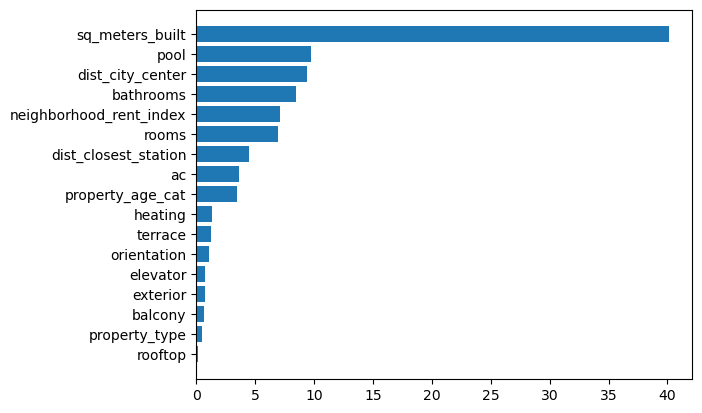

In [61]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y = 'Features'
        , width = 'Importance'
        , data = cat_importance)
ax.invert_yaxis()  # labels read top-to-bottom

Vemos cómo el tamaño del piso marca los resultados del modelo

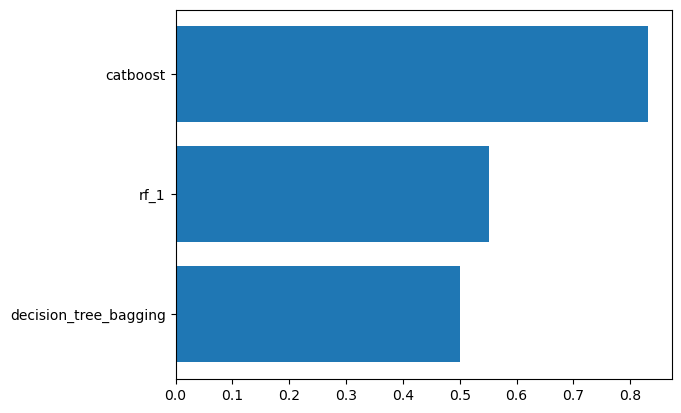

In [62]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(data=results.sort_values('r2_validation', ascending=False)
        , y = 'model'
        , width = 'r2_validation')
ax.invert_yaxis()  # labels read top-to-bottom

# Ejemplo Working Lab Sesión 4: Shap values analysis

In [63]:
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X_train)

In [64]:
print("Attributes")
print("")
print(X_train.iloc[0,:])
print("")
print("Price")
print("")
print(y_train.iloc[0,0])

Attributes

sq_meters_built                    80
rooms                               2
bathrooms                           1
balcony                           0.0
terrace                           0.0
exterior                          1.0
orientation                     oeste
rooftop                           0.0
elevator                          1.0
pool                              0.0
ac                                0.0
heating                            na
dist_city_center             2.283619
property_type                    piso
dist_closest_station          0.52097
property_age_cat              40 - 70
neighborhood_rent_index    800 - 1000
Name: 1487, dtype: object

Price

830


In [65]:
print("CATBoost Shap visualization for instance 0")
shap.force_plot(explainer_cat.expected_value, shap_values_cat[0,:], X_train.iloc[0,:])

CATBoost Shap visualization for instance 0


In [66]:
shap.force_plot(explainer_cat.expected_value, shap_values_cat[0:1000], X_train[0:1000])

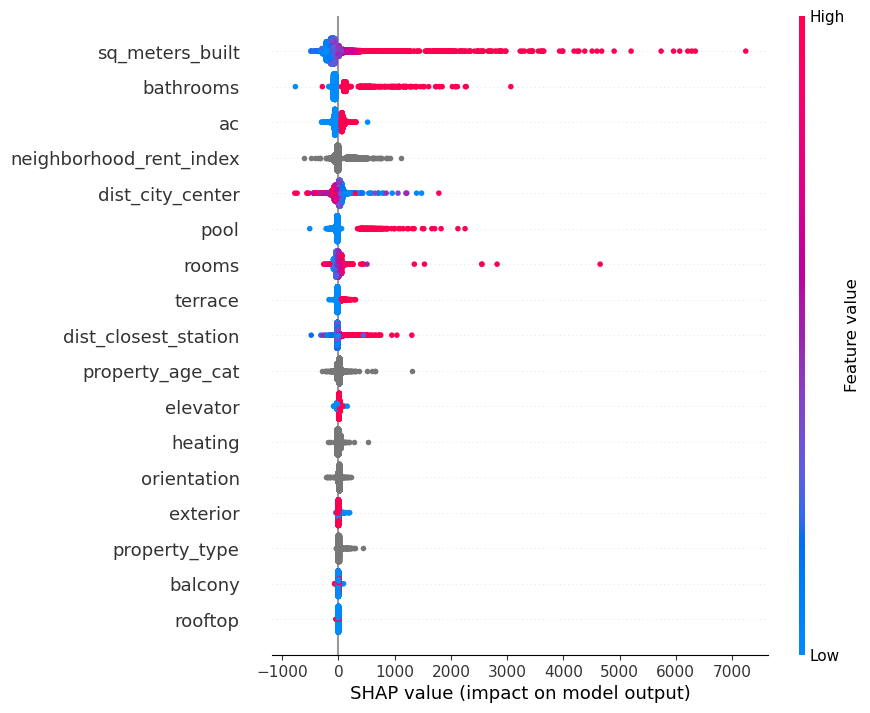

In [67]:
shap.summary_plot(shap_values_cat, X_train)

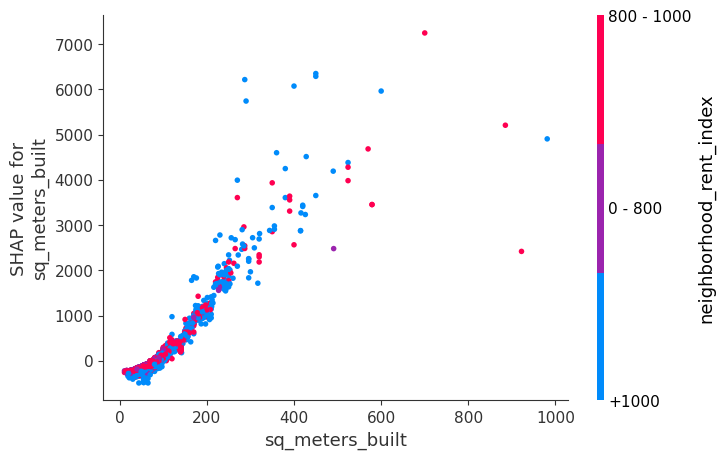

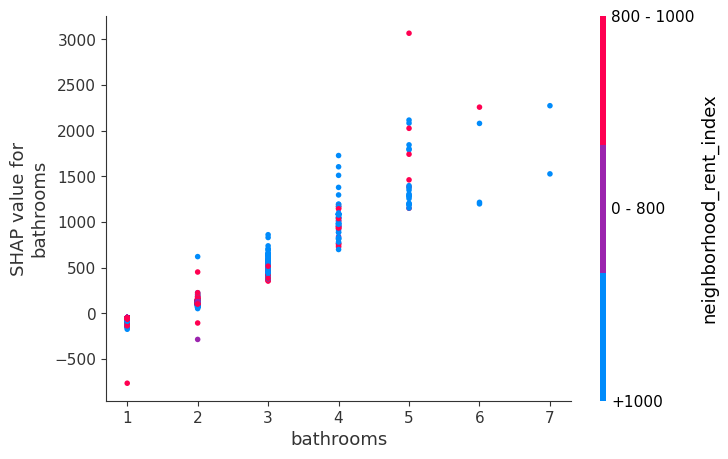

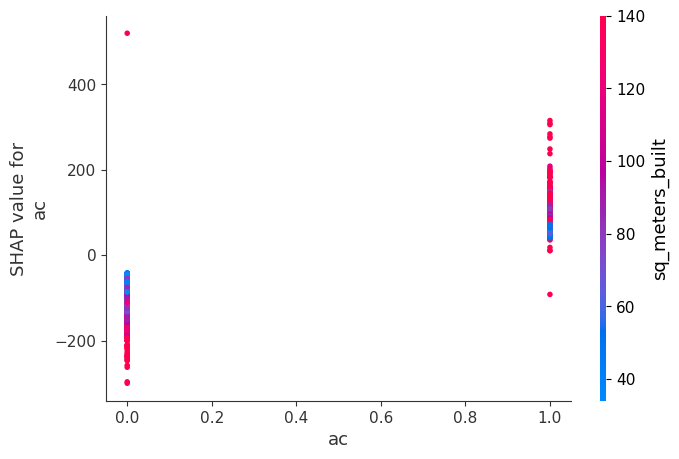

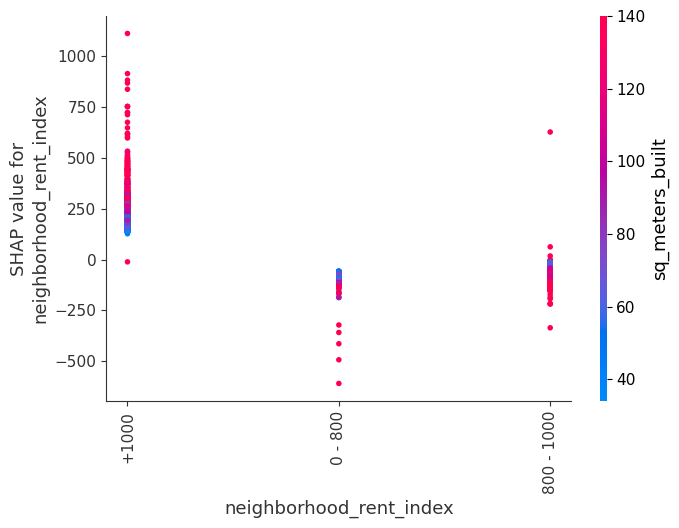

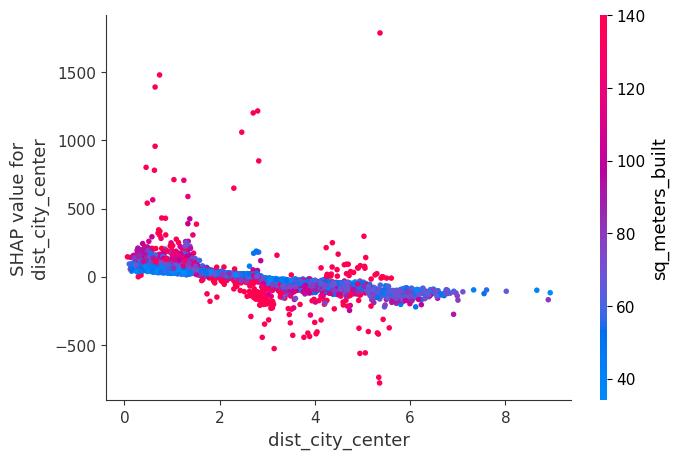

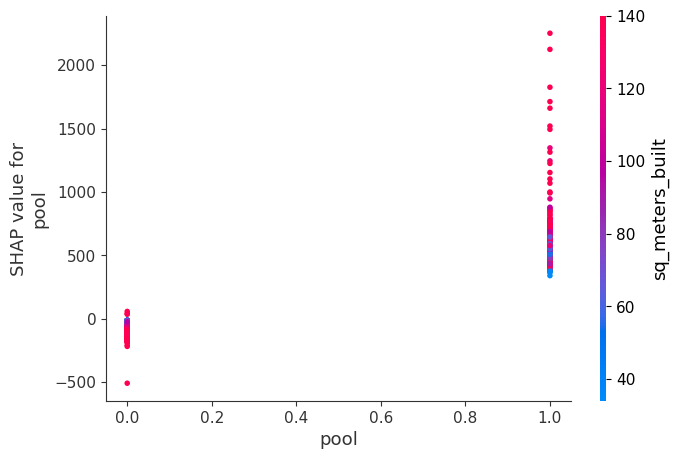

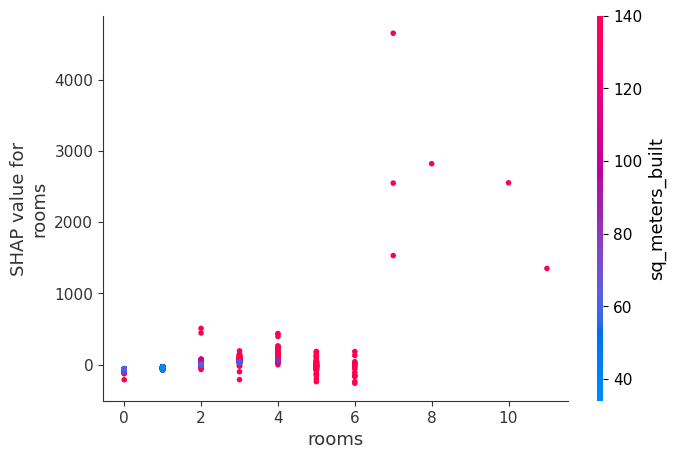

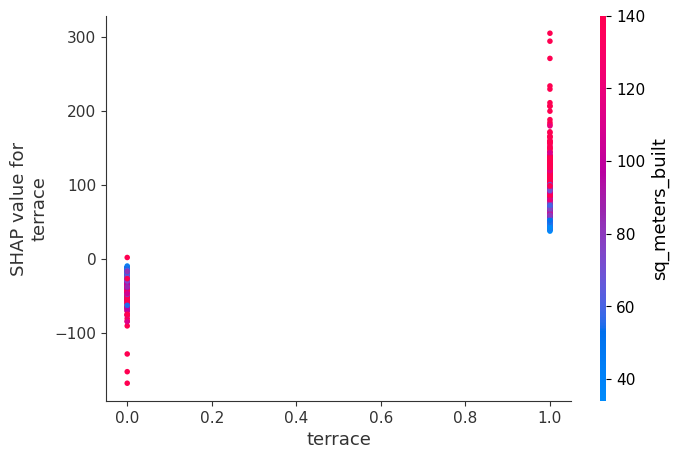

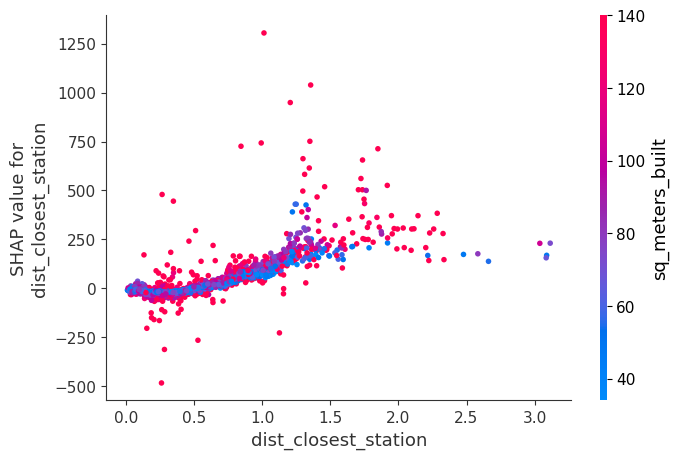

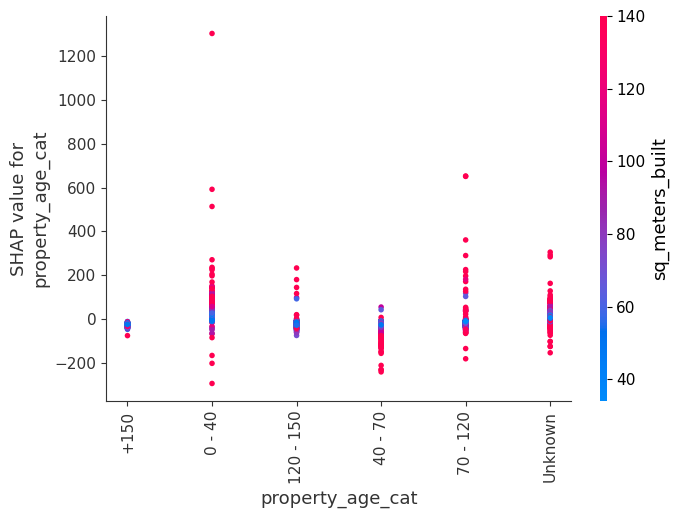

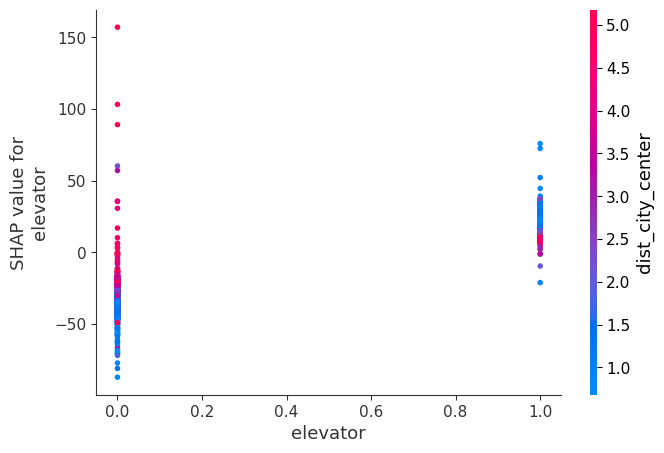

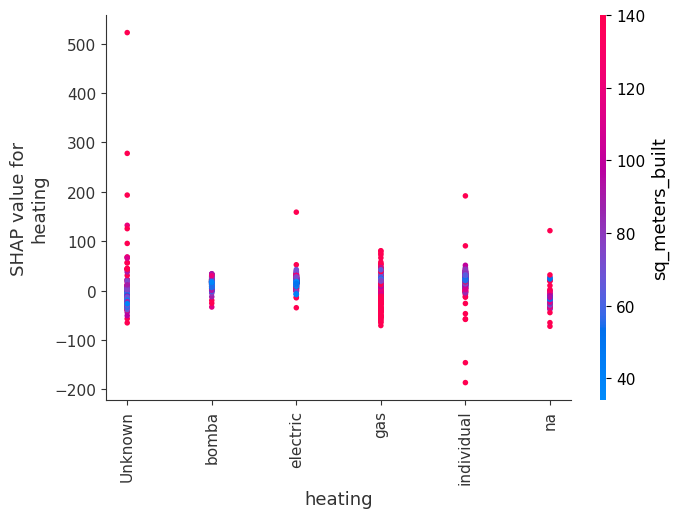

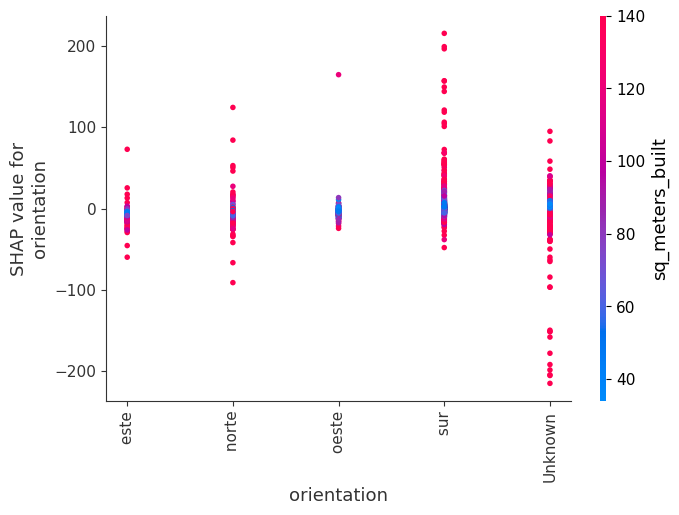

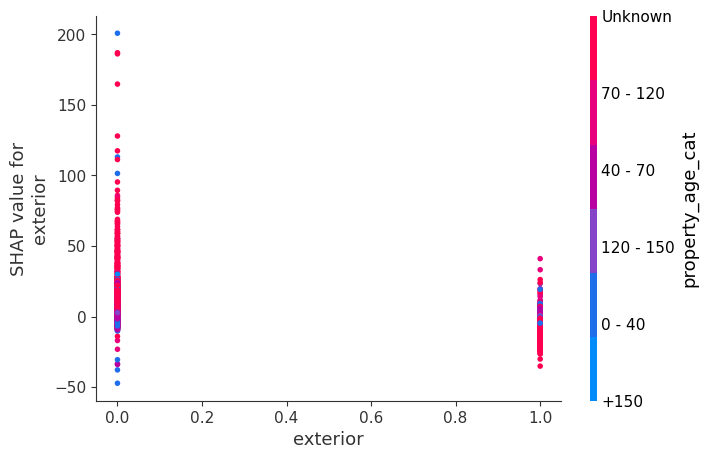

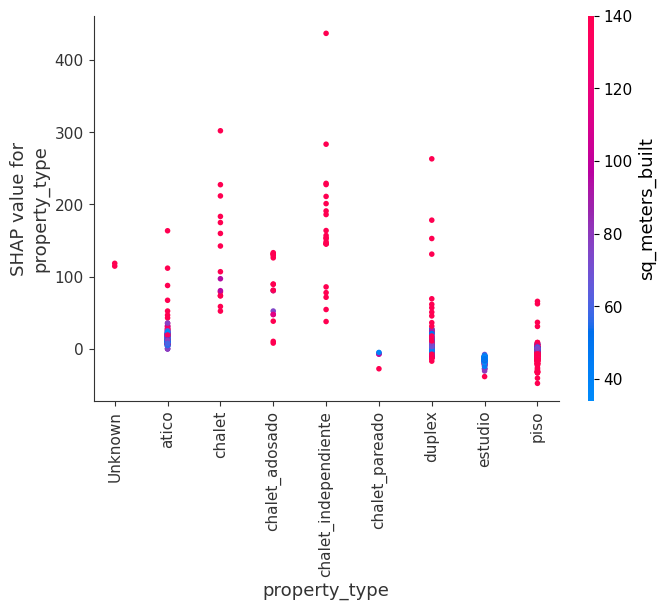

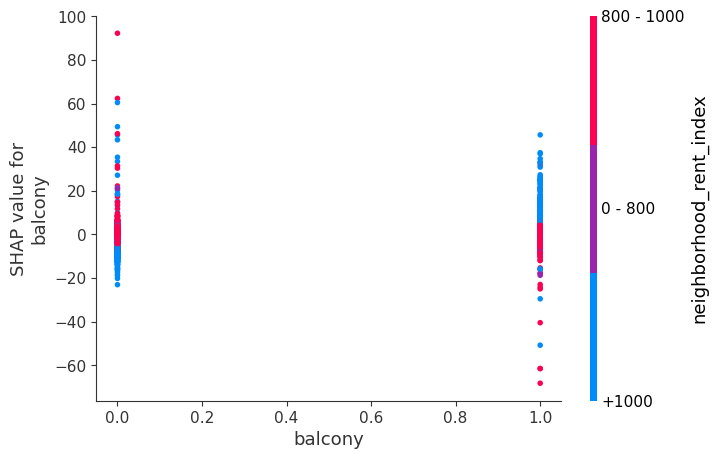

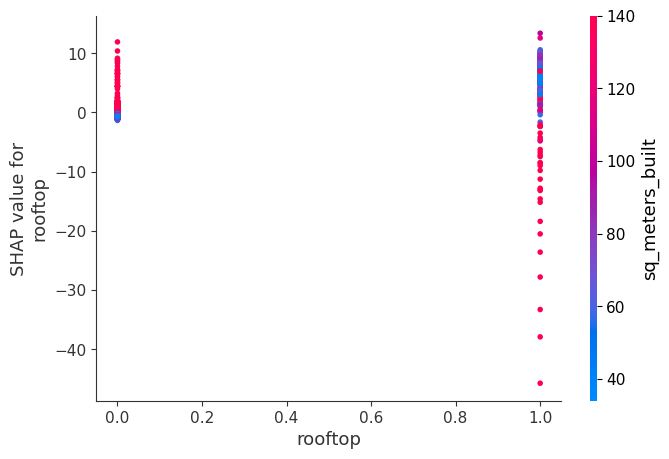

In [68]:
top_inds = np.argsort(-np.sum(np.abs(shap_values_cat), 0))

for i in range(0,len(top_inds)):
    shap.dependence_plot(top_inds[i], shap_values_cat, X_train)